In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import requests.auth
import json
import datetime
from bs4 import BeautifulSoup
import re
import sys
from argparse import ArgumentParser
from itertools import groupby
import matplotlib.image as img
import unittest

In [6]:
# PA, https://data.pa.gov/Covid-19/COVID-19-Aggregate-Death-Data-Current-Daily-County/fbgu-sqgp
# NY, https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Fatalities-by-Co/xymy-pny5
# GA, https://covid-hub.gio.georgia.gov/datasets/GaGIO::georgia-covid-19-death-data/about
# CO, https://data-cdphe.opendata.arcgis.com/datasets/CDPHE::colorado-covid-19-positive-cases-and-rates-of-infection-by-county-of-identification/about

In [7]:
""" Classes for displaying COVID-19 statistics per state in the 
United States. """

class Stats:
    def __init__(self, *data):
        """Calculating and displaying COVID-19 statistics per state.
        
        Attributes:
            data (list): list of CSV files and URL links
    
        Side effects:

        Returns:
        """
        self.data = data
        self.lastmonth = pd.DataFrame()
        self.current = pd.DataFrame()
        self.state = ""
        self.allstates = []
        self.dates = pd.Series(dtype='object')
        self.firstdate = ""
        self.seconddate = ""
        self.cfrDF = pd.DataFrame()
        self.irDF = pd.DataFrame()
        self.statsDF = pd.DataFrame()
        self.datesDF = pd.DataFrame()
        #self.eachstate = []
        self.finalDF = pd.DataFrame()
        self.morange = ()
        self.yrrange = ()
        self.deathlst = []
        self.caseslst = []

    def vax(self):
        """Calculating and displaying vaccinations rates per state.
        
        Attributes:
    
        Side effects:
            makes a request to an API

        Returns:
            (DataFrame):  contains the name and abbreviations of each state,
            fully vaccinated numbers and percentages of vaccination rates,
            current population per rate
            (float):  the sum of fully_vaccinated divided by the sum of 
            curr_pop
        """

        pop2=pd.read_csv(self.data[1])
        vaxxURL=self.data[3]
        CDCdata=requests.get(vaxxURL)
        statesvaxx=pd.DataFrame.from_records(data=CDCdata.json())
        display(statesvaxx)
        statesvaxx=statesvaxx[['date','location','series_complete_yes']]
        statesvaxx.columns=['date','location','fully_vaccinated']
        statesvaxx.loc[:,'date']=statesvaxx['date'].apply(lambda x: 
                                                          datetime.datetime.strptime(
                                                              x,'%Y-%m-%dT%H:%M:%S.000'
                                                          ).strftime('%Y-%m-%d'))
        statesvaxx.loc[:,'day']=statesvaxx['date'].apply(lambda x: 
                                                         datetime.datetime.strptime(
                                                             x,'%Y-%m-%d').strftime('%d'))
        statesvaxx=statesvaxx.groupby('location')['fully_vaccinated'].agg('last').reset_index()
        statesvaxx=statesvaxx[(statesvaxx['location']!='AS') 
                              & (statesvaxx['location']!='BP2') 
                              & (statesvaxx['location']!='DD2') 
                              & (statesvaxx['location']!='FM') 
                              & (statesvaxx['location']!='GU') 
                              & (statesvaxx['location']!='IH2') 
                              & (statesvaxx['location']!='LTC') 
                              & (statesvaxx['location']!='MP') 
                              & (statesvaxx['location']!='RP') 
                              & (statesvaxx['location']!='US') 
                              & (statesvaxx['location']!='VA2') 
                              & (statesvaxx['location']!='VI')].reset_index(drop=True)
        pop2.columns=['SUMLEV', 'REGION', 'DIVISION', 'state', 'name', 'CENSUS2010POP',
               'ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011',
               'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
               'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
               'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE042020',
               'pop2020']
        pop2=pop2[['name','pop2020']].iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
                                            ,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
                                            ,37,38,39,40,41,42,43,56,44,45,46,47,48,49,50
                                            ,51,52,53,54,55]].reset_index(drop=True)
        pop2=pop2.iloc[[1,0,3,2,4,5,6,8,7,9,10,11,15,12,13,14,16,17,18,21,20,19,22,23,25
                        ,24,26,33,34,27,29,30,31,28,32,35,36,37,38,39,40,41,42,43,44,45
                        ,47,46,48,50,49,51]].reset_index(drop=True)
        statesvaxx=statesvaxx.drop([22]).reset_index(drop=True)
        popvaxxed=pd.concat([statesvaxx,pop2],axis=1)
        popvaxxed.columns=['abbr','fully_vaccinated','full_name','curr_pop']
        popvaxxed.loc[:,'percent']=round((popvaxxed['fully_vaccinated']
                                          .astype('int64')/popvaxxed['curr_pop'])*100,2)
        totalvaxx=popvaxxed['fully_vaccinated'].astype('int64').sum()/popvaxxed['curr_pop'].sum()

        return popvaxxed, totalvaxx
    
    def all_time(self):
        """ Visualizations for statistics.
        
        Args:
            None

        Side effects:
            displays text and a bar chart to the terminal

        Returns:
            (str):  percentage of the US that is fully vaccinated
            (bar chart):  displays vaccination rates per state in descending order
        """
        
        df=pd.read_csv(self.data[0])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        df21=df[df['year']=='21']

        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        both21=df.merge(pop)
        states_sqmi=pd.read_csv(self.data[2])
        both21=both21.merge(states_sqmi,left_on='state',right_on='states')
        both21=both21.groupby('state')[[
            'cases','deaths','day','month','year','POP2020','ppsm','sq_mi']].agg('last').reset_index()
        both21.loc[:,'case_fatality']=round((both21['deaths']/both21['cases'])*100,3)
        both21.loc[:,'incidence_rate']=round((both21['cases']/both21['POP2020'])*100000,3)

        return both21
    
    def pretty_graph(self, x, df, cal, feat):

        np.set_printoptions(suppress=True)
        l1=x.lines[0]
        xmaxp=max(l1.get_xydata()[:,0])
        xminp=min(l1.get_xydata()[:,0])
        xavgp=sum(l1.get_xydata()[:,0])/len(l1.get_xydata()[:,0])
        ymaxp=max(l1.get_xydata()[:,1])
        yminp=min(l1.get_xydata()[:,1])
        yavgp=sum(l1.get_xydata()[:,1])/len(l1.get_xydata()[:,1])

        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]
        allval=l1.get_xydata()
        momins=[]
        momaxs=[]
        moavgs=[]
        allmins=[]
        allmaxs=[]

        for num in allval:
            if num[1] == ymaxp:
                allmaxs.append(num)
            if num[1] == yminp:
                allmins.append(num)

        count = 0
        maxNum = []
        minNum = []
        midNum = []
        finalmax = []
        finalmin = []
        finalmid = []
        for num in allval.tolist():
            if len(allval) <= 2:
                maxNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) < 0:
                maxNum.append((count+1,(num[1]-allval[count+1][1])))
            count+=1
            if count == len(allval)-1:
                break
        if len(maxNum) < 1:
            rangexmax = np.array([0,0]) 
            rangeymax = np.array([0,0])
            maxDR = 0
        else:
            maxNum.sort(key=lambda x: x[1])
            maxpos = maxNum[0][0]
            maxDR = maxNum[0][1]

            count=0

            for num in maxNum:
                if num[1] == maxDR:
                    momaxs.append(num)
                else:
                    pass
                count+=1

            if len(momaxs) > 1:
                for num in momaxs:
                    maxpos = int(num[0])
                    if maxpos == 0:
                        rangeymax=y1[maxpos:maxpos+2]
                        rangexmax=x1[maxpos:maxpos+2]
                    elif maxpos == len(y1.tolist()):
                        rangeymax=y1[maxpos-1:maxpos]
                        rangexmax=x1[maxpos-1:maxpos]
                    else:
                        rangeymax=y1[maxpos-1:maxpos+1]
                        rangexmax=x1[maxpos-1:maxpos+1]
                    finalmax.append((rangexmax, rangeymax))

            else:
                if maxpos == 0:
                    rangeymax=y1[maxpos:maxpos+2]
                    rangexmax=x1[maxpos:maxpos+2]
                elif maxpos == len(y1.tolist()):
                    rangeymax=y1[maxpos-1:maxpos]
                    rangexmax=x1[maxpos-1:maxpos]
                else:
                    rangeymax=y1[maxpos-1:maxpos+1]
                    rangexmax=x1[maxpos-1:maxpos+1]

        count=0

        for num in allval.tolist():
            if len(allval) <= 2:
                minNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) >= 0:
                minNum.append((count+1,(num[1]-allval[count+1][1])))
            count+=1
            if count == len(allval)-1:
                break
        minNum.sort(key=lambda x: x[1])
        minpos = minNum[0][0]
        minDR=minNum[0][1]

        count=0

        for num in minNum:
            if num[1] == minDR:
                momins.append(num)
            else:
                pass
            count+=1

        if len(momins) > 1:
            for num in momins:
                minpos = int(num[0])
                if minpos == 0:
                    rangeymin=y1[minpos:minpos+2]
                    rangexmin=x1[minpos:minpos+2]
                elif minpos == len(y1.tolist()):
                    rangeymin=y1[minpos-1:minpos]
                    rangexmin=x1[minpos-1:minpos]
                else:
                    rangeymin=y1[minpos-1:minpos+1]
                    rangexmin=x1[minpos-1:minpos+1]
                finalmin.append((rangexmin, rangeymin))

        else:

            if minpos == 0:
                rangeymin=y1[minpos:minpos+2]
                rangexmin=x1[minpos:minpos+2]
            elif minpos == len(y1.tolist()):
                rangeymin=y1[minpos-1:minpos]
                rangexmin=x1[minpos-1:minpos]
            else:
                rangeymin=y1[minpos-1:minpos+1]
                rangexmin=x1[minpos-1:minpos+1]

        count=0

        for num in allval.tolist():
            if len(allval) <= 2:
                midNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) >= 0:
                midNum.append((count+1,num[1]-allval[count+1][1]))
            count+=1
            if count == len(allval)-1:
                break
        midNum.sort(reverse=True, key=lambda x: x[1])
        midpos = midNum[0][0]
        midDR=midNum[0][1]

        count=0

        for num in midNum:
            if num[1] == midDR:
                moavgs.append(num)
            else:
                pass
            count+=1

        if len(moavgs) > 1:
            for num in moavgs:
                midpos = int(num[0])
                if midpos == 0:
                    rangeymid=y1[midpos:midpos+2]
                    rangexmid=x1[midpos:midpos+2]
                elif midpos == len(y1.tolist()):
                    rangeymid=y1[midpos-1:midpos]
                    rangexmid=x1[midpos-1:midpos]
                else:
                    rangeymid=y1[midpos-1:midpos+1]
                    rangexmid=x1[midpos-1:midpos+1]
                finalmid.append((rangexmid, rangeymid))

        else:

            if midpos == 0:
                rangeymid=y1[midpos:midpos+2]
                rangexmid=x1[midpos:midpos+2]
            elif midpos == len(y1.tolist()):
                rangeymid=y1[midpos-1:midpos]
                rangexmid=x1[midpos-1:midpos]
            else:
                rangeymid=y1[midpos-1:midpos+1]
                rangexmid=x1[midpos-1:midpos+1]

        indexDeaths=df[feat].tolist().index(df[feat].max())
        maxMo=df[cal].iloc[indexDeaths]
        maxDeaths=df[feat].iloc[indexDeaths]
        indexDeaths=df[feat].tolist().index(df[feat].min())
        minMo=df[cal].iloc[indexDeaths]
        minDeaths=df[feat].iloc[indexDeaths]
        
        x.fill_between(x1,y1,color='blue',alpha=0.1)
        avgline=x.axhline(yavgp,color='black',linewidth=2.5)
        minP=x.fill_between(rangexmin,rangeymin,color='green')
        maxP=x.fill_between(rangexmax,rangeymax,color='red')
        midP=x.fill_between(rangexmid,rangeymid,color='purple')

        checkMonths = ["January '20","February '20","March '20","April '20","May '20","June '20","July '20","August '20","September '20",
                       "October '20","November '20","December '20","January '21","February '21","March '21",
                       "April '21","May '21","June '21","July '21","August '21","September '21"]

        if minMo in checkMonths:
            self.firstdate = df[cal].iloc[0]
            self.seconddate = df[cal].iloc[-1]
            findCounty = re.search(r"^.+County", x.title.get_text())
            self.state = findCounty.group(0)
            print(self.state+" statistics from "+self.firstdate+" to "+self.seconddate+".")
        else:
            print(self.state+" statistics from "+self.firstdate+" to "+self.seconddate+".")
            if len(allmins) > 1:
                for num in allmins:
                    minMo=df[cal].iloc[int(num[0])]
                    minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
                    txt="Lowest recorded "+feat+":  {:,} on "+minMo
                    print(txt.format(num[1]))
            else:
                minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
                txt="Lowest recorded "+feat+":  {:,} on "+minMo
                print(txt.format(minDeaths))
            
            if len(allmaxs) > 1:
                for num in allmaxs:
                    maxMo=df[cal].iloc[int(num[0])]
                    maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
                    txt="Highest recorded "+feat+":  {:,} on "+maxMo
                    print(txt.format(num[1]))
            else:
                maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
                txt="Highest recorded "+feat+":  {:,} on "+maxMo
                print(txt.format(maxDeaths))
            #for num in allmins:
            #    minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
            #for num in allmaxs:
            #    maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
            #minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
            #maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
            print(self.state.capitalize()+" statistics from "+self.firstdate+" to "+self.seconddate+".")

        txt="A total of {:,} "+feat+" over the last "+str(df[feat].count())+" days."
        print(txt.format(round(df[feat].sum()),2))
        txt="Average "+feat[:-1]+" rate:  {:,} per day."
        print(txt.format(round(df[feat].sum()/len(df[feat]),2)))

        #if len(allmaxs) > 1:
        #    for num in allmaxs:
        #        maxMo=df[cal].iloc[int(num[0])]
                #maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
        #        txt="Highest recorded "+feat+":  {:,} on "+str(maxMo)
        #        print(txt.format(num[1]))
        #else:
        #    txt="Highest recorded "+feat+":  {:,} on "+str(maxMo)
        #    print(txt.format(maxDeaths))

        #if len(allmins) > 1:
        #    for num in allmins:
        #        minMo=df[cal].iloc[int(num[0])]
                #minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
        #        txt="Lowest recorded "+feat+":  {:,} on "+minMo
        #        print(txt.format(num[1]))
        #else:
        #    txt="Lowest recorded "+feat+":  {:,} on "+str(minMo)
        #    print(txt.format(minDeaths))

        if len(finalmax) > 1:
            for allthemaxs in finalmax:
                 maxP=x.fill_between(allthemaxs[0],allthemaxs[1],color='red')
        if len(finalmin) > 1:
            for allthemins in finalmin:
                minP=x.fill_between(allthemins[0],allthemins[1],color='green')
                plt.plot([finalmin[0][0],finalmin[-1][0]],[0,0], linewidth=7, color='green')
        if len(finalmid) > 1:
            for alltheavgs in finalmid:
                midP=x.fill_between(alltheavgs[0],alltheavgs[1],color='purple')
        if minDR == 0 and len(finalmin) < 1:
            plt.plot([rangexmin[0],rangexmin[1]],[0,0], linewidth=7, color='green')

        #if len(allmaxs) > 1:
        #    pass
        #else:
        #    txt="Highest recorded "+feat+":  {:,} on "+str(maxMo)
        #    print(txt.format(maxDeaths))
        #if len(allmins) > 1:
        #    pass
        #else:
        #    txt="Lowest recorded "+feat+":  {:,} on "+str(minMo)
        #    print(txt.format(minDeaths))

        txt="Largest increase in "+feat+":  {:,}."
        if maxDR == 0:
            print(txt.format(maxDR))
        else:
            print(txt.format(maxDR*-1))

        txt="Smallest rate of "+feat+": {:,}."
        print(txt.format(minDR))

        txt="Largest drop in "+feat+": {:,}"
        print(txt.format(midDR))

        logo = img.imread(fname='watermarkMAR.png')
        x.figure.figimage(logo,110,270,alpha=0.5)

        plt.legend(labels=['smallest rate','largest drop','largest increase','average rate'],
                       handles=[minP,midP,maxP,avgline], shadow=True, title=feat.capitalize(),
                      title_fontsize='large', borderpad=0.3, fontsize='small')
        plt.show()

        return None

    def loadData(self, state, curr, lastmo, curryear=21, lastyear=21):
        
        if lastmo > curr:
            if lastyear > curryear:
                print("Enter correct parameters.")
                return None
            if lastyear == curryear:
                print("Enter correct parameters.")
                return None

        df=pd.read_csv(self.data[0])
        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        sqmi=pd.read_csv(self.data[2])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        df=df.merge(pop)
        abbr=pd.read_csv(self.data[4])
        df=df.merge(abbr, left_on='state',right_on='full_name')
        df=df.drop(['full_name'],axis=1).reset_index(drop=True)
        self.state=state

        jan20=df[(df['year']==20) & (df['month']==1)]['state'].unique().tolist()
        feb20=df[(df['year']==20) & (df['month']==2)]['state'].unique().tolist()

        current=df[(df['month']==curr) & (df['year']==curryear)]

        if lastyear==20 and curryear==21:
            lastmonth=df[(df['month']==lastmo) & (df['year']==lastyear)]
            one=df[(df['month']>=lastmo+1) & (df['year']==lastyear)]
            two=df[(df['month']<=curr) & (df['year']==curryear)]
            current=pd.concat([one,two]).reset_index(drop=True)
        #elif lastmo==1 and lastyear==21:
        #    mo=12
        #    years=20
        #    lastmonth=df[(df['month']>=mo) & (df['year']==years)]
        #    current=df[(df['month']>=lastmo) & (df['month']<=curr) & (df['year']==curryear)]
        elif lastmo==1 and lastyear==20:
            if state in jan20:
                lastmonth=df[(df['month']==1) & (df['day']>=26) & (df['year']==lastyear)]
                current=df[(df['month']>=2) & (df['month']<=curr) & (df['year']==curryear)]
            elif state in feb20:
                lastmonth=df[(df['month']==2) & (df['day']>=28) & (df['year']==lastyear)]
                current=df[(df['month']>=3) & (df['month']<=curr) & (df['year']==curryear)]
            else:
                lastmonth=df[(df['month']==3) & (df['day']>=17) & (df['year']==lastyear)]
                current=df[(df['month']>=4) & (df['month']<=curr) & (df['year']==curryear)]
        elif lastmo == curr:
            lastmonth=df[(df['month']==lastmo) & (df['year']==lastyear)]
        else:
            if abs(curr-lastmo)>=2:
                lastmonth=df[(df['month']==lastmo) & (df['year']==lastyear)]
                current=df[(df['month']>=lastmo+1) & (df['month']<=curr) & (df['year']==curryear)]
            else:
                lastmonth=df[(df['month']==lastmo) & (df['year']==lastyear)]

        self.morange=(lastmo, curr)
        self.yrrange=(lastyear, curryear)
        allstates=current['state'].unique().tolist()
        
        caseslst=[]
        deathlst=[]

        for sts in allstates:
            laststat=lastmonth[lastmonth['state']==sts].reset_index(drop=True)
            statscurr=current[current['state']==sts].reset_index(drop=True)
            if lastmonth['month'].iloc[0] == current['month'].iloc[0]:
                stats=statscurr
            else:
                stats=pd.concat([laststat,statscurr]).reset_index(drop=True)
            count=0
            if sts==state:
                dates=stats['date']
            data=stats
            col="cases"
            lst3=[]
            lst4=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst3.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst3) == 1:
                    if lst3[0] >= 0:
                        lst4.append(lst3[0])
                    else:
                        lst4.append(-(lst3[0]))
                    continue
                if deaths < 0:
                    lst4.append(-(lst3[count-1]))
                else:
                    lst4.append(lst3[count-1])
            lst4.insert(0,first)
            caseslst.append(lst4)

            count=0
            data=stats
            col="deaths"
            lst5=[]
            lst6=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst5.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst5) == 1:
                    if lst5[0] >= 0:
                        lst6.append(lst5[0])
                    else:
                        lst6.append(-(lst5[0]))
                    continue
                if deaths < 0:
                    lst6.append(-(lst5[count-1]))
                else:
                    lst6.append(lst5[count-1])
            lst6.insert(0,first)
            deathlst.append(lst6)
        
        IRlst=[]
        CFRlst=[]
        avgCases=[]
        avgDeaths=[]
        totalCases=[]
        totalDeaths=[]
        casessts=[]
        deathssts=[]
        eachstate=[]

        for things, things2, sts in zip(caseslst, deathlst, allstates):
            stats=current[current['state']==sts].reset_index(drop=True)
            IR=round((sum(things[1:])/stats['POP2020'].iloc[1])*100000,3)
            IRlst.append(IR)
            CFR=round((sum(things2[1:])/sum(things[1:]))*100,3)
            CFRlst.append(CFR)
            avgCases.append(round(sum(things[1:])/len(things[1:]),2))
            avgDeaths.append(round(sum(things2[1:])/len(things2[1:]),2))
            totalCases.append(sum(things[1:]))
            totalDeaths.append(sum(things2[1:]))
            eachstate.append(pd.DataFrame({'state':sts,'deaths':things2[1:],'cases':things[1:]}))
            casessts.append((sts,things[1:]))
            deathssts.append((sts,things2[1:]))

        popvaxxed=self.vax()[0]
        irDF=pd.DataFrame({'states':allstates,'IR':IRlst})
        cfrDF=pd.DataFrame({'states':allstates,'CFR':CFRlst})
        statsDF=pd.DataFrame({'states':allstates,'avg_cases':avgCases,'avg_deaths':avgDeaths,'total_cases':totalCases,'total_deaths':totalDeaths})
        statsDF=statsDF.merge(popvaxxed[['full_name','curr_pop','percent']],left_on='states',right_on='full_name')
        self.statsDF=statsDF.drop(columns='full_name')
        self.firstdate=datetime.datetime.strptime(lastmonth.iloc[1]['date'],'%Y-%m-%d').strftime('%B %d')
        self.seconddate=datetime.datetime.strptime(current.iloc[-1]['date'],'%Y-%m-%d').strftime('%B %d')
        dates=dates.drop([0]).reset_index(drop=True)
        self.irDF=irDF
        self.cfrDF=cfrDF

        for st, cs in casessts:
            if st==state:
                datesDF=pd.DataFrame({'dates':dates,'cases':cs})
        for st, ds in deathssts:
            if st==state:
                datesDF=datesDF.merge(pd.DataFrame({'dates':dates,'deaths':ds}))
        self.datesDF = datesDF

        pop=self.all_time()
        state_sqmi=pd.read_csv(self.data[2])
        for num in pop['state'].tolist():
            if num==state:
                popstate=pop.sort_values(by='POP2020',ascending=False).reset_index(drop=True)
                popNum=popstate['state'].tolist().index(num)
                vaxxedorder=popvaxxed.sort_values(by='percent',ascending=False).reset_index(drop=True)
                pct=vaxxedorder['full_name'].tolist().index(num)
                ppsm=state_sqmi['states'].tolist().index(num)
                sqmiorder=state_sqmi.sort_values(by='sq_mi',ascending=False).reset_index(drop=True)
                sqmiNum=sqmiorder['states'].tolist().index(num)
                cfrDF=cfrDF.sort_values(by='CFR',ascending=False).reset_index(drop=True)
                cfrNum=cfrDF['states'].tolist().index(num)
                irDF=irDF.sort_values(by='IR',ascending=False).reset_index(drop=True)
                irNum=irDF['states'].tolist().index(num)
                totalpop=popstate.iloc[[popNum]]['POP2020'][popNum]
                both21=self.all_time()
                both21=both21.sort_values(by='case_fatality',ascending=False).reset_index(drop=True)
                bothNum=both21['state'].tolist().index(num)
                natrank1=both21['state'].tolist().index(num)
                cfr=both21.iloc[[bothNum]]['case_fatality'][bothNum]
                both21=both21.sort_values(by='incidence_rate',ascending=False).reset_index(drop=True)
                bothNum=both21['state'].tolist().index(num)
                ir=both21.iloc[[bothNum]]['incidence_rate'][bothNum]
                natrank2=both21['state'].tolist().index(num)
                totcases=statsDF.sort_values(by='total_cases',ascending=False).reset_index(drop=True)
                totdeaths=statsDF.sort_values(by='total_deaths',ascending=False).reset_index(drop=True)
                casesNum=totcases['states'].tolist().index(num)
                deathsNum=totdeaths['states'].tolist().index(num)

                display("State of "+state)
                avgstats=statsDF.sort_values(by='avg_cases',ascending=False).reset_index(drop=True)
                statsNum=avgstats['states'].tolist().index(num)
                txt="Average of {:,} cases per day in "+str(round(datesDF.describe().iloc[0][0],2))+" days, currently ranked #"+str(statsNum+1)+" in the United States."                    
                display(txt.format(round(datesDF.describe().iloc[1][0],2),2))
                avgstats=statsDF.sort_values(by='avg_deaths',ascending=False).reset_index(drop=True)
                statsNum=avgstats['states'].tolist().index(num)
                txt="Average of {:,} deaths per day in "+str(round(datesDF.describe().iloc[0][0],2))+" days, currently ranked #"+str(statsNum+1)+" in the United States."
                display(txt.format(round(datesDF.describe().iloc[1][1],2)))

                display("Case Fatality Ratio from "+self.firstdate+" to "+self.seconddate+": "+str(cfrDF['CFR'].iloc[cfrNum])+"%, currently ranked #"+str(cfrNum+1)+" in the United States.")
                txt="Incidence Rate from "+self.firstdate+" to "+self.seconddate+": {:,} per 100k, currently ranked #"+str(irNum+1)+" in the United States."
                display(txt.format(irDF['IR'].iloc[irNum]))
                txt="There have been {:,} cases from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
                display(txt.format(datesDF['cases'].sum(),casesNum+1))
                txt="There have been {:,} deaths from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
                display(txt.format(datesDF['deaths'].sum(),deathsNum+1))

                display(state+" is "+str(vaxxedorder.iloc[pct]['percent'])+"% fully vaccinated, currently ranked #"+str(pct+1)+" in the United States.")
                txt="Total population: {:,}, ranked #"+str(popNum+1)+" in the United States."
                display(txt.format(totalpop))
                txt="There are {:,} people per square mile, ranked #"+str(ppsm+1)+" in the United States." 
                display(txt.format(state_sqmi.iloc[ppsm]['ppsm']))
                txt=state+" has {:,} total square miles, ranking #"+str(sqmiNum+1)+" in the United States."
                display(txt.format(sqmiorder.iloc[sqmiNum]['sq_mi']))
                display("All Time Case Fatality Ratio: "+str(cfr)+"%, currently ranked #"+str(natrank1+1)+" in the United States.")
                txt="All Time Incidence Rate: {:,} per 100k, currently ranked #"+str(natrank2+1)+" in the United States."
                display(txt.format(ir))
                display(round(datesDF.describe().T,2))

                for stuff in eachstate:
                    if stuff['state'].iloc[0]==state:
                        self.finalDF=pd.DataFrame({'dates':dates,'cases':stuff['cases'],'deaths':stuff['deaths']})        
        return None

    def graph(self, data, col=None):
        """ Visualizations for statistics.
        
        Args:
            data (object):  returned data from a class function
            col (str):  

        Side effects:
            displays text and a bar chart to the terminal

        Returns:
            (str):  percentage of the US that is fully vaccinated
            (bar chart):  displays vaccination rates per state in descending order
        """

        lst=["percent","POP2020","dates","CFR","IR","avg_cases"]
        for things in lst:
            
            try:
                if things == "dates" and things in data.columns:

                    first=40
                    monthRange = self.morange[1] - self.morange[0]
                    if self.yrrange[0] == self.yrrange[1]:
                        if self.morange[1] > self.morange[0]:
                            first = (60 if monthRange < 3
                                    else 120 if monthRange > 2 and monthRange <= 4
                                    else 180 if monthRange > 4 and monthRange <= 6
                                    else 240 if monthRange > 6 and monthRange <= 8
                                    else 300 if monthRange > 8 and monthRange <= 10
                                    else 360)
                    else:
                        if self.yrrange[1] > self.yrrange[0]:
                            newmorange = self.morange[0]
                            newmorange = 12 - self.morange[0]
                            monthRange = newmorange+self.morange[1]
                            first = (240 if self.morange[0] == self.morange[1]
                                     else 280 if abs(monthRange) >= 1 and abs(monthRange) <= 4
                                     else 320 if abs(monthRange) > 4 and abs(monthRange) <= 6
                                     else 360 if abs(monthRange) > 6 and abs(monthRange) <= 8
                                     else 400 if abs(monthRange) > 8 and abs(monthRange) <= 10
                                     else 440 if abs(monthRange) > 10 and abs(monthRange) <= 12
                                     else 480 if abs(monthRange) > 12 and abs(monthRange) <= 14
                                     else 520)

                    figsize=(first,20)
                    xlabel = self.datesDF['dates'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%B %d")).tolist()
                    xlist = self.datesDF['dates'].tolist()

                    sns.set(font_scale=3)
                    sns.set_style("whitegrid")
                    plt.figure(figsize=figsize)
                    x=sns.lineplot(data=self.finalDF,y='deaths',x='dates',ci=None, linewidth=7, color='black')
                    x.tick_params(axis='x', rotation=65)
                    x.set_title(self.state+" COVID-19 Death Rate From "+self.firstdate+" To "+self.seconddate,fontsize=35);
                    x.set_xlabel("Dates")
                    x.set_ylabel("Deaths")
                    x.set_xticks(xlist)
                    x.set_xticklabels(xlabel)
                    self.pretty_graph(x, self.finalDF, self.datesDF.columns[0], self.finalDF.columns[2])
                    #plt.savefig(self.state+"_"+"death_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
                    #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

                    sns.set(font_scale=3)
                    sns.set_style("whitegrid")
                    plt.figure(figsize=figsize)
                    x=sns.lineplot(data=self.finalDF,y='cases',x='dates',ci=None, linewidth=7, color='black')
                    x.tick_params(axis='x', rotation=65)
                    x.set_title(self.state+" COVID-19 Case Rate From "+self.firstdate+" To "+self.seconddate,fontsize=35);
                    x.set_xlabel("Dates")
                    x.set_ylabel("Cases")
                    x.set_xticks(xlist)
                    x.set_xticklabels(xlabel)
                    self.pretty_graph(x, self.finalDF, self.datesDF.columns[0], self.finalDF.columns[1])
                    #plt.savefig(self.state+"_"+"incidence_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
                    #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

                if things=="percent" and things in data.columns:
                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,25))
                    x=sns.barplot(data=data.sort_values(by='percent',ascending=False)
                                      ,x='percent',y='full_name',ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title("United States COVID-19 Vaccination Rates Per State as of today.",fontsize=35)
                    x.set_xlabel("Percent")
                    x.set_ylabel("States")
                    plt.savefig("US_"+"vaccination_rates"+str(self.morange[0])+str(self.yrrange[0])
                                +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight')
                    print("The United States is %"+str(round(self.vax()[1]*100, 2))
                          +" fully vaccinated.");

                if things=="POP2020" and things in data.columns:
                    if len(str(data.loc[0,['month','year']]['month'])) < 2:
                        x="0"+str(data.loc[0,['month','year']]['month'])
                    newdate=[x+","+str(data.loc[0,['month','year']]['year'])]
                    seconddate=datetime.datetime.strptime(
                        newdate[0],'%m,%y'
                    ).strftime('%B %Y')

                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,30))
                    x=sns.barplot(data=data.sort_values(by='case_fatality',ascending=False),y='state',x='case_fatality',ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title("All Time COVID-19 Case Fatality Ratio Per State from January 2020 to"
                                +" "+self.seconddate,fontsize=35)
                    x.set_xlabel("Cases")
                    x.set_ylabel("States");

                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,30))
                    x=sns.barplot(data=data.sort_values(by='incidence_rate',ascending=False),y='state',x='incidence_rate',ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title("All Time COVID-19 Incidence Rate Per State from January 2020 to"
                                +" "+self.seconddate,fontsize=35)
                    x.set_xlabel("Percent")
                    x.set_ylabel("States");

                if things=="CFR" and things in data.columns:

                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,25))
                    x=sns.barplot(data=self.cfrDF.sort_values(by='CFR',ascending=False),y='states',x='CFR',ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title("Case Fatality Rates Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35);
                    x.set_xlabel("Case Fatalities (Percent)")
                    x.set_ylabel("States")
                    #plt.savefig("US_"+"case_fatality_rates"+"_"+str(self.morange[0])+str(self.yrrange[0])
                    #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

                if things=="IR" and things in data.columns:

                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,25))
                    x=sns.barplot(data=self.irDF.sort_values(by='IR',ascending=False),y='states',x='IR',ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title("Incidence Rates Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35);
                    x.set_xlabel("Confirmed Cases (Per 100k)")
                    x.set_ylabel("States")
                    #plt.savefig("US_"+"incidence_rates"+"_"+str(self.morange[0])+str(self.yrrange[0])
                    #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

                if things=="avg_cases" and things in data.columns:

                    if col==None:
                        col="avg_cases"
                    display(data.columns.tolist()[1:])

                    sns.set(font_scale=3)
                    plt.figure(figsize=(40,30))
                    x=sns.barplot(data=self.statsDF.sort_values(by=col,ascending=False),y='states',x=col,ci=None)
                    x.tick_params(axis='x', rotation=65)
                    x.set_title(col.capitalize()+" Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35)
                    if col=='curr_pop':
                        x.ticklabel_format(style='plain', axis='x')
                    x.set_xlabel("Confirmed Cases")
                    x.set_ylabel("States")
                    plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
                                +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');
                    
                

            except ValueError:
                continue

def parse_args(arglist):

    parser = ArgumentParser()
    parser.add_argument("data", help="CSV files and URL links",
                        type=str)
    args = parser.parse_args(arglist)

    return args

def main(arglist):

    args = parse_args(arglist)
    w=Stats(args.file)

    return None

In [8]:
"""
class States:
    def __init__(self):

        self.links = {"MD":"https://opendata.arcgis.com/datasets/3dbd3e633b344c7c9a0d166b1d6a2b03_0.geojson",
             "PA":"https://data.pa.gov/resource/fbgu-sqgp.json",
                     "GA":"https://opendata.arcgis.com/datasets/8caebe8387dc4272b18739e6b30daaa7_0.geojson"}

    def getDF(self):
        states = requests.get("https://data.pa.gov/resource/fbgu-sqgp.json")
        paDeaths = pd.DataFrame.from_records(states.json())
        paDeaths = paDeaths[['county', 'date', 'deaths_cume']]
        counties = paDeaths['county'].unique().tolist()
        padates = paDeaths[['date']]
        paDeaths = paDeaths.pivot(index=None,columns='county', values='deaths_cume')
        paDeaths = paDeaths.merge(padates,left_index=True,right_index=True)

        paDeaths['date']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.000').strftime('%Y-%m-%d'))
        paDeaths.loc[:,'day']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        paDeaths.loc[:,'month']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        paDeaths.loc[:,'year']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))

        paDeaths = paDeaths[['date','Luzerne','Wyoming','Philadelphia','Fulton','Butler','McKean','Pennsylvania',
                             'Dauphin','Berks','Potter','Mifflin','Lancaster','Forest','Clinton','Carbon',
                             'Pike','Snyder','Blair','Crawford','Lycoming','Erie','Columbia','Centre','Bedford',
                             'Schuylkill','Lehigh','Union','Huntingdon','Indiana','Susquehanna','Cameron','Juniata',
                             'Armstrong','Adams','Cumberland','Beaver','Lawrence','Bradford','Sullivan','Montgomery',
                             'Perry','Greene','Monroe','Montour','York','Somerset','Westmoreland','Jefferson',
                             'Lackawanna','Venango','Mercer','Clearfield','Clarion','Elk','Wayne','Northampton',
                             'Washington','Northumberland','Cambria','Allegheny','Chester','Fayette','Franklin',
                             'day','month','year']]
        paDeaths20 = paDeaths[paDeaths['year']=='20']
        paDeaths20 = paDeaths20.fillna(0)
        x=paDeaths20.groupby('month')[['Luzerne','Wyoming','Philadelphia','Fulton','Butler','McKean','Pennsylvania',
                             'Dauphin','Berks','Potter','Mifflin','Lancaster','Forest','Clinton','Carbon',
                             'Pike','Snyder','Blair','Crawford','Lycoming','Erie','Columbia','Centre','Bedford',
                             'Schuylkill','Lehigh','Union','Huntingdon','Indiana','Susquehanna','Cameron','Juniata',
                             'Armstrong','Adams','Cumberland','Beaver','Lawrence','Bradford','Sullivan','Montgomery',
                             'Perry','Greene','Monroe','Montour','York','Somerset','Westmoreland','Jefferson',
                             'Lackawanna','Venango','Mercer','Clearfield','Clarion','Elk','Wayne','Northampton',
                             'Washington','Northumberland','Cambria','Allegheny','Chester','Fayette','Franklin']].agg('last').reset_index().astype('int64')
        return x

    def PA(self):
        while True:
            try:
                print("...")
                URL = self.links['PA']
                states = requests.get(URL)
                paDeaths = pd.DataFrame.from_records(states.json())
                paDeaths = paDeaths[['county', 'date', 'deaths_cume']]
                counties = paDeaths['county'].unique().tolist()
                padates = paDeaths[['date']]
                paDeaths = paDeaths.pivot(index=None,columns='county', values='deaths_cume')
                paDeaths = paDeaths.merge(padates,left_index=True,right_index=True)
                print("....")
                paDeaths['date']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.000').strftime('%Y-%m-%d'))
                paDeaths.loc[:,'day']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
                paDeaths.loc[:,'month']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
                paDeaths.loc[:,'year']=paDeaths['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))

                paDeaths = paDeaths[['date','Luzerne','Wyoming','Philadelphia','Fulton','Butler','McKean','Pennsylvania',
                                     'Dauphin','Berks','Potter','Mifflin','Lancaster','Forest','Clinton','Carbon',
                                     'Pike','Snyder','Blair','Crawford','Lycoming','Erie','Columbia','Centre','Bedford',
                                     'Schuylkill','Lehigh','Union','Huntingdon','Indiana','Susquehanna','Cameron','Juniata',
                                     'Armstrong','Adams','Cumberland','Beaver','Lawrence','Bradford','Sullivan','Montgomery',
                                     'Perry','Greene','Monroe','Montour','York','Somerset','Westmoreland','Jefferson',
                                     'Lackawanna','Venango','Mercer','Clearfield','Clarion','Elk','Wayne','Northampton',
                                     'Washington','Northumberland','Cambria','Allegheny','Chester','Fayette','Franklin',
                                     'day','month','year']]
                paDeaths20 = paDeaths[paDeaths['year']=='20']
                paDeaths20 = paDeaths20.fillna(0)
                paDeaths21 = paDeaths[paDeaths['year']=='21']
                paDeaths21 = paDeaths21.fillna(0)
                x=paDeaths20.groupby('month')[['Luzerne','Wyoming','Philadelphia','Fulton','Butler','McKean','Pennsylvania',
                                     'Dauphin','Berks','Potter','Mifflin','Lancaster','Forest','Clinton','Carbon',
                                     'Pike','Snyder','Blair','Crawford','Lycoming','Erie','Columbia','Centre','Bedford',
                                     'Schuylkill','Lehigh','Union','Huntingdon','Indiana','Susquehanna','Cameron','Juniata',
                                     'Armstrong','Adams','Cumberland','Beaver','Lawrence','Bradford','Sullivan','Montgomery',
                                     'Perry','Greene','Monroe','Montour','York','Somerset','Westmoreland','Jefferson',
                                     'Lackawanna','Venango','Mercer','Clearfield','Clarion','Elk','Wayne','Northampton',
                                     'Washington','Northumberland','Cambria','Allegheny','Chester','Fayette','Franklin']].agg('last').reset_index().astype('int64')
                while len(x) < 9:
                    x=self.getDF()
                    print(len(x))

                y=paDeaths21.groupby('month')[['Luzerne','Wyoming','Philadelphia','Fulton','Butler','McKean','Pennsylvania',
                                     'Dauphin','Berks','Potter','Mifflin','Lancaster','Forest','Clinton','Carbon',
                                     'Pike','Snyder','Blair','Crawford','Lycoming','Erie','Columbia','Centre','Bedford',
                                     'Schuylkill','Lehigh','Union','Huntingdon','Indiana','Susquehanna','Cameron','Juniata',
                                     'Armstrong','Adams','Cumberland','Beaver','Lawrence','Bradford','Sullivan','Montgomery',
                                     'Perry','Greene','Monroe','Montour','York','Somerset','Westmoreland','Jefferson',
                                     'Lackawanna','Venango','Mercer','Clearfield','Clarion','Elk','Wayne','Northampton',
                                     'Washington','Northumberland','Cambria','Allegheny','Chester','Fayette','Franklin']].agg('last').reset_index().astype('int64')
                newcountydeaths=pd.concat([x,y]).reset_index(drop=True)
                #newcountydeaths = newcountydeaths.append([newcountydeaths.iloc[0]],ignore_index=True)
                #newcountydeaths.loc[[18], newcountydeaths.columns[1:]] = 0
                #newcountydeaths = newcountydeaths.iloc[[18,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]].reset_index(drop=True)
                #newcountydeaths.iloc[0]['month'] = 3
                print(".....")
                break
            except KeyError:
                continue

        return newcountydeaths, counties
    
    def MD(self):
        
        while True:
            try:
                print("...")
                URL = self.links['MD']
                states = requests.get(URL)
                mdDeaths=pd.json_normalize(states.json()['features'])

                mdDeaths.columns=['type', 'geometry', 'Index', 'DATE',
                       'Allegany', 'Anne_Arundel',
                       'Baltimore', 'Baltimore_City',
                       'Calvert', 'Caroline', 'Carroll',
                       'Cecil', 'Charles', 'Dorchester',
                       'Frederick', 'Garrett', 'Harford',
                       'Howard', 'Kent', 'Montgomery',
                       'Prince_Georges', 'Queen_Annes',
                       'Somerset', 'St_Marys', 'Talbot',
                       'Washington', 'Wicomico', 'Worcester',
                       'Unknown']
                mdDeaths=mdDeaths[['DATE',
                       'Allegany', 'Anne_Arundel',
                       'Baltimore', 'Baltimore_City',
                       'Calvert', 'Caroline', 'Carroll',
                       'Cecil', 'Charles', 'Dorchester',
                       'Frederick', 'Garrett', 'Harford',
                       'Howard', 'Kent', 'Montgomery',
                       'Prince_Georges', 'Queen_Annes',
                       'Somerset', 'St_Marys', 'Talbot',
                       'Washington', 'Wicomico', 'Worcester',
                       'Unknown']]
                print("....")
                counties = mdDeaths.columns[1:].tolist()

                mdDeaths['DATE']=mdDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d'))
                mdDeaths.loc[:,'day']=mdDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
                mdDeaths.loc[:,'month']=mdDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
                mdDeaths.loc[:,'year']=mdDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
                countydeaths20=mdDeaths[mdDeaths['year']=='20']
                countydeaths21=mdDeaths[mdDeaths['year']=='21']
                x=countydeaths20.groupby('month')[['Allegany', 'Anne_Arundel', 'Baltimore', 'Baltimore_City',
                       'Calvert', 'Caroline', 'Carroll', 'Cecil', 'Charles', 'Dorchester',
                       'Frederick', 'Garrett', 'Harford', 'Howard', 'Kent', 'Montgomery',
                       'Prince_Georges', 'Queen_Annes', 'Somerset', 'St_Marys', 'Talbot',
                       'Washington', 'Wicomico', 'Worcester', 'Unknown']].agg('last').reset_index()
                y=countydeaths21.groupby('month')[['Allegany', 'Anne_Arundel', 'Baltimore', 'Baltimore_City',
                       'Calvert', 'Caroline', 'Carroll', 'Cecil', 'Charles', 'Dorchester',
                       'Frederick', 'Garrett', 'Harford', 'Howard', 'Kent', 'Montgomery',
                       'Prince_Georges', 'Queen_Annes', 'Somerset', 'St_Marys', 'Talbot',
                       'Washington', 'Wicomico', 'Worcester', 'Unknown']].agg('last').reset_index()
                newcountydeaths=pd.concat([x,y]).reset_index(drop=True)
                print("....")
                break
            except KeyError:
                continue
        
        return newcountydeaths, counties
    
    def GA(self):
        while True:
            try:
                print("...")
                URL = self.links['GA']
                states = requests.get(URL)
                gaDeaths = pd.json_normalize(states.json()['features'])
                gaDeaths.columns = ['type', 'geometry', 'ObjectId', 'COUNTY',
                       'CNTY_FIPS', 'DATE', 'D_NEW',
                       'DEATHS', 'C_RATE', 'C_FEMALE',
                       'C_MALE', 'C_SEXUNKN', 'C_UCON_YES',
                       'C_UCON_NO', 'C_UCON_UNK', 'C_AGE_0_4',
                       'C_AGE_5_14', 'C_AGE_15_24',
                       'C_AGE_25_34', 'C_AGE_35_44',
                       'C_AGE_45_54', 'C_AGE_55_64',
                       'C_AGE_65_74', 'C_AGE_75_84',
                       'C_AGE_85PLUS', 'C_AGE_UNKN',
                       'C_AGE_0', 'C_AGE_20', 'C_RACEWH',
                       'C_RACEBL', 'C_RACEAS', 'C_RACEOTH',
                       'C_RACEUNK', 'C_HIS', 'C_NONHIS',
                       'C_ETHUNK', 'GLOBALID', 'GlobalID_2']
                gaDeaths = gaDeaths[['DATE','COUNTY','DEATHS']]
                gaDeaths['COUNTY'] = gaDeaths['COUNTY'].str.lower()
                gaDeaths['COUNTY'] = gaDeaths['COUNTY'].str.capitalize()
                counties = gaDeaths['COUNTY'].unique().tolist()
                gadates = gaDeaths[['DATE']]
                print("....")
                gaDeaths = gaDeaths.pivot(index=None,columns='COUNTY', values='DEATHS')
                gaDeaths = gaDeaths.merge(gadates,left_index=True,right_index=True)
                gaDeaths = gaDeaths[['DATE','Unknown','Non-georgia resident','All georgia','Appling','Bacon','Atkinson','Baker',
                                     'Barrow','Baldwin','Banks','Ben hill','Berrien','Bartow','Brantley','Bleckley','Brooks',
                                     'Bibb','Bulloch','Burke','Bryan','Calhoun','Camden','Butts','Carroll','Catoosa',
                                     'Candler','Chatham','Chattahoochee','Charlton','Chattooga','Clarke','Cherokee',
                                     'Clay','Clayton','Cobb','Clinch','Colquitt','Coffee','Columbia','Cook','Coweta',
                                     'Crawford','Crisp','Dade','Dawson','Decatur','Dekalb','Dodge','Dooly','Douglas',
                                     'Early','Dougherty','Effingham','Elbert','Emanuel','Echols','Fannin','Evans',
                                     'Fayette','Floyd','Forsyth','Franklin','Fulton','Gilmer','Glascock','Gordon','Glynn',
                                     'Grady','Greene','Habersham','Hall','Gwinnett','Hancock','Haralson','Harris','Hart',
                                     'Heard','Henry','Houston','Irwin','Jackson','Jasper','Jefferson','Jeff davis','Jenkins',
                                     'Johnson','Lamar','Jones','Lee','Lanier','Laurens','Liberty','Lincoln','Long',
                                     'Lowndes','Lumpkin','Mcduffie','Mcintosh','Marion','Macon','Madison','Meriwether',
                                     'Miller','Mitchell','Monroe','Morgan','Montgomery','Murray','Newton','Muscogee',
                                     'Oconee','Oglethorpe','Paulding','Peach','Pickens','Pike','Pierce','Pulaski',
                                     'Putnam','Polk','Quitman','Randolph','Richmond','Rabun','Schley','Rockdale',
                                     'Screven','Spalding','Stephens','Seminole','Sumter','Talbot','Stewart','Taliaferro',
                                     'Tattnall','Taylor','Telfair','Thomas','Tift','Terrell','Treutlen','Towns','Toombs',
                                     'Twiggs','Turner','Union','Troup','Upson','Walker','Walton','Ware','Warren','Washington',
                                     'Wayne','Wheeler','Webster','Whitfield','White','Wilcox','Wilkes','Wilkinson','Worth']]

                gaDeaths['DATE']=gaDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d'))
                gaDeaths.loc[:,'day']=gaDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
                gaDeaths.loc[:,'month']=gaDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
                gaDeaths.loc[:,'year']=gaDeaths['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
                gaDeaths20 = gaDeaths[gaDeaths['year']=='20']
                gaDeaths21 = gaDeaths[gaDeaths['year']=='21']
                x=gaDeaths20.groupby('month')[['Unknown','Non-georgia resident','All georgia','Appling','Bacon','Atkinson','Baker',
                                     'Barrow','Baldwin','Banks','Ben hill','Berrien','Bartow','Brantley','Bleckley','Brooks',
                                     'Bibb','Bulloch','Burke','Bryan','Calhoun','Camden','Butts','Carroll','Catoosa',
                                     'Candler','Chatham','Chattahoochee','Charlton','Chattooga','Clarke','Cherokee',
                                     'Clay','Clayton','Cobb','Clinch','Colquitt','Coffee','Columbia','Cook','Coweta',
                                     'Crawford','Crisp','Dade','Dawson','Decatur','Dekalb','Dodge','Dooly','Douglas',
                                     'Early','Dougherty','Effingham','Elbert','Emanuel','Echols','Fannin','Evans',
                                     'Fayette','Floyd','Forsyth','Franklin','Fulton','Gilmer','Glascock','Gordon','Glynn',
                                     'Grady','Greene','Habersham','Hall','Gwinnett','Hancock','Haralson','Harris','Hart',
                                     'Heard','Henry','Houston','Irwin','Jackson','Jasper','Jefferson','Jeff davis','Jenkins',
                                     'Johnson','Lamar','Jones','Lee','Lanier','Laurens','Liberty','Lincoln','Long',
                                     'Lowndes','Lumpkin','Mcduffie','Mcintosh','Marion','Macon','Madison','Meriwether',
                                     'Miller','Mitchell','Monroe','Morgan','Montgomery','Murray','Newton','Muscogee',
                                     'Oconee','Oglethorpe','Paulding','Peach','Pickens','Pike','Pierce','Pulaski',
                                     'Putnam','Polk','Quitman','Randolph','Richmond','Rabun','Schley','Rockdale',
                                     'Screven','Spalding','Stephens','Seminole','Sumter','Talbot','Stewart','Taliaferro',
                                     'Tattnall','Taylor','Telfair','Thomas','Tift','Terrell','Treutlen','Towns','Toombs',
                                     'Twiggs','Turner','Union','Troup','Upson','Walker','Walton','Ware','Warren','Washington',
                                     'Wayne','Wheeler','Webster','Whitfield','White','Wilcox','Wilkes','Wilkinson','Worth']].agg('last').reset_index()
                y=gaDeaths21.groupby('month')[['Unknown','Non-georgia resident','All georgia','Appling','Bacon','Atkinson','Baker',
                                     'Barrow','Baldwin','Banks','Ben hill','Berrien','Bartow','Brantley','Bleckley','Brooks',
                                     'Bibb','Bulloch','Burke','Bryan','Calhoun','Camden','Butts','Carroll','Catoosa',
                                     'Candler','Chatham','Chattahoochee','Charlton','Chattooga','Clarke','Cherokee',
                                     'Clay','Clayton','Cobb','Clinch','Colquitt','Coffee','Columbia','Cook','Coweta',
                                     'Crawford','Crisp','Dade','Dawson','Decatur','Dekalb','Dodge','Dooly','Douglas',
                                     'Early','Dougherty','Effingham','Elbert','Emanuel','Echols','Fannin','Evans',
                                     'Fayette','Floyd','Forsyth','Franklin','Fulton','Gilmer','Glascock','Gordon','Glynn',
                                     'Grady','Greene','Habersham','Hall','Gwinnett','Hancock','Haralson','Harris','Hart',
                                     'Heard','Henry','Houston','Irwin','Jackson','Jasper','Jefferson','Jeff davis','Jenkins',
                                     'Johnson','Lamar','Jones','Lee','Lanier','Laurens','Liberty','Lincoln','Long',
                                     'Lowndes','Lumpkin','Mcduffie','Mcintosh','Marion','Macon','Madison','Meriwether',
                                     'Miller','Mitchell','Monroe','Morgan','Montgomery','Murray','Newton','Muscogee',
                                     'Oconee','Oglethorpe','Paulding','Peach','Pickens','Pike','Pierce','Pulaski',
                                     'Putnam','Polk','Quitman','Randolph','Richmond','Rabun','Schley','Rockdale',
                                     'Screven','Spalding','Stephens','Seminole','Sumter','Talbot','Stewart','Taliaferro',
                                     'Tattnall','Taylor','Telfair','Thomas','Tift','Terrell','Treutlen','Towns','Toombs',
                                     'Twiggs','Turner','Union','Troup','Upson','Walker','Walton','Ware','Warren','Washington',
                                     'Wayne','Wheeler','Webster','Whitfield','White','Wilcox','Wilkes','Wilkinson','Worth']].agg('last').reset_index()
                newcountydeaths=pd.concat([x,y]).reset_index(drop=True)
                newcountydeaths = newcountydeaths.drop([0,1,2]).reset_index(drop=True)
                print(".....")
                break
            except KeyError:
                continue

        return newcountydeaths, counties
"""

'\nclass States:\n    def __init__(self):\n\n        self.links = {"MD":"https://opendata.arcgis.com/datasets/3dbd3e633b344c7c9a0d166b1d6a2b03_0.geojson",\n             "PA":"https://data.pa.gov/resource/fbgu-sqgp.json",\n                     "GA":"https://opendata.arcgis.com/datasets/8caebe8387dc4272b18739e6b30daaa7_0.geojson"}\n\n    def getDF(self):\n        states = requests.get("https://data.pa.gov/resource/fbgu-sqgp.json")\n        paDeaths = pd.DataFrame.from_records(states.json())\n        paDeaths = paDeaths[[\'county\', \'date\', \'deaths_cume\']]\n        counties = paDeaths[\'county\'].unique().tolist()\n        padates = paDeaths[[\'date\']]\n        paDeaths = paDeaths.pivot(index=None,columns=\'county\', values=\'deaths_cume\')\n        paDeaths = paDeaths.merge(padates,left_index=True,right_index=True)\n\n        paDeaths[\'date\']=paDeaths[\'date\'].apply(lambda x: datetime.datetime.strptime(x,\'%Y-%m-%dT%H:%M:%S.000\').strftime(\'%Y-%m-%d\'))\n        paDeaths.loc[:,\

In [9]:
class States:
    def __init__(self):

        df=pd.read_csv("us-counties.csv")
        abbr=pd.read_csv("abbr.csv")
        df=df.merge(abbr, left_on='state',right_on='full_name')
        df=df.drop(['full_name'],axis=1).reset_index(drop=True)
        df=df[['date','county','state','deaths','cases','abbr']]

        self.df = df

    def getCounty(self, name):
        
        df = self.df[self.df['abbr']==name]
        return df['county'].unique().tolist()

    def getDF(self, name, county):
        
        df = self.df[(self.df['abbr']==name) & (self.df['county']==county)]
        dfdates = df[['date']]
        df = df.pivot(index=None,columns='county', values='deaths')
        df = df.merge(dfdates,left_index=True,right_index=True)
        
        df2 = self.df[(self.df['abbr']==name) & (self.df['county']==county)]
        df2 = df2.pivot(index=None, columns='county', values='cases')
        df2 = df2.merge(dfdates, left_index=True, right_index=True)

        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        
        df2.loc[:,'month']=df2['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df2.loc[:,'year']=df2['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))

        df20=df[df['year']=="20"]
        df21=df[df['year']=="21"]

        df220=df2[df2['year']=="20"]
        df221=df2[df2['year']=="21"]
        
        x=df20.groupby('month')[county].agg('last').reset_index()
        y=df21.groupby('month')[county].agg('last').reset_index()
        deathsDF = pd.concat([x, y]).reset_index(drop=True)

        x=df220.groupby('month')[county].agg('last').reset_index()
        y=df221.groupby('month')[county].agg('last').reset_index()
        casesDF = pd.concat([x, y]).reset_index(drop=True)

        return deathsDF, casesDF

In [10]:
""" Classes for displaying COVID-19 statistics per county per state in the 
United States. """

class Counties:
    def __init__(self, data):
        """Calculating and displaying COVID-19 statistics per county per state.
        
        Attributes:
            week (bool):  
            data (dict): list of URL links to make requests
    
        Side effects:

        Returns:
        """
        state = States()
        self.state = state
        self.data = data
        self.months = ["January '20","February '20","March '20","April '20","May '20","June '20","July '20","August '20","September '20",
                       "October '20","November '20","December '20","January '21","February '21","March '21",
                       "April '21","May '21","June '21","July '21","August '21","September '21"]
        self.county = state.getCounty(self.data)
        print(self.county)

    def all_equal(self, iterable):
        g = groupby(iterable)
        return next(g, True) and not next(g, False)
    
    def countyOrder(self):

        stateDF = self.state.df[self.state.df['abbr'] == self.data].reset_index(drop=True)
        datesDF = stateDF.groupby('date')['deaths'].agg('last').reset_index()['date']
        firstdate = stateDF['date'].iloc[0]
        lastdate = stateDF['date'].iloc[-1]

        caseslst=[]
        deathlst=[]
        countylst=[]

        for cts in self.county:
            stats = stateDF[stateDF['county']==cts]
            stats = stats.groupby('date')[['deaths','cases']].agg('last').reset_index()
            count=0
            data=stats
            col="cases"
            lst3=[]
            lst4=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst3.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst3) == 1:
                    if lst3[0] >= 0:
                        lst4.append(lst3[0])
                    else:
                        lst4.append(-(lst3[0]))
                    continue
                if deaths < 0:
                    lst4.append(-(lst3[count-1]))
                else:
                    lst4.append(lst3[count-1])
            lst4.insert(0,first)
            caseslst.append(lst4)

            count=0
            data=stats
            col="deaths"
            lst5=[]
            lst6=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst5.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst5) == 1:
                    if lst5[0] >= 0:
                        lst6.append(lst5[0])
                    else:
                        lst6.append(-(lst5[0]))
                    continue
                if deaths < 0:
                    lst6.append(-(lst5[count-1]))
                else:
                    lst6.append(lst5[count-1])
            lst6.insert(0,first)
            deathlst.append(lst6)

        avgCases=[]
        avgDeaths=[]
        totalCases=[]
        totalDeaths=[]
        casescts=[]
        deathscts=[]
        eachcounty=[]
        countylen = len(self.county)
        print("NUMBER OF COUNTIES"+": "+str(countylen))

        for things, things2, cts in zip(caseslst, deathlst, self.county):
            try:
                avgCases.append(round(sum(things[1:])/len(things[1:]),2))
                avgDeaths.append(round(sum(things2[1:])/len(things2[1:]),2))
                totalCases.append(sum(things[1:]))
                totalDeaths.append(sum(things2[1:]))
                eachcounty.append(cts)
                casescts.append((cts,things[1:]))
                deathscts.append((cts,things2[1:]))
                newDF = pd.DataFrame({"county":eachcounty,"deaths":totalDeaths,"cases":totalCases})
            except ValueError:
                continue
            except ZeroDivisionError:
                continue

        figsize=(40,10)
        figsize = (figsize if countylen <= 5
                  else (40,15) if countylen > 5 and countylen <= 30
                  else (40,25) if countylen > 30 and countylen <= 50
                  else (40,35) if countylen > 50 and countylen <= 70
                  else (40,45) if countylen > 70 and countylen <= 90
                  else (40,55) if countylen > 90 and countylen <= 110
                  else (40,75) if countylen > 110 and countylen <=135
                  else (40,85) if countylen > 135 and countylen <= 160
                  else (40,135))

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=figsize)
        x=sns.barplot(data=newDF.sort_values(by='deaths',ascending=False),y='county',x='deaths',ci=None)
        x.tick_params(axis='x', rotation=65)
        x.ticklabel_format(style='plain', axis='x')
        x.set_title("Total Deaths Per County from "+firstdate+" to "+lastdate,fontsize=35)
        x.set_xlabel("Deaths")
        x.set_ylabel("States");

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=figsize)
        x=sns.barplot(data=newDF.sort_values(by='cases',ascending=False),y='county',x='cases',ci=None)
        x.tick_params(axis='x', rotation=65)
        x.ticklabel_format(style='plain', axis='x')
        x.set_title("Total Cases Per County from "+firstdate+" to "+lastdate,fontsize=35)
        x.set_xlabel("Cases")
        x.set_ylabel("States");

        return None

    def get_counties(self, col, stats=False):

        if col not in self.county:
            return "Please enter a valid county."
        deathData = self.state.getDF(self.data, col)[0]
        caseData = self.state.getDF(self.data, col)[1]
        counties = self.state.getCounty(self.data)

        checkNum = int(deathData['month'].iloc[0])-1
        statlst = []
        count=0
        months=self.months[checkNum:]
        lst=[]
        lst2=[]
        first=deathData[col][count]
        statlst.append('There Were '+str(first)+' Deaths In '+months[count])    
        while count < len(deathData)-1:
            count+=1
            lst.append(deathData[col][count]-deathData[col][count-1])
            deaths=deathData[col][count]-deathData[col][count-1]
            if len(lst) == 1:
                if lst[0] >= 0:
                    statlst.append('There Were '+str(lst[0])+' More Deaths In '+months[count]+' Up From '+months[count-1])
                    lst2.append(lst[0])
                else:
                    statlst.append('There Were '+str(-(lst[0]))+' Less Deaths In '+months[count]+' Down From '+months[count-1])
                    lst2.append(-(lst[0]))
                continue
            if deaths < 0:
                statlst.append('There Were '+str(-(lst[count-1]))+' Less Deaths In '+months[count]+' Down From '+months[count-1])
                lst2.append(-(lst[count-1]))
            else:
                statlst.append('There Were '+str(lst[count-1])+' More Deaths In '+months[count]+' Up From '+months[count-1])
                lst2.append(lst[count-1])
        lst2.insert(0,first)

        if stats == True:
            for words in statlst:
                print(words)
        print()
        
        del statlst[:]
        count = 0
        lst3=[]
        lst4=[]
        first=caseData[col][count]
        statlst.append('There Were '+str(first)+' Cases In '+months[count])    
        while count < len(caseData)-1:
            count+=1
            lst3.append(caseData[col][count]-caseData[col][count-1])
            deaths=caseData[col][count]-caseData[col][count-1]
            if len(lst3) == 1:
                if lst3[0] >= 0:
                    statlst.append('There Were '+str(lst3[0])+' More Cases In '+months[count]+' Up From '+months[count-1])
                    lst4.append(lst3[0])
                else:
                    statlst.append('There Were '+str(-(lst3[0]))+' Less Cases In '+months[count]+' Down From '+months[count-1])
                    lst4.append(-(lst3[0]))
                continue
            if deaths < 0:
                statlst.append('There Were '+str(-(lst3[count-1]))+' Less Cases In '+months[count]+' Down From '+months[count-1])
                lst4.append(-(lst3[count-1]))
            else:
                statlst.append('There Were '+str(lst3[count-1])+' More Cases In '+months[count]+' Up From '+months[count-1])
                lst4.append(lst3[count-1])
        lst4.insert(0,first)
        df=pd.DataFrame({'months':months,'deaths':lst2,'cases':lst4})

        if stats == True:
            for words in statlst:
                print(words)
        print()

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=(40,20))
        x=sns.lineplot(data=df,x='months',y='deaths',ci=None, linewidth=7,color="black")
        x.tick_params(axis='x', rotation=65)
        x.set_title(col+" County COVID-19 Death Rates Per Month",fontsize=35)
        x.set_xlabel("Months")
        x.set_ylabel("Deaths")
        x.set_xticks(range(len(df)))
        x.set_xticklabels(months)
        
        newStats = Stats()
        newStats.pretty_graph(x, df, df.columns[0], df.columns[1])
        
        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=(40,20))
        x=sns.lineplot(data=df,x='months',y='cases',ci=None, linewidth=7,color="black")
        x.tick_params(axis='x', rotation=65)
        x.set_title(col+" County COVID-19 Case Rates Per Month",fontsize=35)
        x.set_xlabel("Months")
        x.set_ylabel("Cases")
        x.set_xticks(range(len(df)))
        x.set_xticklabels(months)
        
        newStats.pretty_graph(x, df, df.columns[0], df.columns[2])

        return None

def parse_args(arglist):

    parser = ArgumentParser()
    parser.add_argument("data", help="CSV files and URL links",
                        type=str)
    args = parser.parse_args(arglist)

    return args

def main(arglist):

    args = parse_args(arglist)
    w=Stats(args.file)

    return None

In [11]:
counties=Counties('MD')

['Montgomery', 'Harford', "Prince George's", 'Baltimore', 'Anne Arundel', 'Charles', 'Carroll', 'Baltimore city', 'Howard', 'Frederick', 'Talbot', 'Calvert', 'Wicomico', 'Worcester', 'Caroline', 'Somerset', 'Washington', 'Cecil', "St. Mary's", 'Garrett', "Queen Anne's", 'Kent', 'Dorchester', 'Unknown', 'Allegany']


NUMBER OF COUNTIES: 25


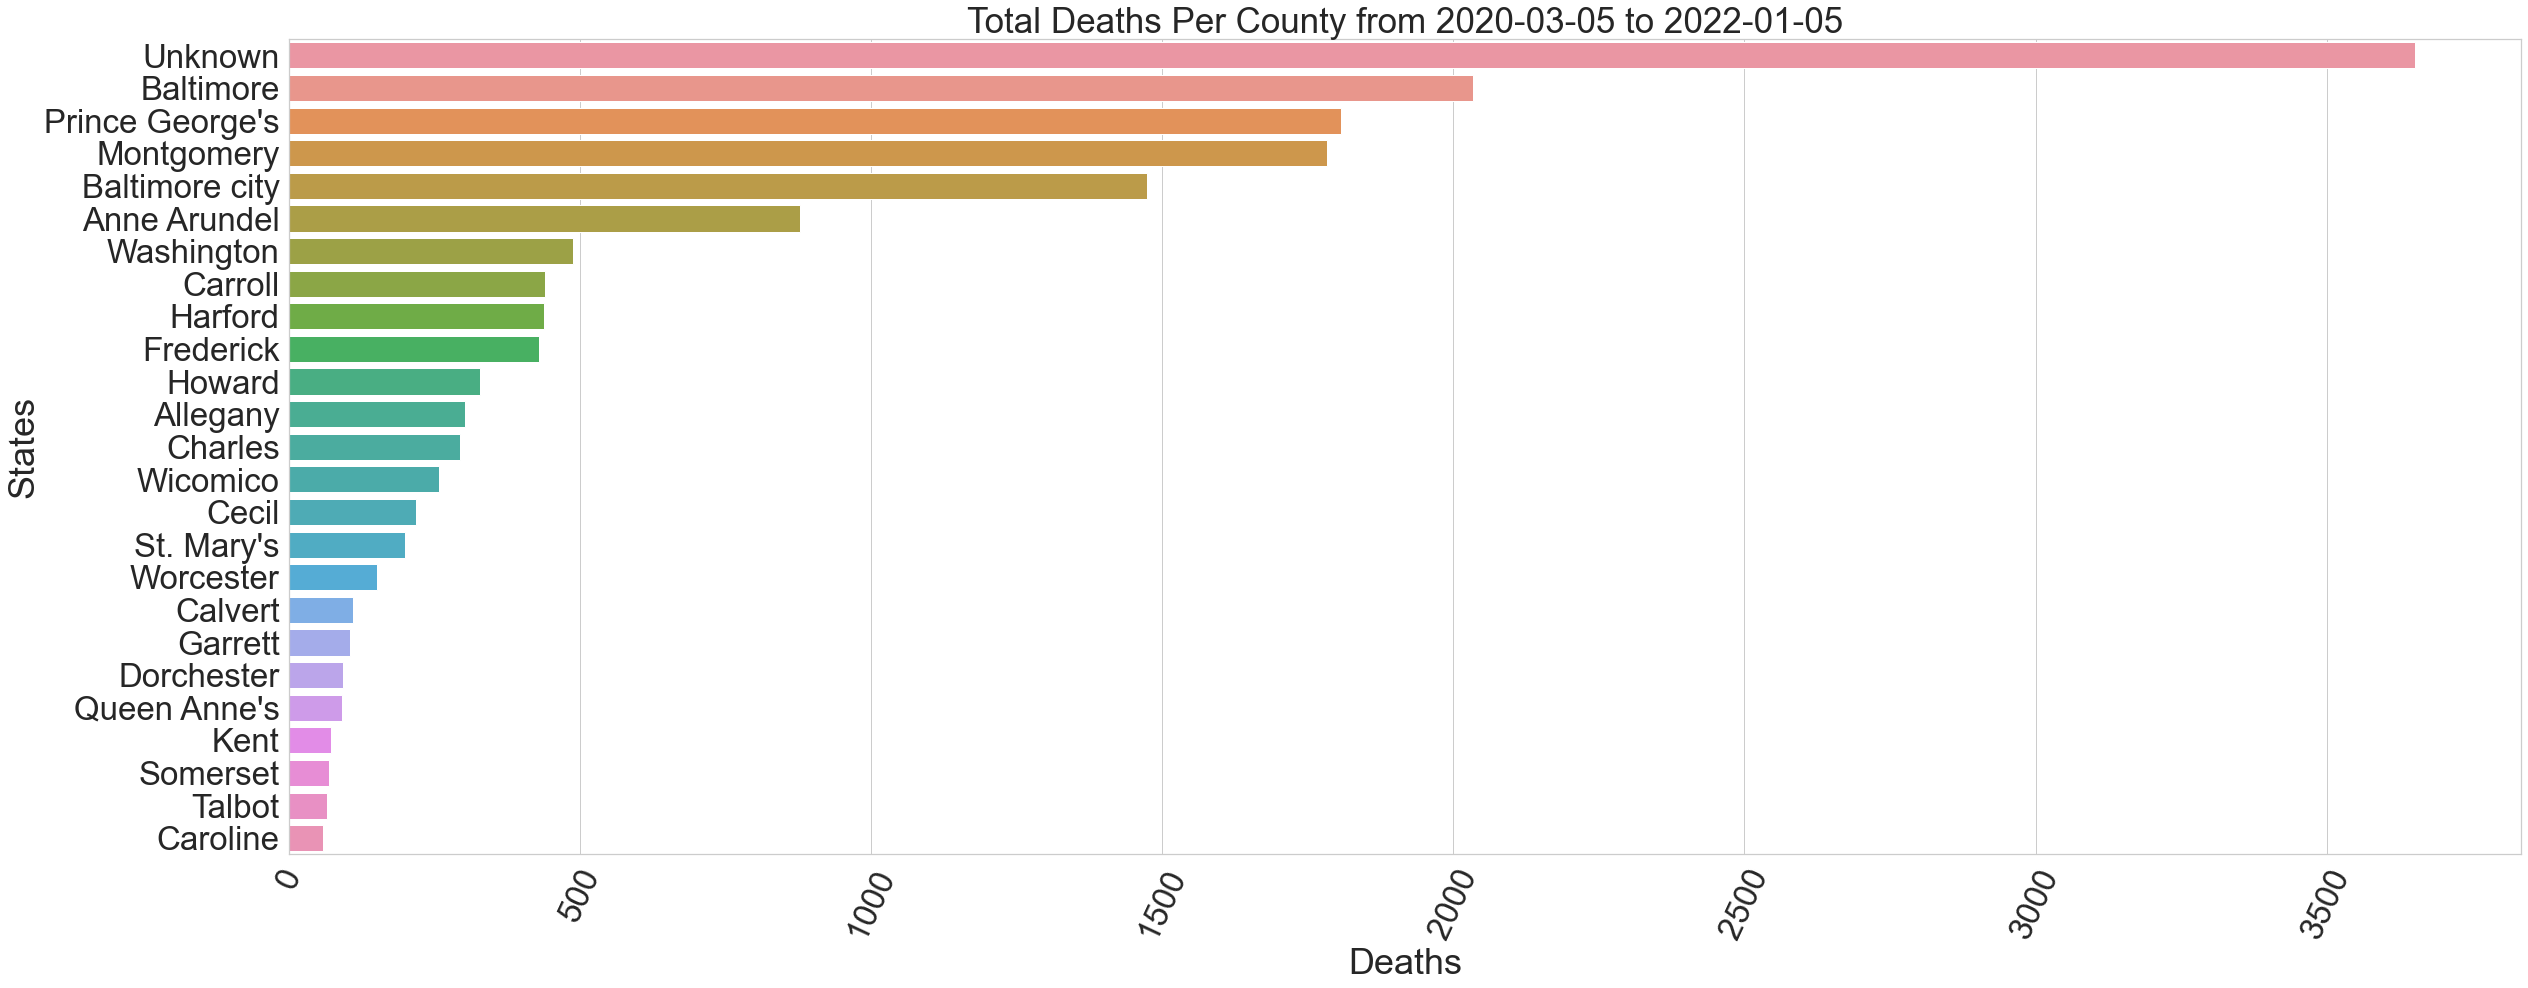

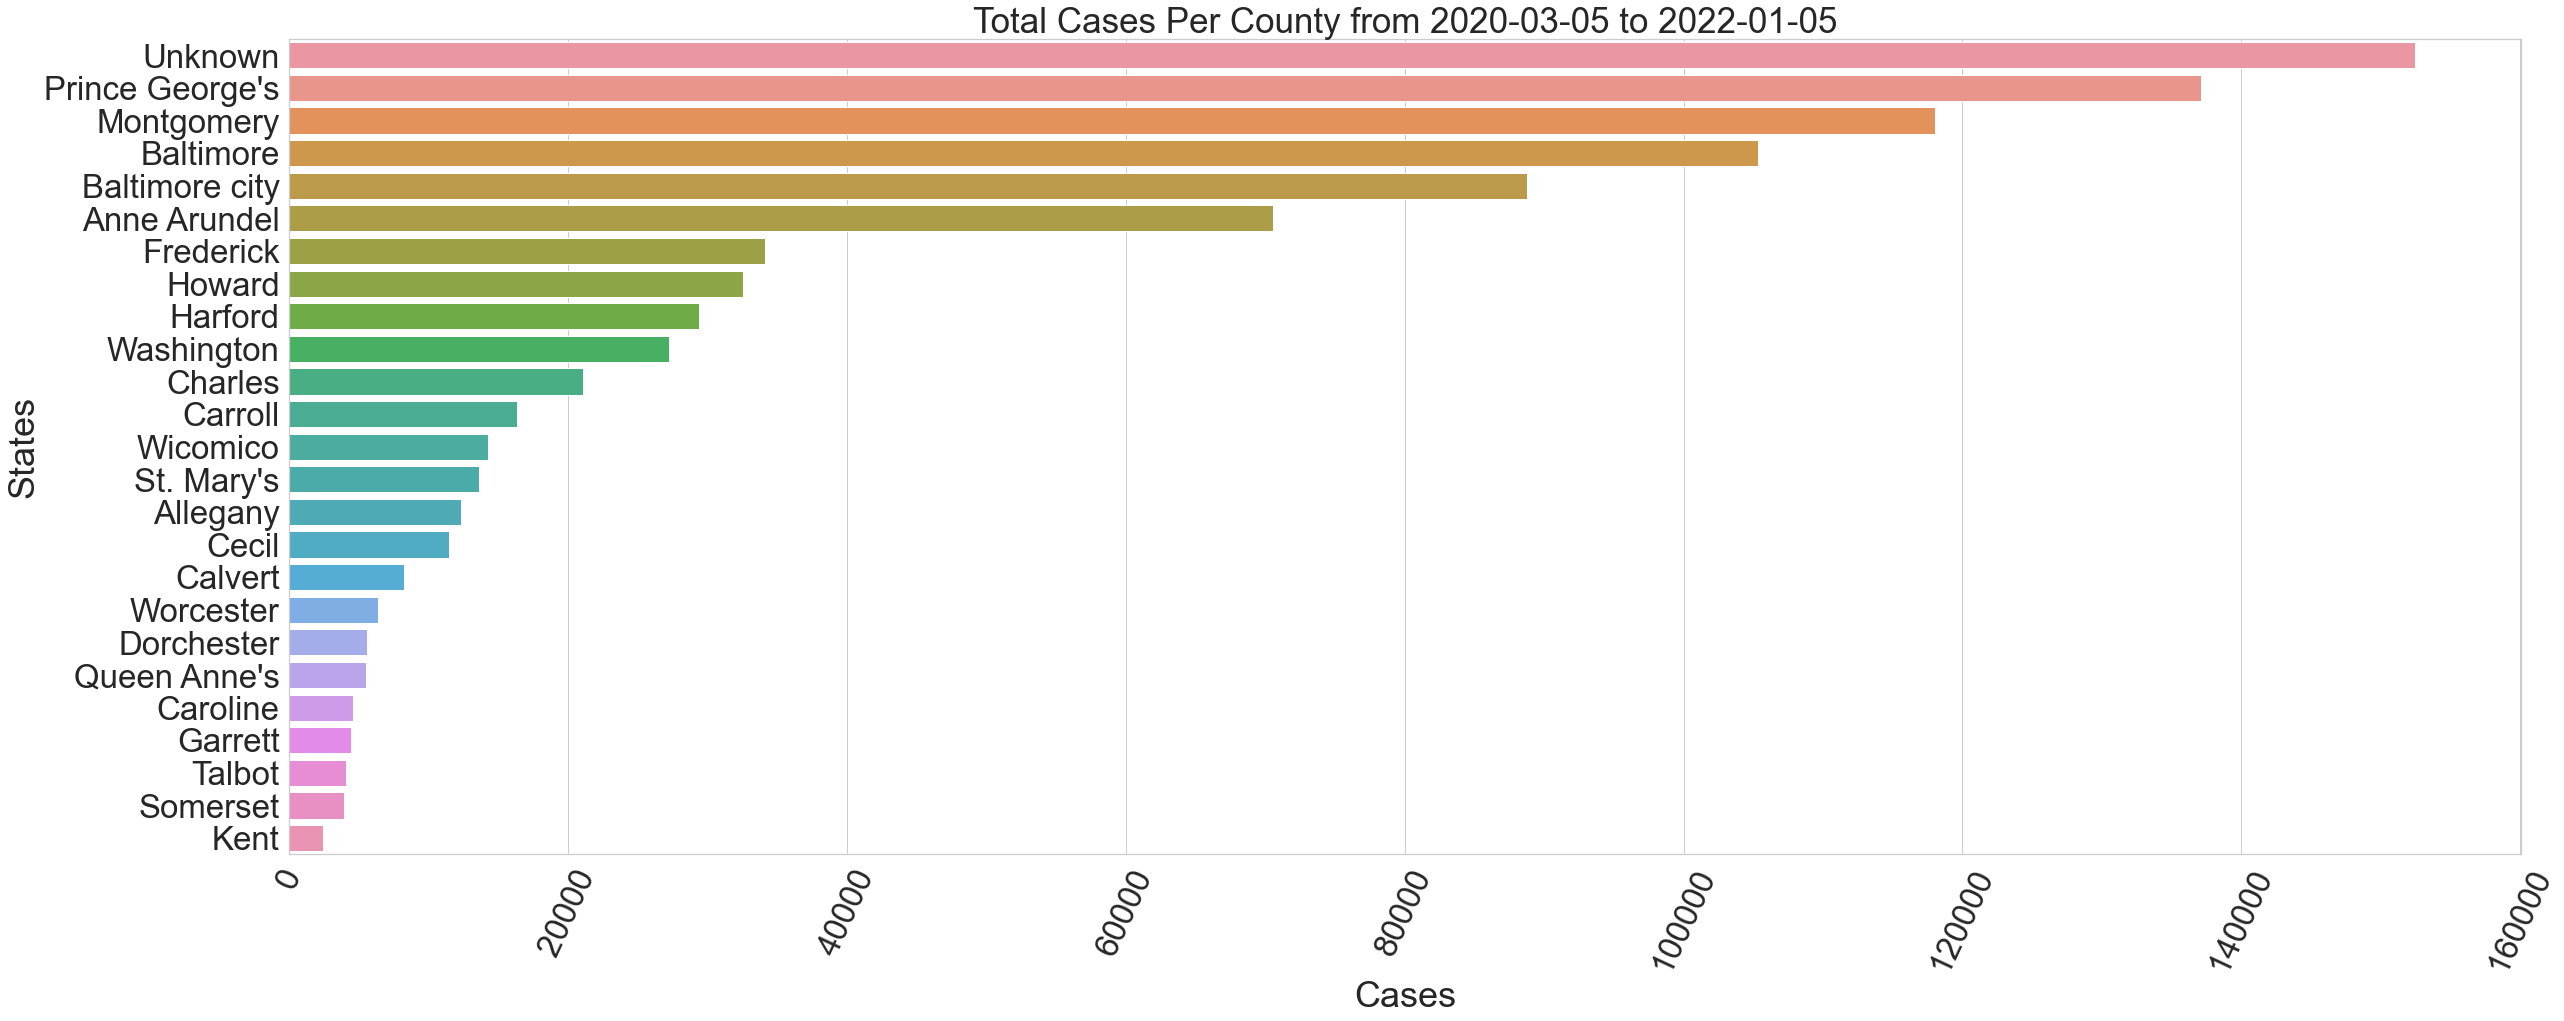

In [12]:
counties.countyOrder()

In [13]:
counties.get_counties(col="Montgomery")

IndexError: list index out of range

In [15]:
stats=Stats("us-states.csv","nst-est2020.csv","states-sqmi20.csv","https://data.cdc.gov/resource/unsk-b7fc.json","abbr.csv")

In [16]:
stats.loadData('Nevada',9,9)

date mmwr_week location distributed  \
0    2022-01-05T00:00:00.000         1       VA    16953825   
1    2022-01-05T00:00:00.000         1      BP2      300210   
2    2022-01-05T00:00:00.000         1       AK     1318725   
3    2022-01-05T00:00:00.000         1       MS     4586295   
4    2022-01-05T00:00:00.000         1       CA    76439625   
..                       ...       ...      ...         ...   
995  2021-12-21T00:00:00.000        51       NV     5007590   
996  2021-12-21T00:00:00.000        51      VA2     7528070   
997  2021-12-21T00:00:00.000        51       WI     9891405   
998  2021-12-21T00:00:00.000        51       VA    16614315   
999  2021-12-21T00:00:00.000        51       AK     1316925   

    distributed_janssen distributed_moderna distributed_pfizer  \
0                749800             5747420           10456605   
1                 16100              128500             155610   
2                 83100              496080             739545   
3                216100             1721400            2648795   
4               3540200            26847560           46051865   
..                  ...                 ...                ...   
995              249000             1705320            3053270   
996              615700             3671080            3241290   
997              445700             3649740            5795965   
998              745800             5721400           10147115   
999               82900              504300             729725   

    distributed_unk_manuf dist_per_100k distributed_per_100k_12plus  ...  \
0                       0        198627                      232023  ...   
1                       0             0                           0  ...   
2                       0        180266                      216583  ...   
3                       0        154102                      181893  ...   
4                       0        193458                      227186  ...   
..                    ...           ...                         ...  ...   
995                     0        162576                      190998  ...   
996                     0             0                           0  ...   
997                     0        169884                      197836  ...   
998                     0        194649                      227376  ...   
999                     0        180020                      216288  ...   

    administered_dose1_recip_5pluspop_pct series_complete_5plus  \
0                                    84.6               5827377   
1                                       0                128613   
2                                    70.2                413399   
3                                    59.9               1450146   
4                                    88.7              26285921   
..                                    ...                   ...   
995                                  73.1               1725294   
996                                     0               2905712   
997                                  71.7               3582018   
998                                    83               5762978   
999                                  69.4                409437   

    series_complete_5pluspop_pct administered_5plus admin_per_100k_5plus  \
0                           72.6           14656043               182515   
1                              0             280272                    0   
2                           60.8            1031698               151617   
3                           51.9            3514753               125856   
4                           70.8           66667020               179558   
..                           ...                ...                  ...   
995                         59.6            4223865               145923   
996                            0            6854765                    0   
997                         65.2            8912692               162287

'State of Nevada'

'Average of 1,009.21 cases per day in 29.0 days, currently ranked #36 in the United States.'

'Average of 21.07 deaths per day in 29.0 days, currently ranked #24 in the United States.'

'Case Fatality Ratio from September 02 to September 30: 2.088%, currently ranked #6 in the United States.'

'Incidence Rate from September 02 to September 30: 932.587 per 100k, currently ranked #38 in the United States.'

'There have been 29,267 cases from September 02 To September 30, currently ranked #36 in the United States.'

'There have been 611 deaths from September 02 To September 30, currently ranked #24 in the United States.'

'Nevada is 54.98% fully vaccinated, currently ranked #36 in the United States.'

'Total population: 3,138,259, ranked #33 in the United States.'

'There are 28.59 people per square mile, ranked #43 in the United States.'

'Nevada has 110,572 total square miles, ranking #7 in the United States.'

'All Time Case Fatality Ratio: 1.629%, currently ranked #11 in the United States.'

'All Time Incidence Rate: 16,599.905 per 100k, currently ranked #39 in the United States.'

count     mean     std  min  25%     50%     75%     max
cases    29.0  1009.21  874.25  0.0  0.0  1072.0  1407.0  3193.0
deaths   29.0    21.07   15.49  0.0  0.0    26.0    33.0    44.0

Nevada statistics from September 02 to September 30.
Lowest recorded deaths:  0.0 on September 04
Lowest recorded deaths:  0.0 on September 05
Lowest recorded deaths:  0.0 on September 06
Lowest recorded deaths:  0.0 on September 11
Lowest recorded deaths:  0.0 on September 12
Lowest recorded deaths:  0.0 on September 18
Lowest recorded deaths:  0.0 on September 19
Lowest recorded deaths:  0.0 on September 25
Lowest recorded deaths:  0.0 on September 26
Highest recorded deaths:  44 on September 09
Nevada statistics from September 02 to September 30.
A total of 611 deaths over the last 29 days.
Average death rate:  21.07 per day.
Largest increase in deaths:  35.0.
Smallest rate of deaths: 0.0.
Largest drop in deaths: 32.0


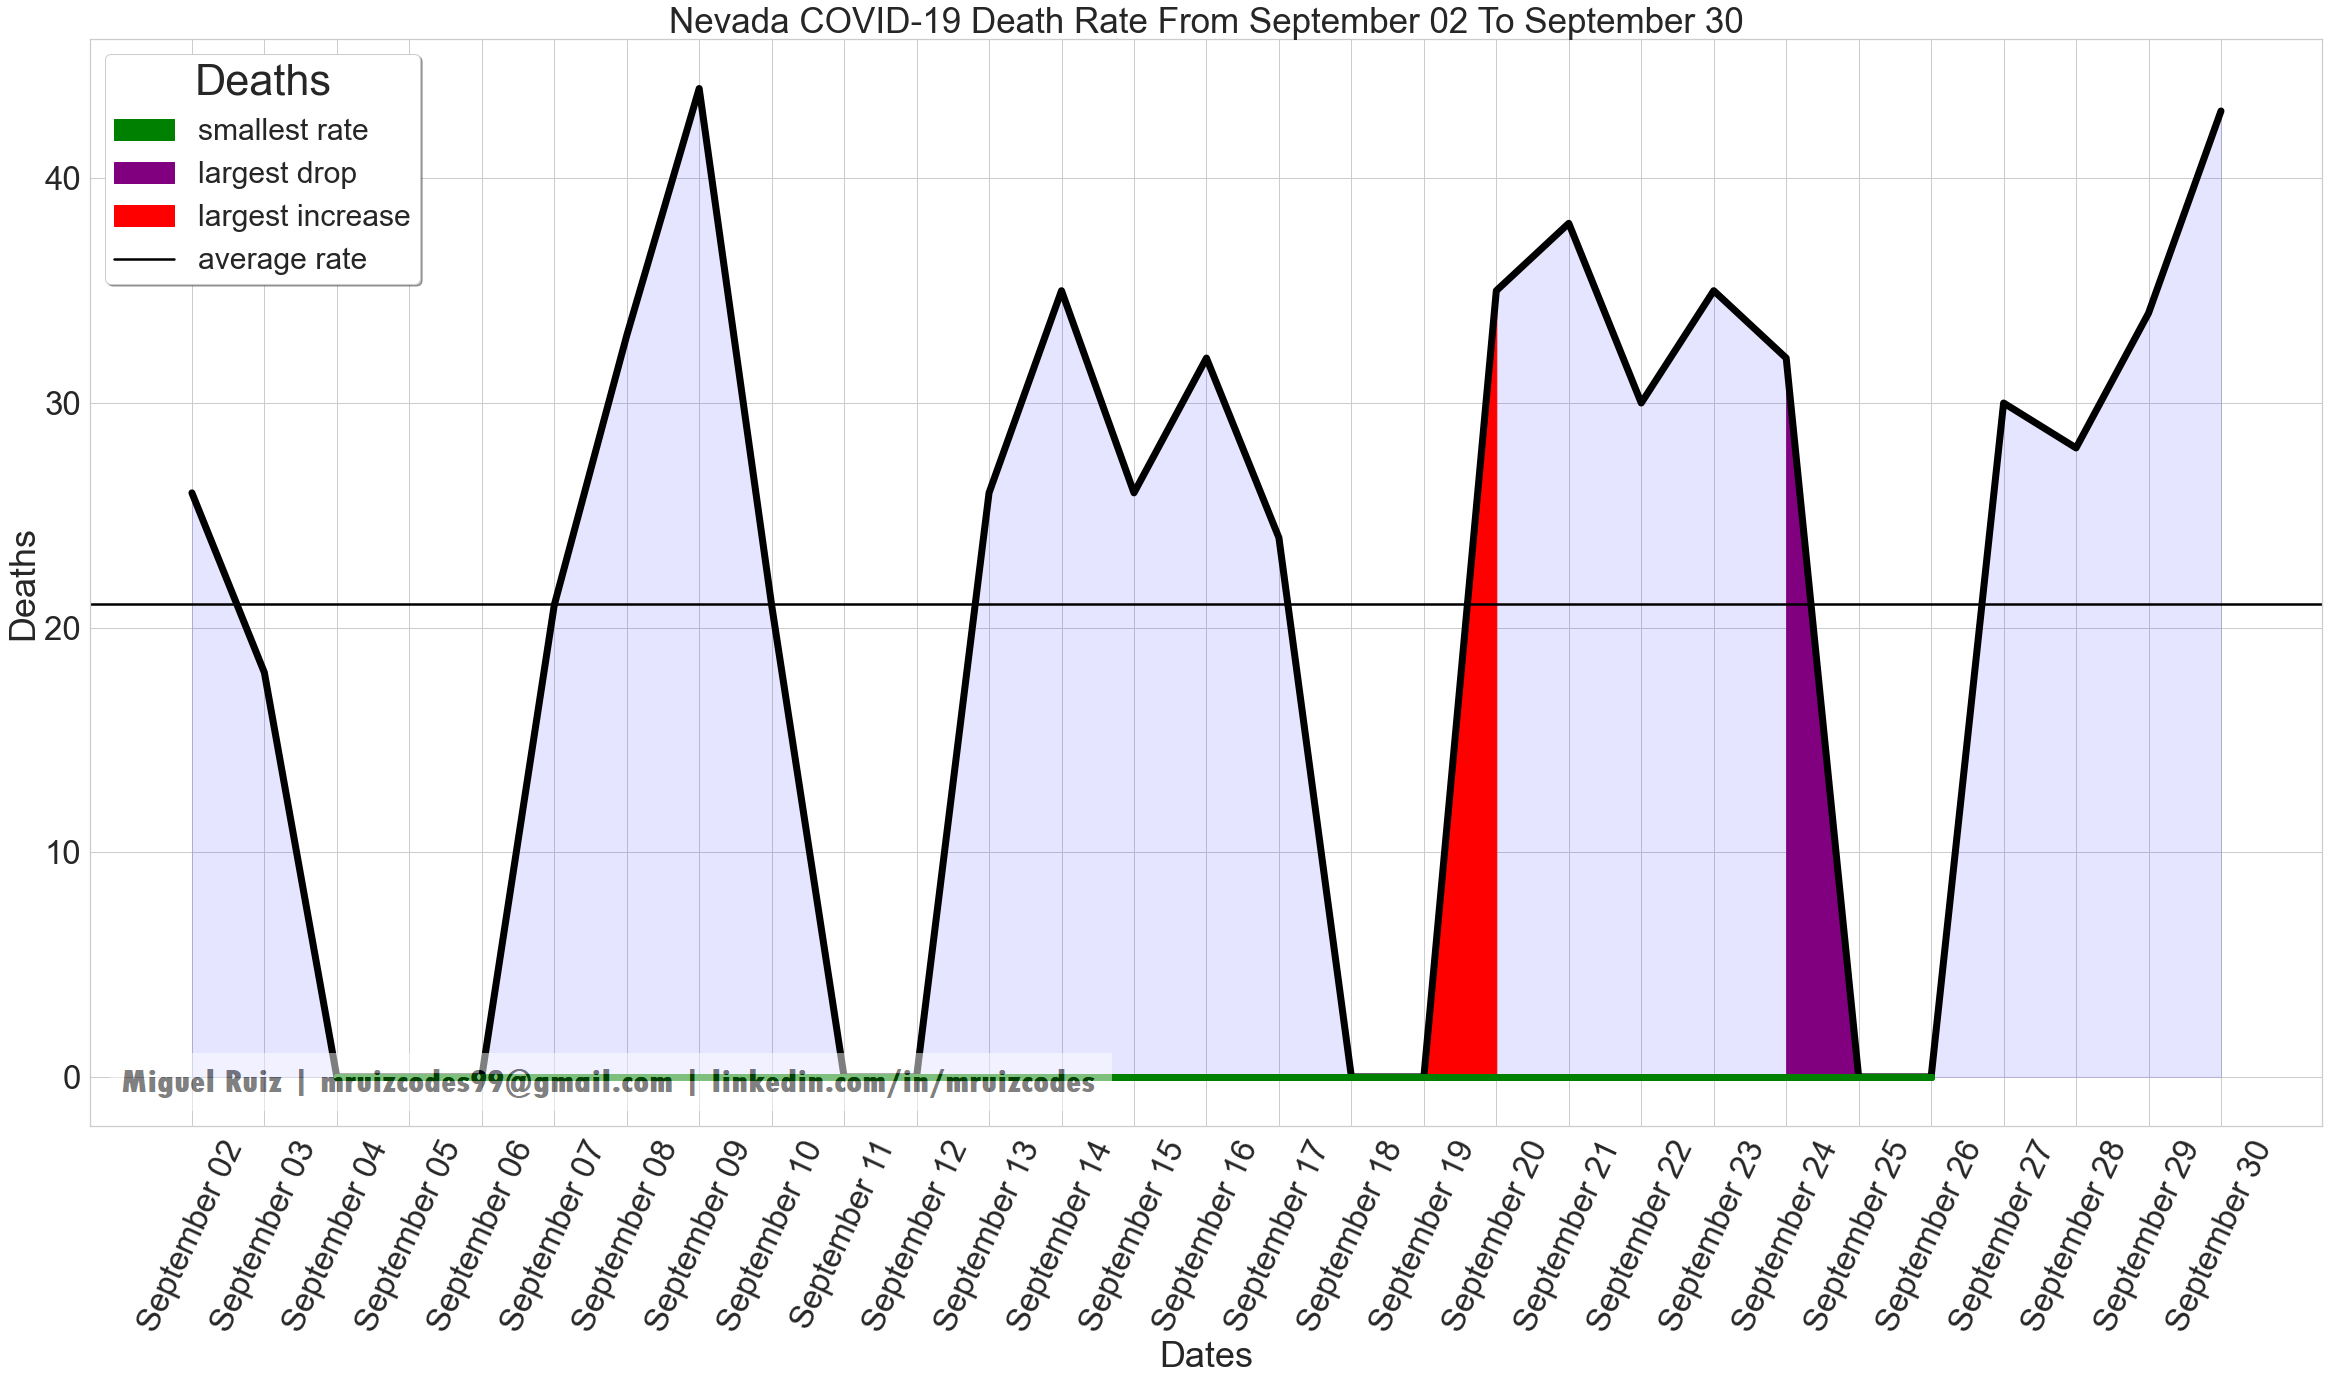

Nevada statistics from September 02 to September 30.
Lowest recorded cases:  0.0 on September 04
Lowest recorded cases:  0.0 on September 05
Lowest recorded cases:  0.0 on September 06
Lowest recorded cases:  0.0 on September 11
Lowest recorded cases:  0.0 on September 12
Lowest recorded cases:  0.0 on September 18
Lowest recorded cases:  0.0 on September 19
Lowest recorded cases:  0.0 on September 25
Lowest recorded cases:  0.0 on September 26
Highest recorded cases:  3,193 on September 07
Nevada statistics from September 02 to September 30.
A total of 29,267 cases over the last 29 days.
Average case rate:  1,009.21 per day.
Largest increase in cases:  3,193.0.
Smallest rate of cases: 0.0.
Largest drop in cases: 1,747.0


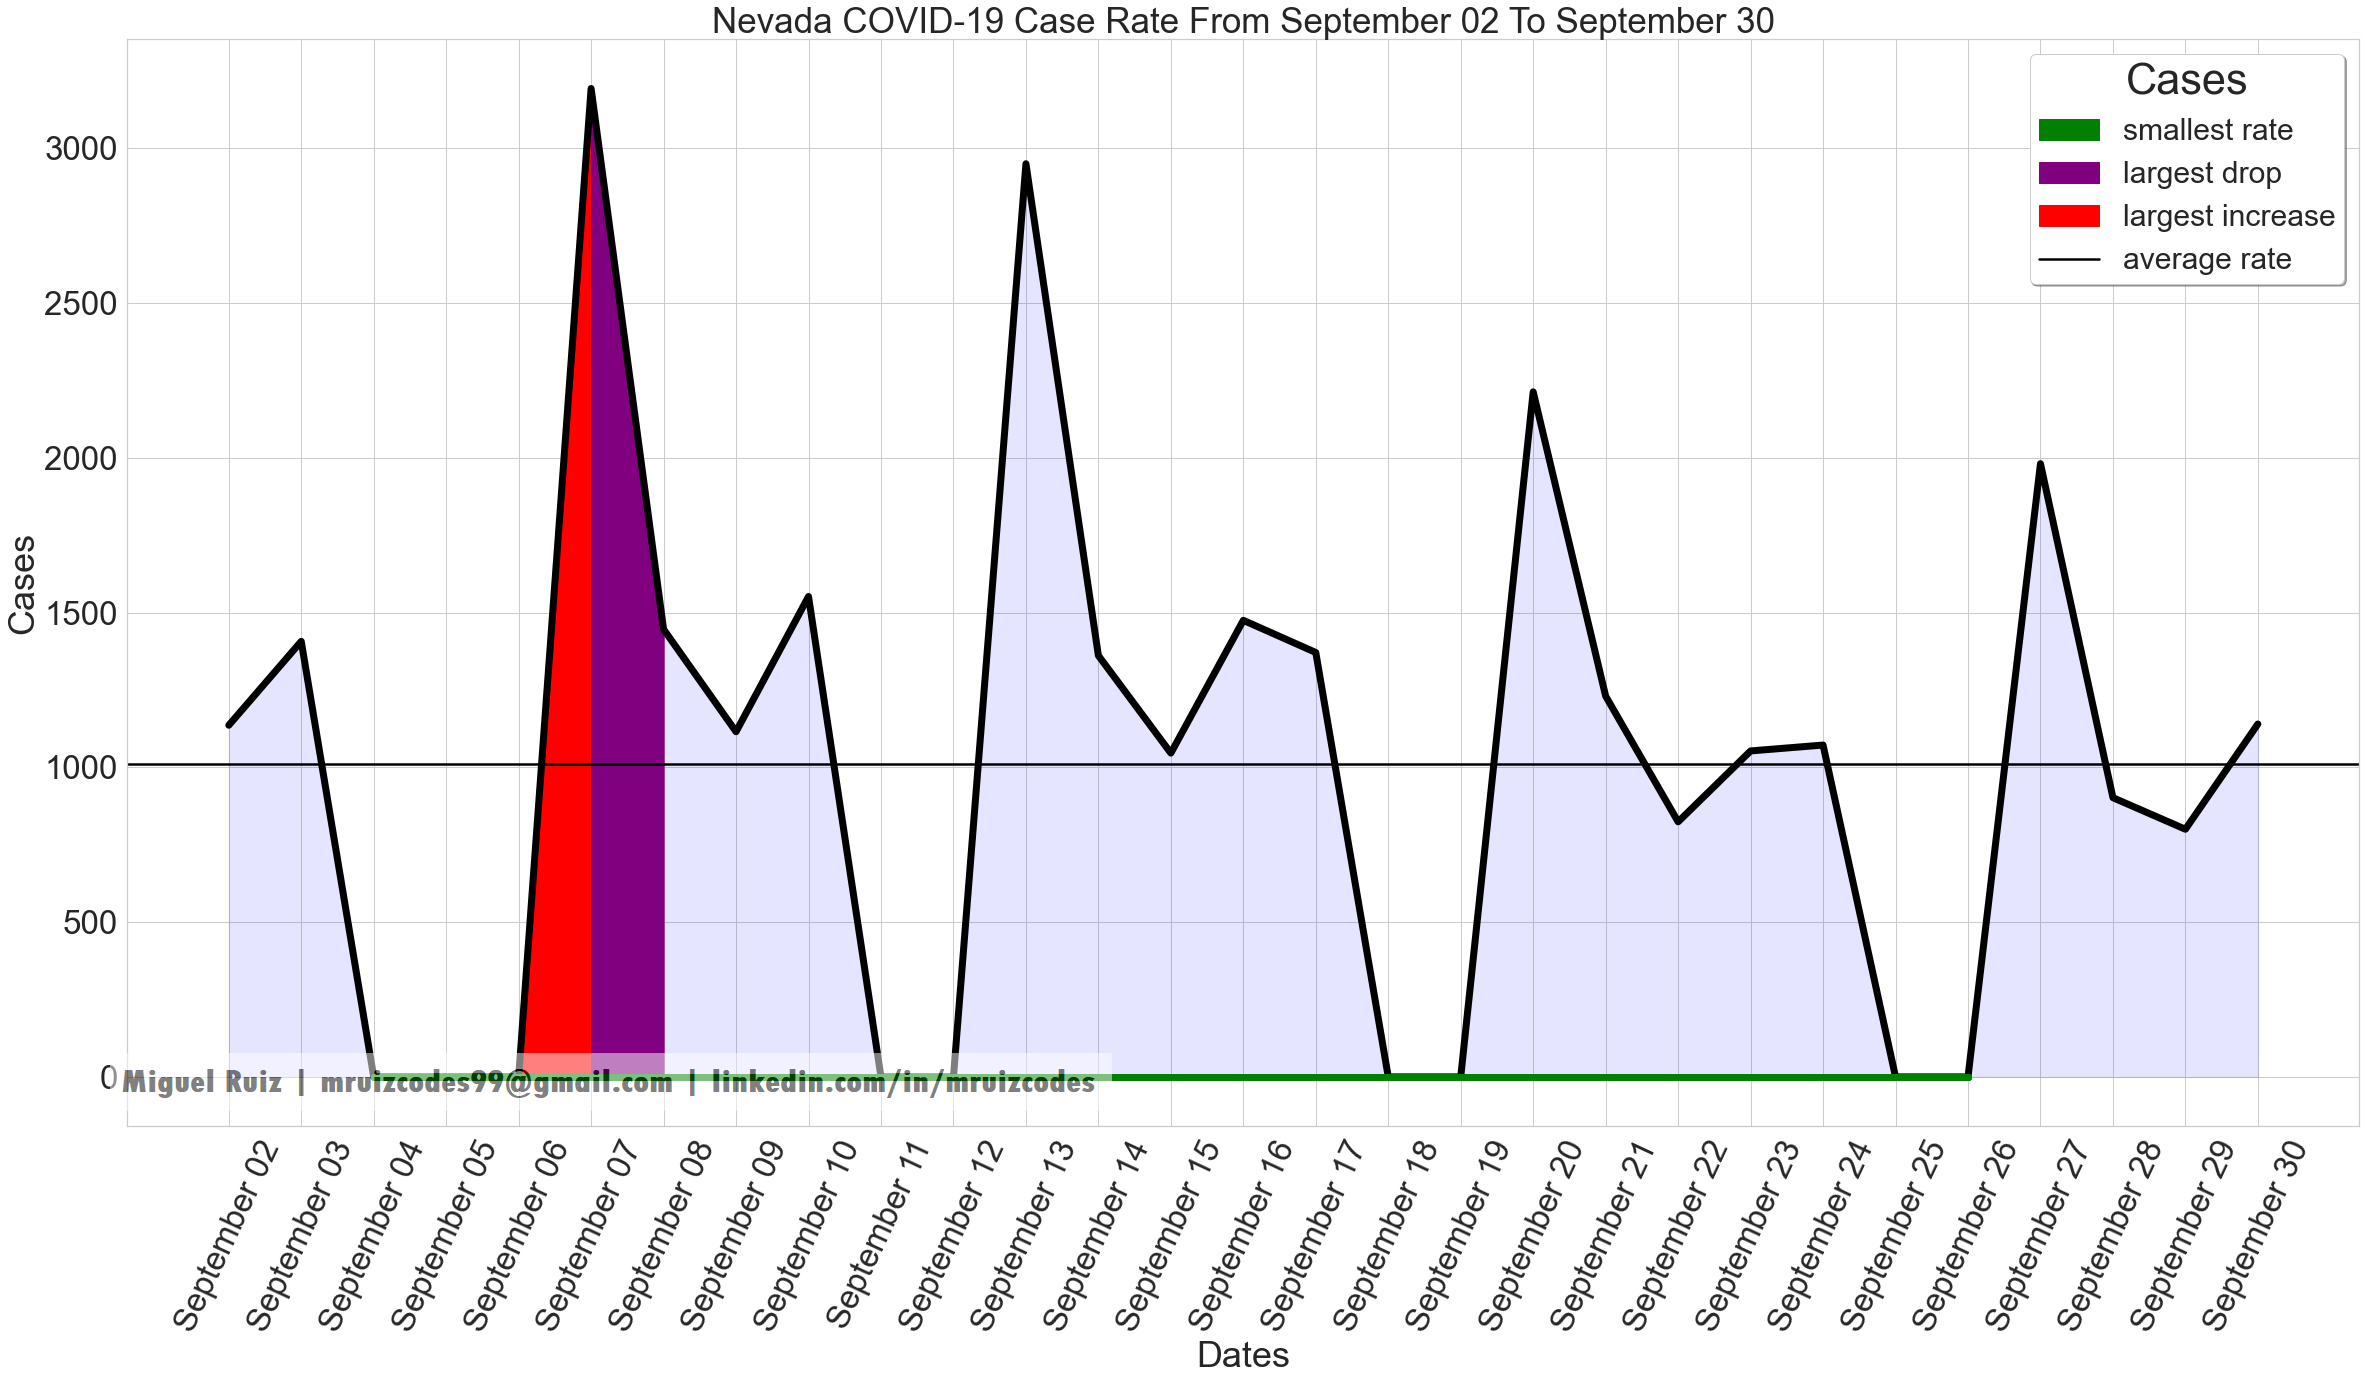

In [17]:
monthgraph=stats.graph(stats.finalDF)

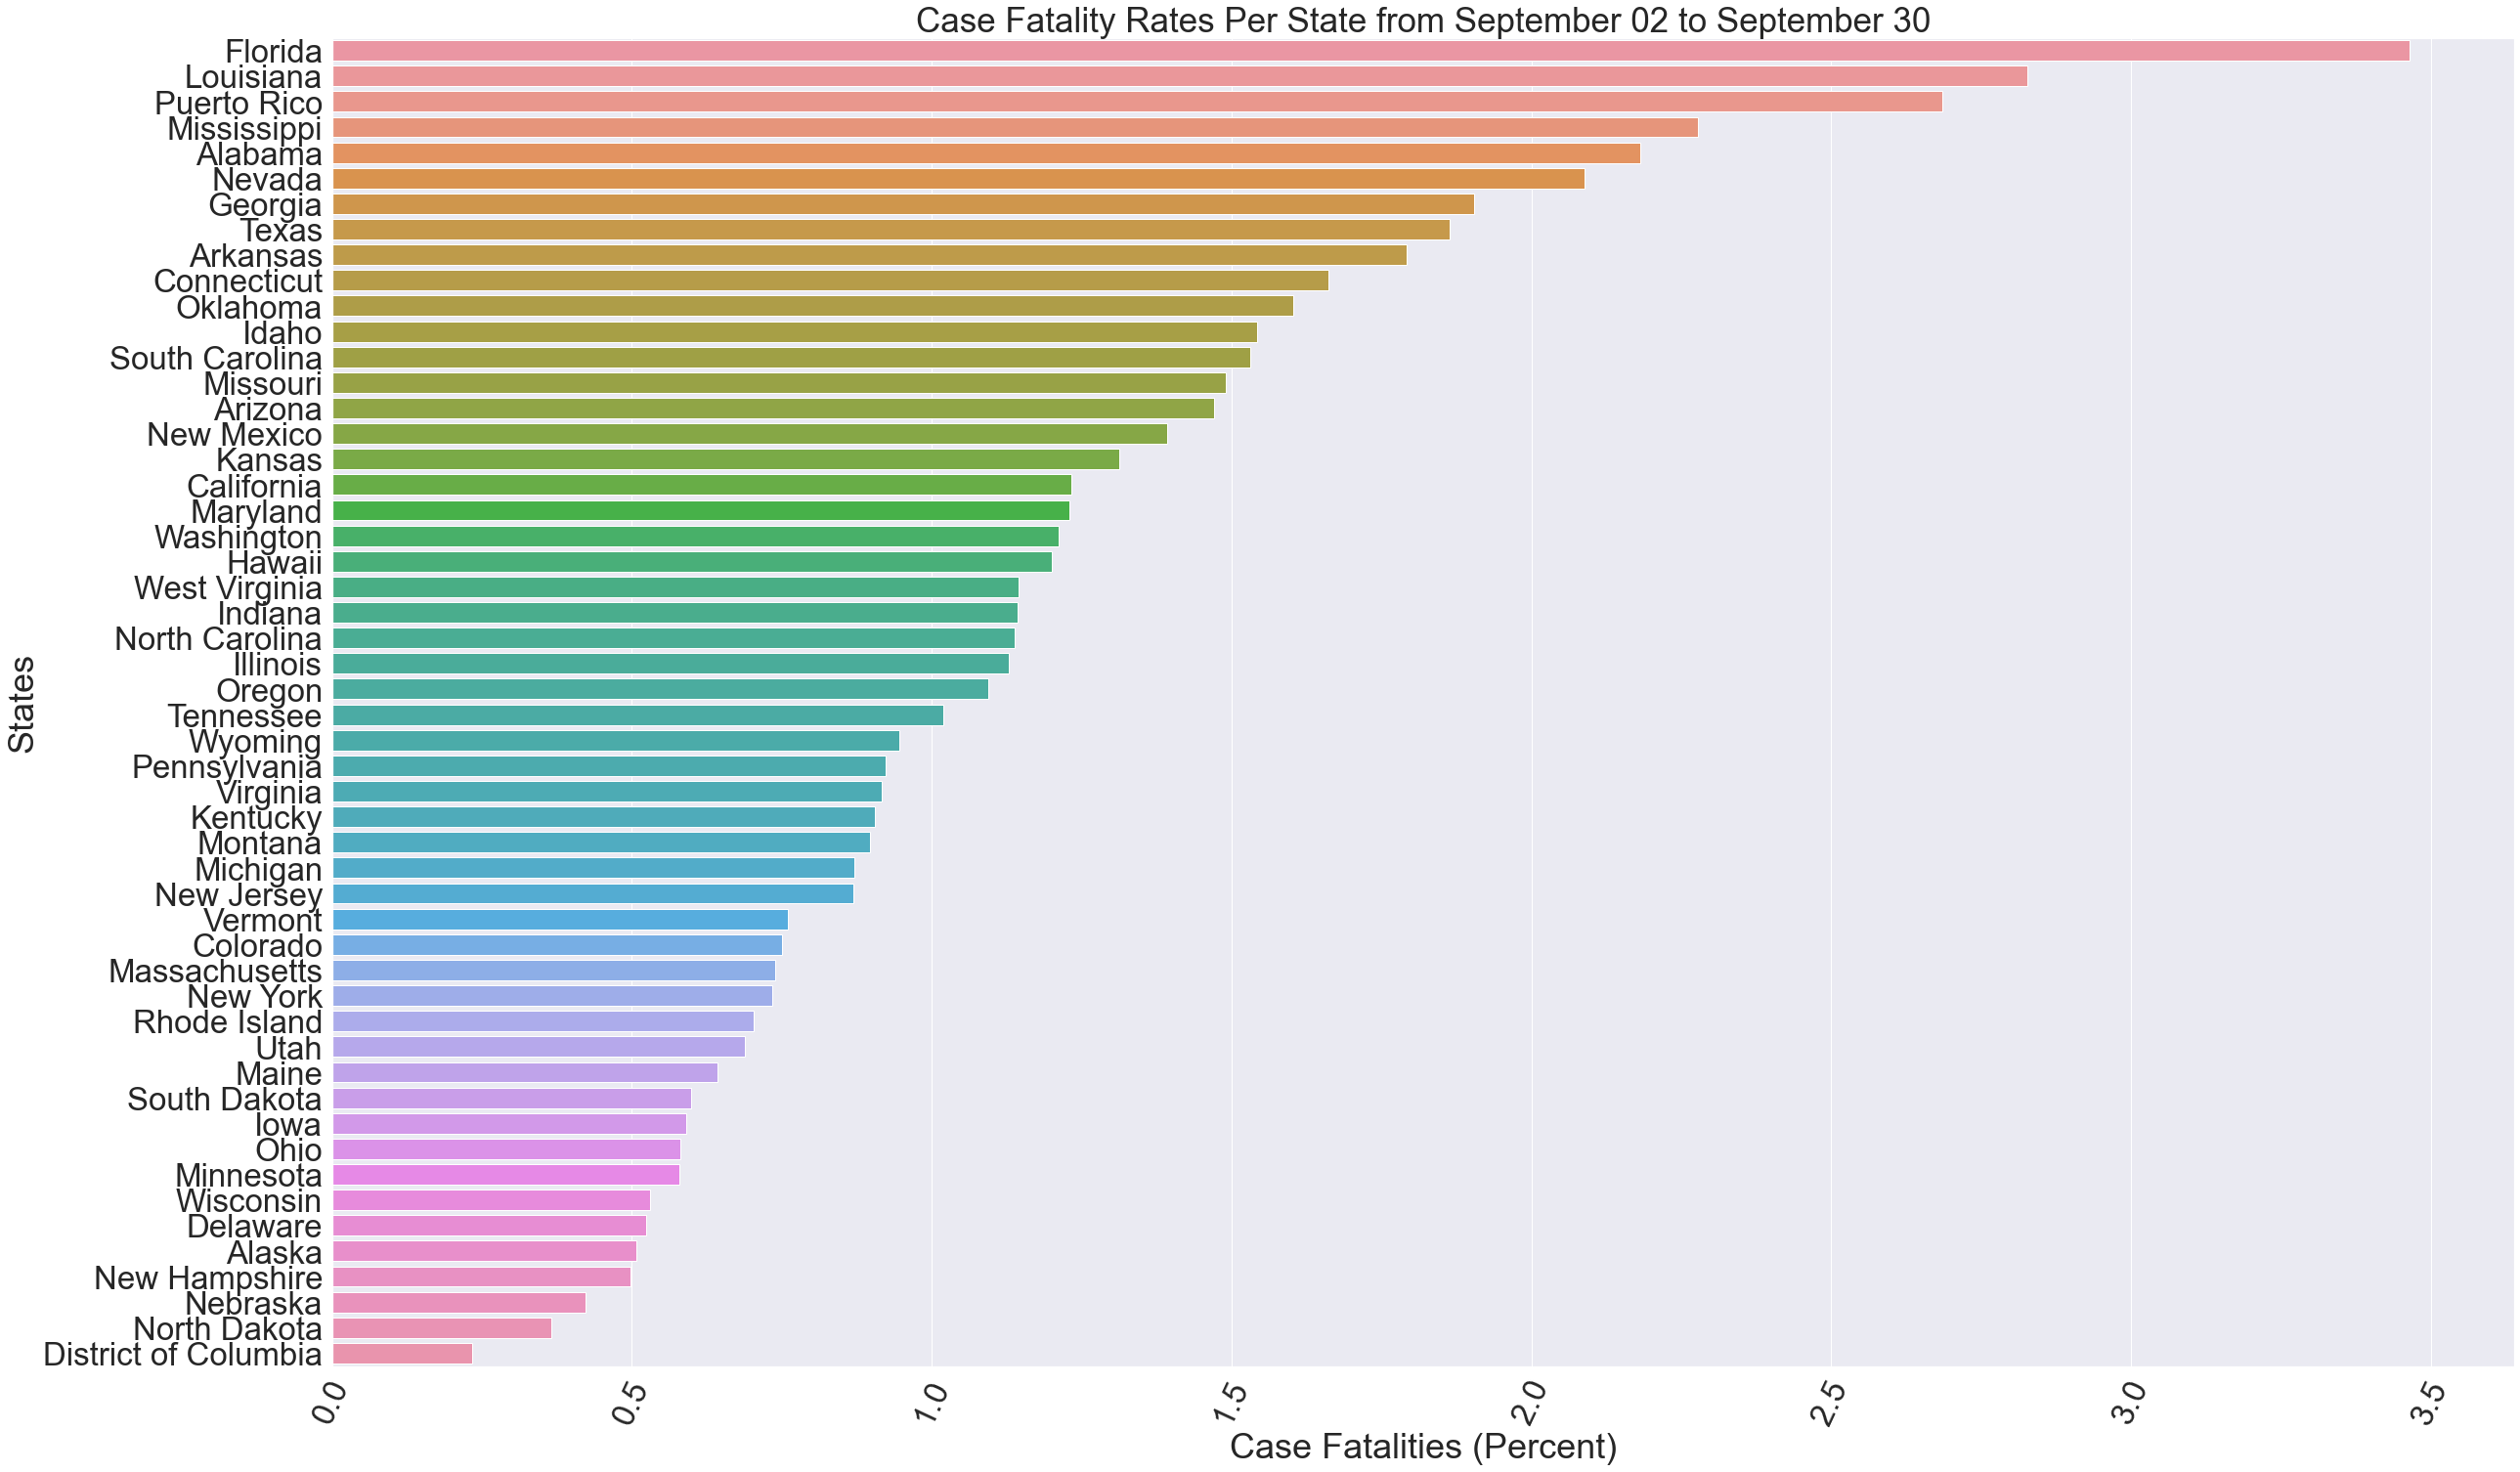

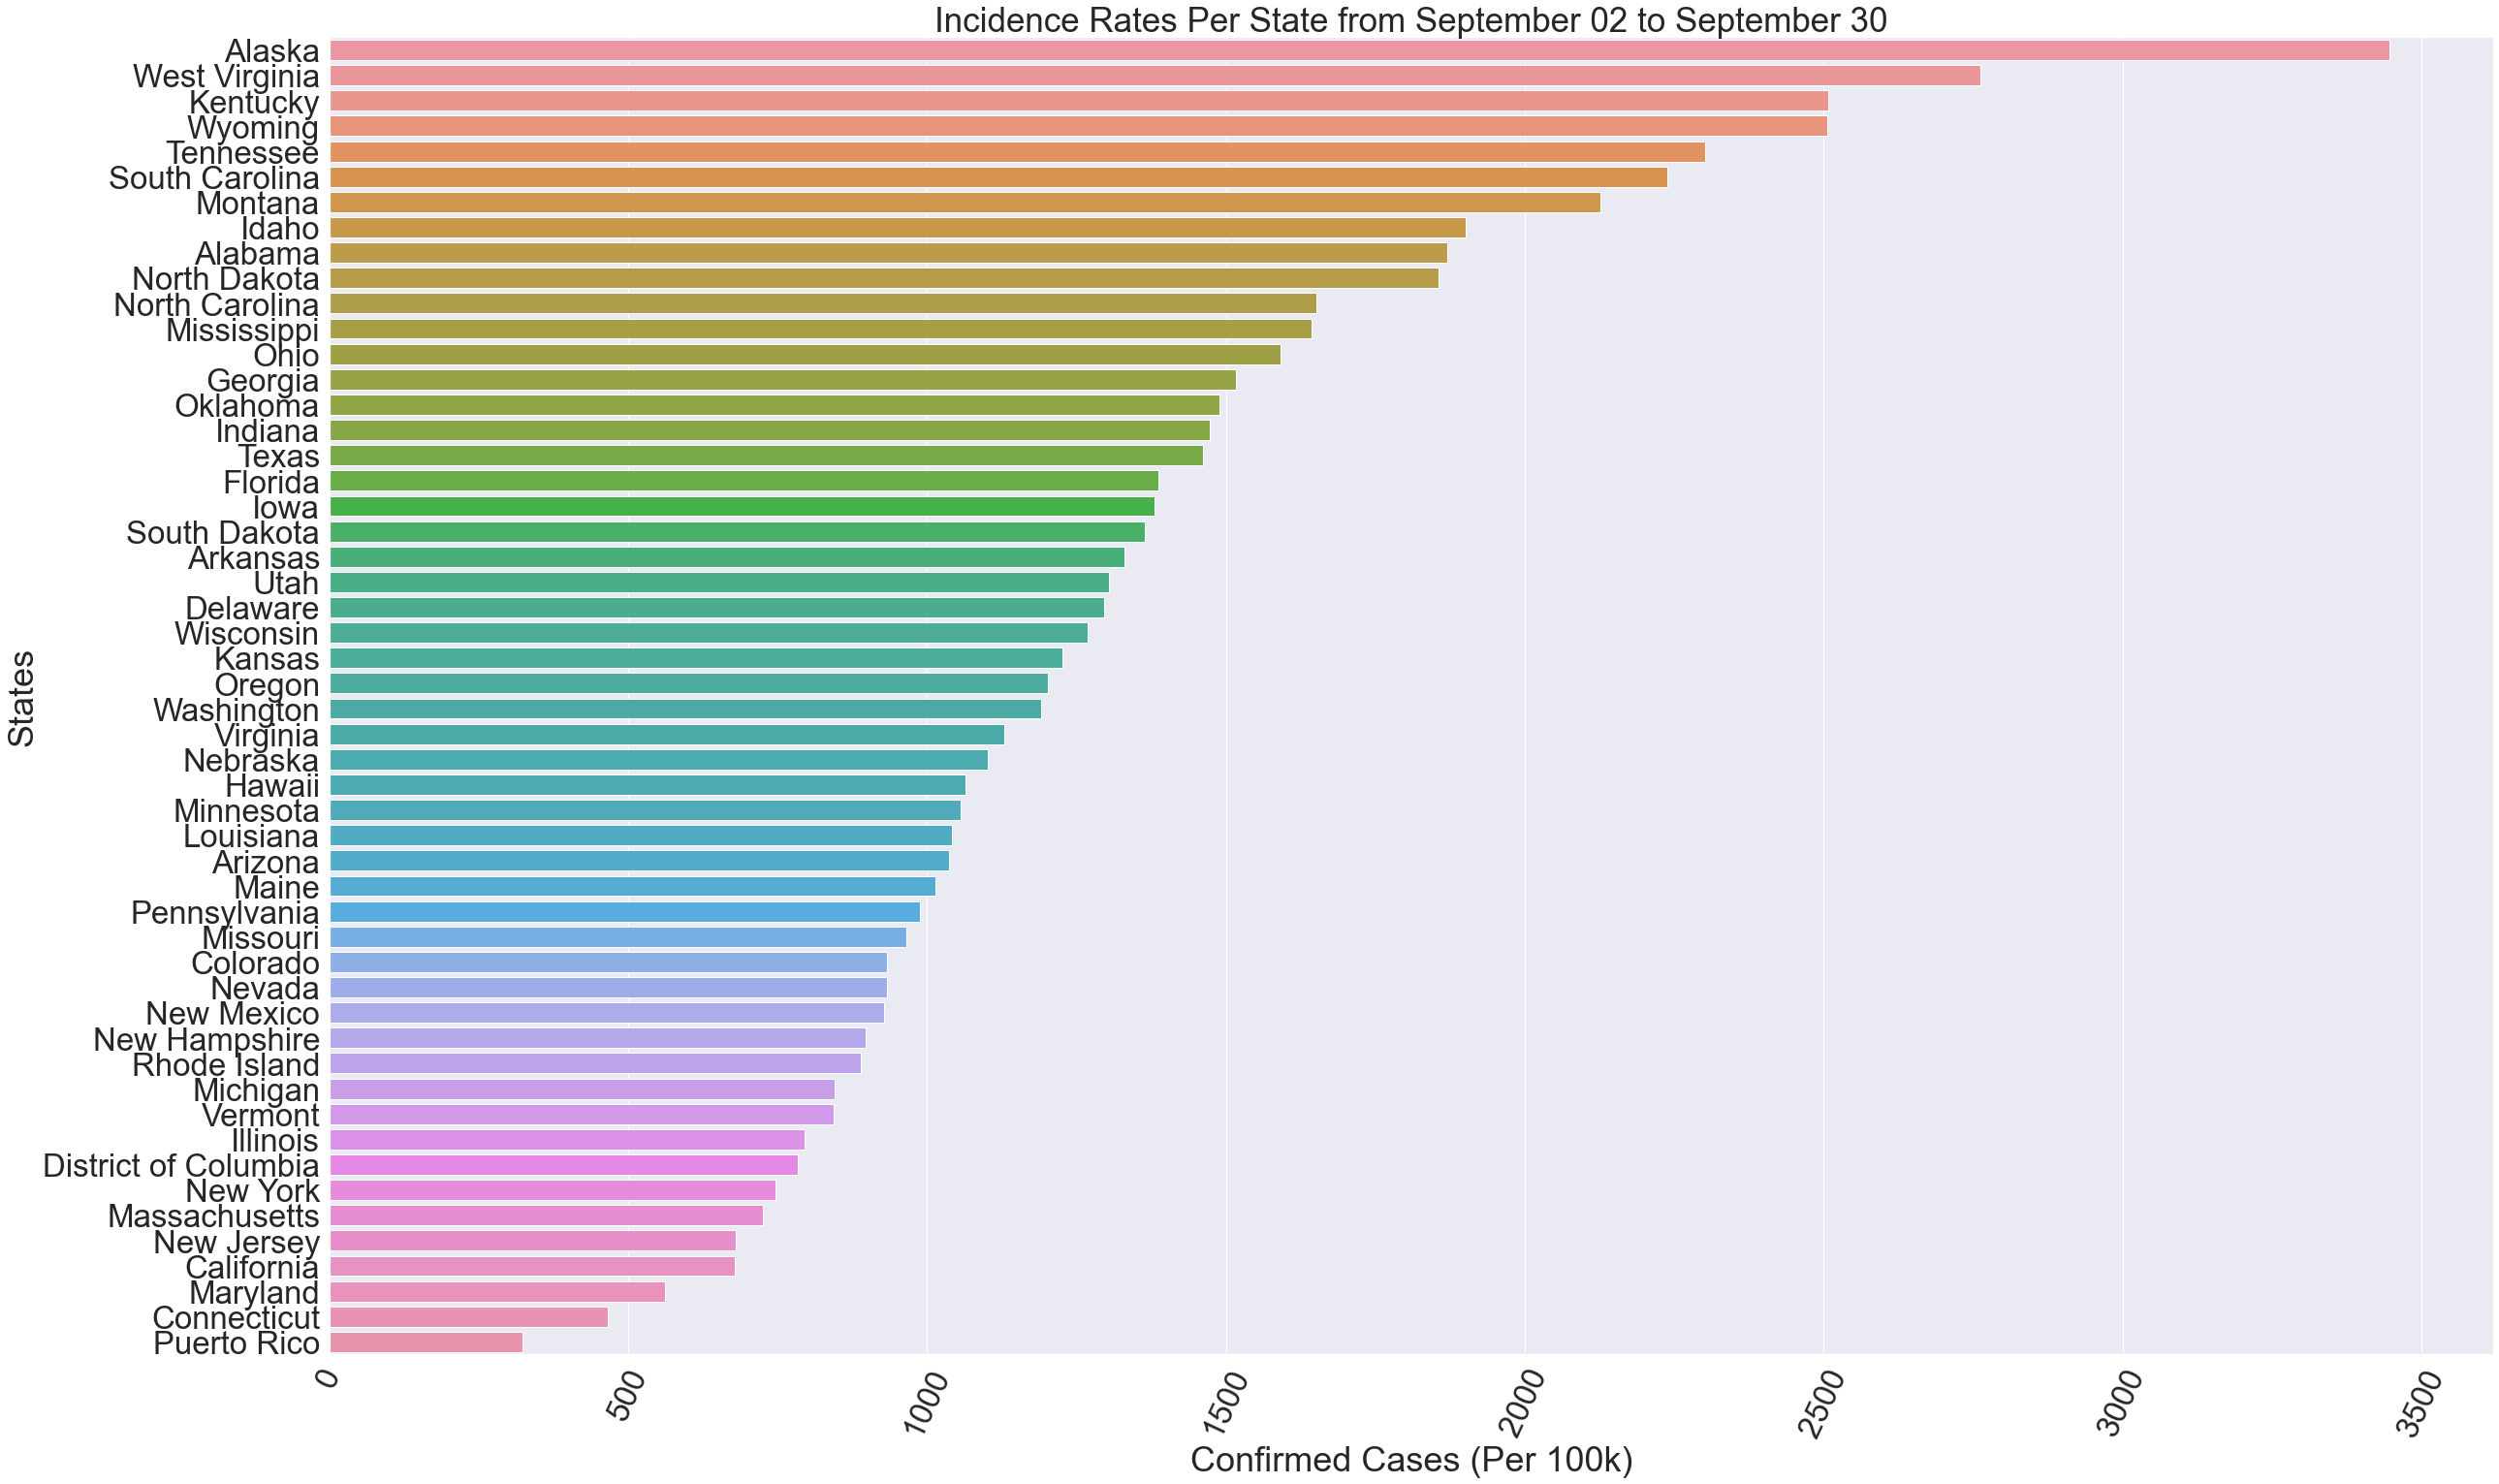

In [18]:
cfr=stats.graph(stats.cfrDF)
ir=stats.graph(stats.irDF)

['avg_cases',
 'avg_deaths',
 'total_cases',
 'total_deaths',
 'curr_pop',
 'percent']

date mmwr_week location distributed  \
0    2022-01-05T00:00:00.000         1       VA    16953825   
1    2022-01-05T00:00:00.000         1      BP2      300210   
2    2022-01-05T00:00:00.000         1       AK     1318725   
3    2022-01-05T00:00:00.000         1       MS     4586295   
4    2022-01-05T00:00:00.000         1       CA    76439625   
..                       ...       ...      ...         ...   
995  2021-12-21T00:00:00.000        51       NV     5007590   
996  2021-12-21T00:00:00.000        51      VA2     7528070   
997  2021-12-21T00:00:00.000        51       WI     9891405   
998  2021-12-21T00:00:00.000        51       VA    16614315   
999  2021-12-21T00:00:00.000        51       AK     1316925   

    distributed_janssen distributed_moderna distributed_pfizer  \
0                749800             5747420           10456605   
1                 16100              128500             155610   
2                 83100              496080             739545   
3                216100             1721400            2648795   
4               3540200            26847560           46051865   
..                  ...                 ...                ...   
995              249000             1705320            3053270   
996              615700             3671080            3241290   
997              445700             3649740            5795965   
998              745800             5721400           10147115   
999               82900              504300             729725   

    distributed_unk_manuf dist_per_100k distributed_per_100k_12plus  ...  \
0                       0        198627                      232023  ...   
1                       0             0                           0  ...   
2                       0        180266                      216583  ...   
3                       0        154102                      181893  ...   
4                       0        193458                      227186  ...   
..                    ...           ...                         ...  ...   
995                     0        162576                      190998  ...   
996                     0             0                           0  ...   
997                     0        169884                      197836  ...   
998                     0        194649                      227376  ...   
999                     0        180020                      216288  ...   

    administered_dose1_recip_5pluspop_pct series_complete_5plus  \
0                                    84.6               5827377   
1                                       0                128613   
2                                    70.2                413399   
3                                    59.9               1450146   
4                                    88.7              26285921   
..                                    ...                   ...   
995                                  73.1               1725294   
996                                     0               2905712   
997                                  71.7               3582018   
998                                    83               5762978   
999                                  69.4                409437   

    series_complete_5pluspop_pct administered_5plus admin_per_100k_5plus  \
0                           72.6           14656043               182515   
1                              0             280272                    0   
2                           60.8            1031698               151617   
3                           51.9            3514753               125856   
4                           70.8           66667020               179558   
..                           ...                ...                  ...   
995                         59.6            4223865               145923   
996                            0            6854765                    0   
997                         65.2            8912692               162287

date mmwr_week location distributed  \
0    2022-01-05T00:00:00.000         1       VA    16953825   
1    2022-01-05T00:00:00.000         1      BP2      300210   
2    2022-01-05T00:00:00.000         1       AK     1318725   
3    2022-01-05T00:00:00.000         1       MS     4586295   
4    2022-01-05T00:00:00.000         1       CA    76439625   
..                       ...       ...      ...         ...   
995  2021-12-21T00:00:00.000        51       NV     5007590   
996  2021-12-21T00:00:00.000        51      VA2     7528070   
997  2021-12-21T00:00:00.000        51       WI     9891405   
998  2021-12-21T00:00:00.000        51       VA    16614315   
999  2021-12-21T00:00:00.000        51       AK     1316925   

    distributed_janssen distributed_moderna distributed_pfizer  \
0                749800             5747420           10456605   
1                 16100              128500             155610   
2                 83100              496080             739545   
3                216100             1721400            2648795   
4               3540200            26847560           46051865   
..                  ...                 ...                ...   
995              249000             1705320            3053270   
996              615700             3671080            3241290   
997              445700             3649740            5795965   
998              745800             5721400           10147115   
999               82900              504300             729725   

    distributed_unk_manuf dist_per_100k distributed_per_100k_12plus  ...  \
0                       0        198627                      232023  ...   
1                       0             0                           0  ...   
2                       0        180266                      216583  ...   
3                       0        154102                      181893  ...   
4                       0        193458                      227186  ...   
..                    ...           ...                         ...  ...   
995                     0        162576                      190998  ...   
996                     0             0                           0  ...   
997                     0        169884                      197836  ...   
998                     0        194649                      227376  ...   
999                     0        180020                      216288  ...   

    administered_dose1_recip_5pluspop_pct series_complete_5plus  \
0                                    84.6               5827377   
1                                       0                128613   
2                                    70.2                413399   
3                                    59.9               1450146   
4                                    88.7              26285921   
..                                    ...                   ...   
995                                  73.1               1725294   
996                                     0               2905712   
997                                  71.7               3582018   
998                                    83               5762978   
999                                  69.4                409437   

    series_complete_5pluspop_pct administered_5plus admin_per_100k_5plus  \
0                           72.6           14656043               182515   
1                              0             280272                    0   
2                           60.8            1031698               151617   
3                           51.9            3514753               125856   
4                           70.8           66667020               179558   
..                           ...                ...                  ...   
995                         59.6            4223865               145923   
996                            0            6854765                    0   
997                         65.2            8912692               162287

The United States is %60.95 fully vaccinated.


<Figure size 2880x1800 with 0 Axes>

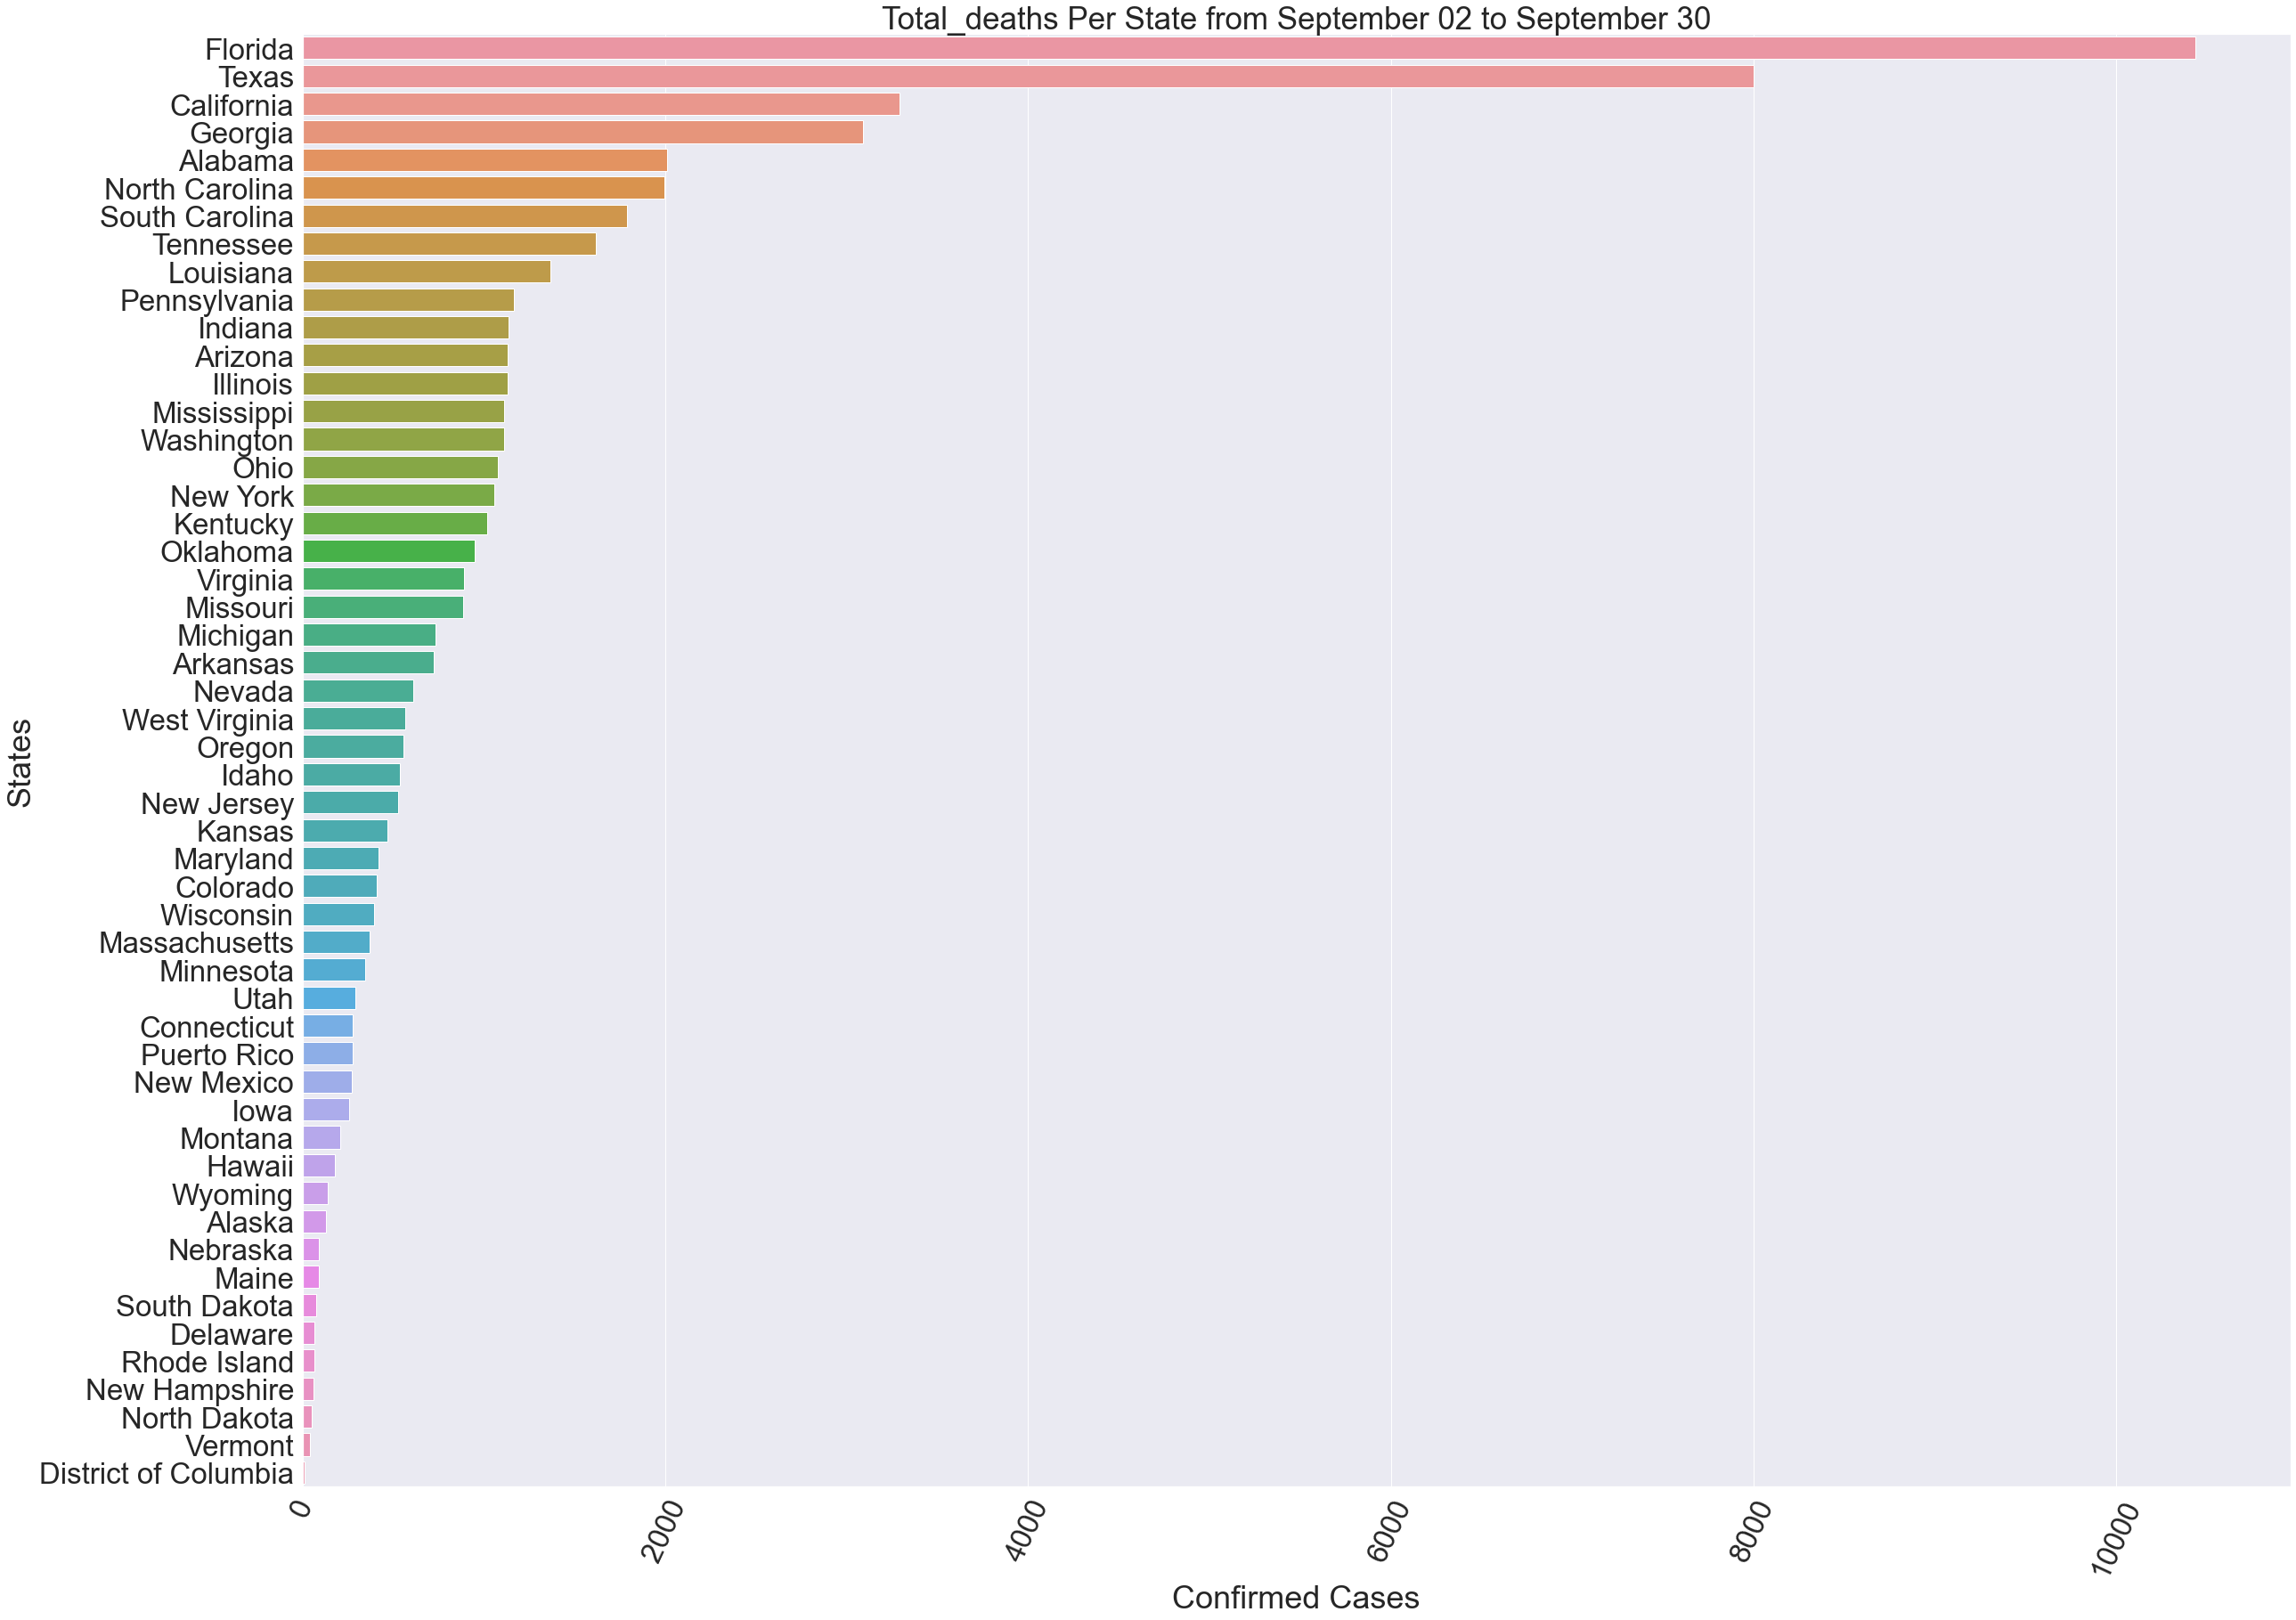

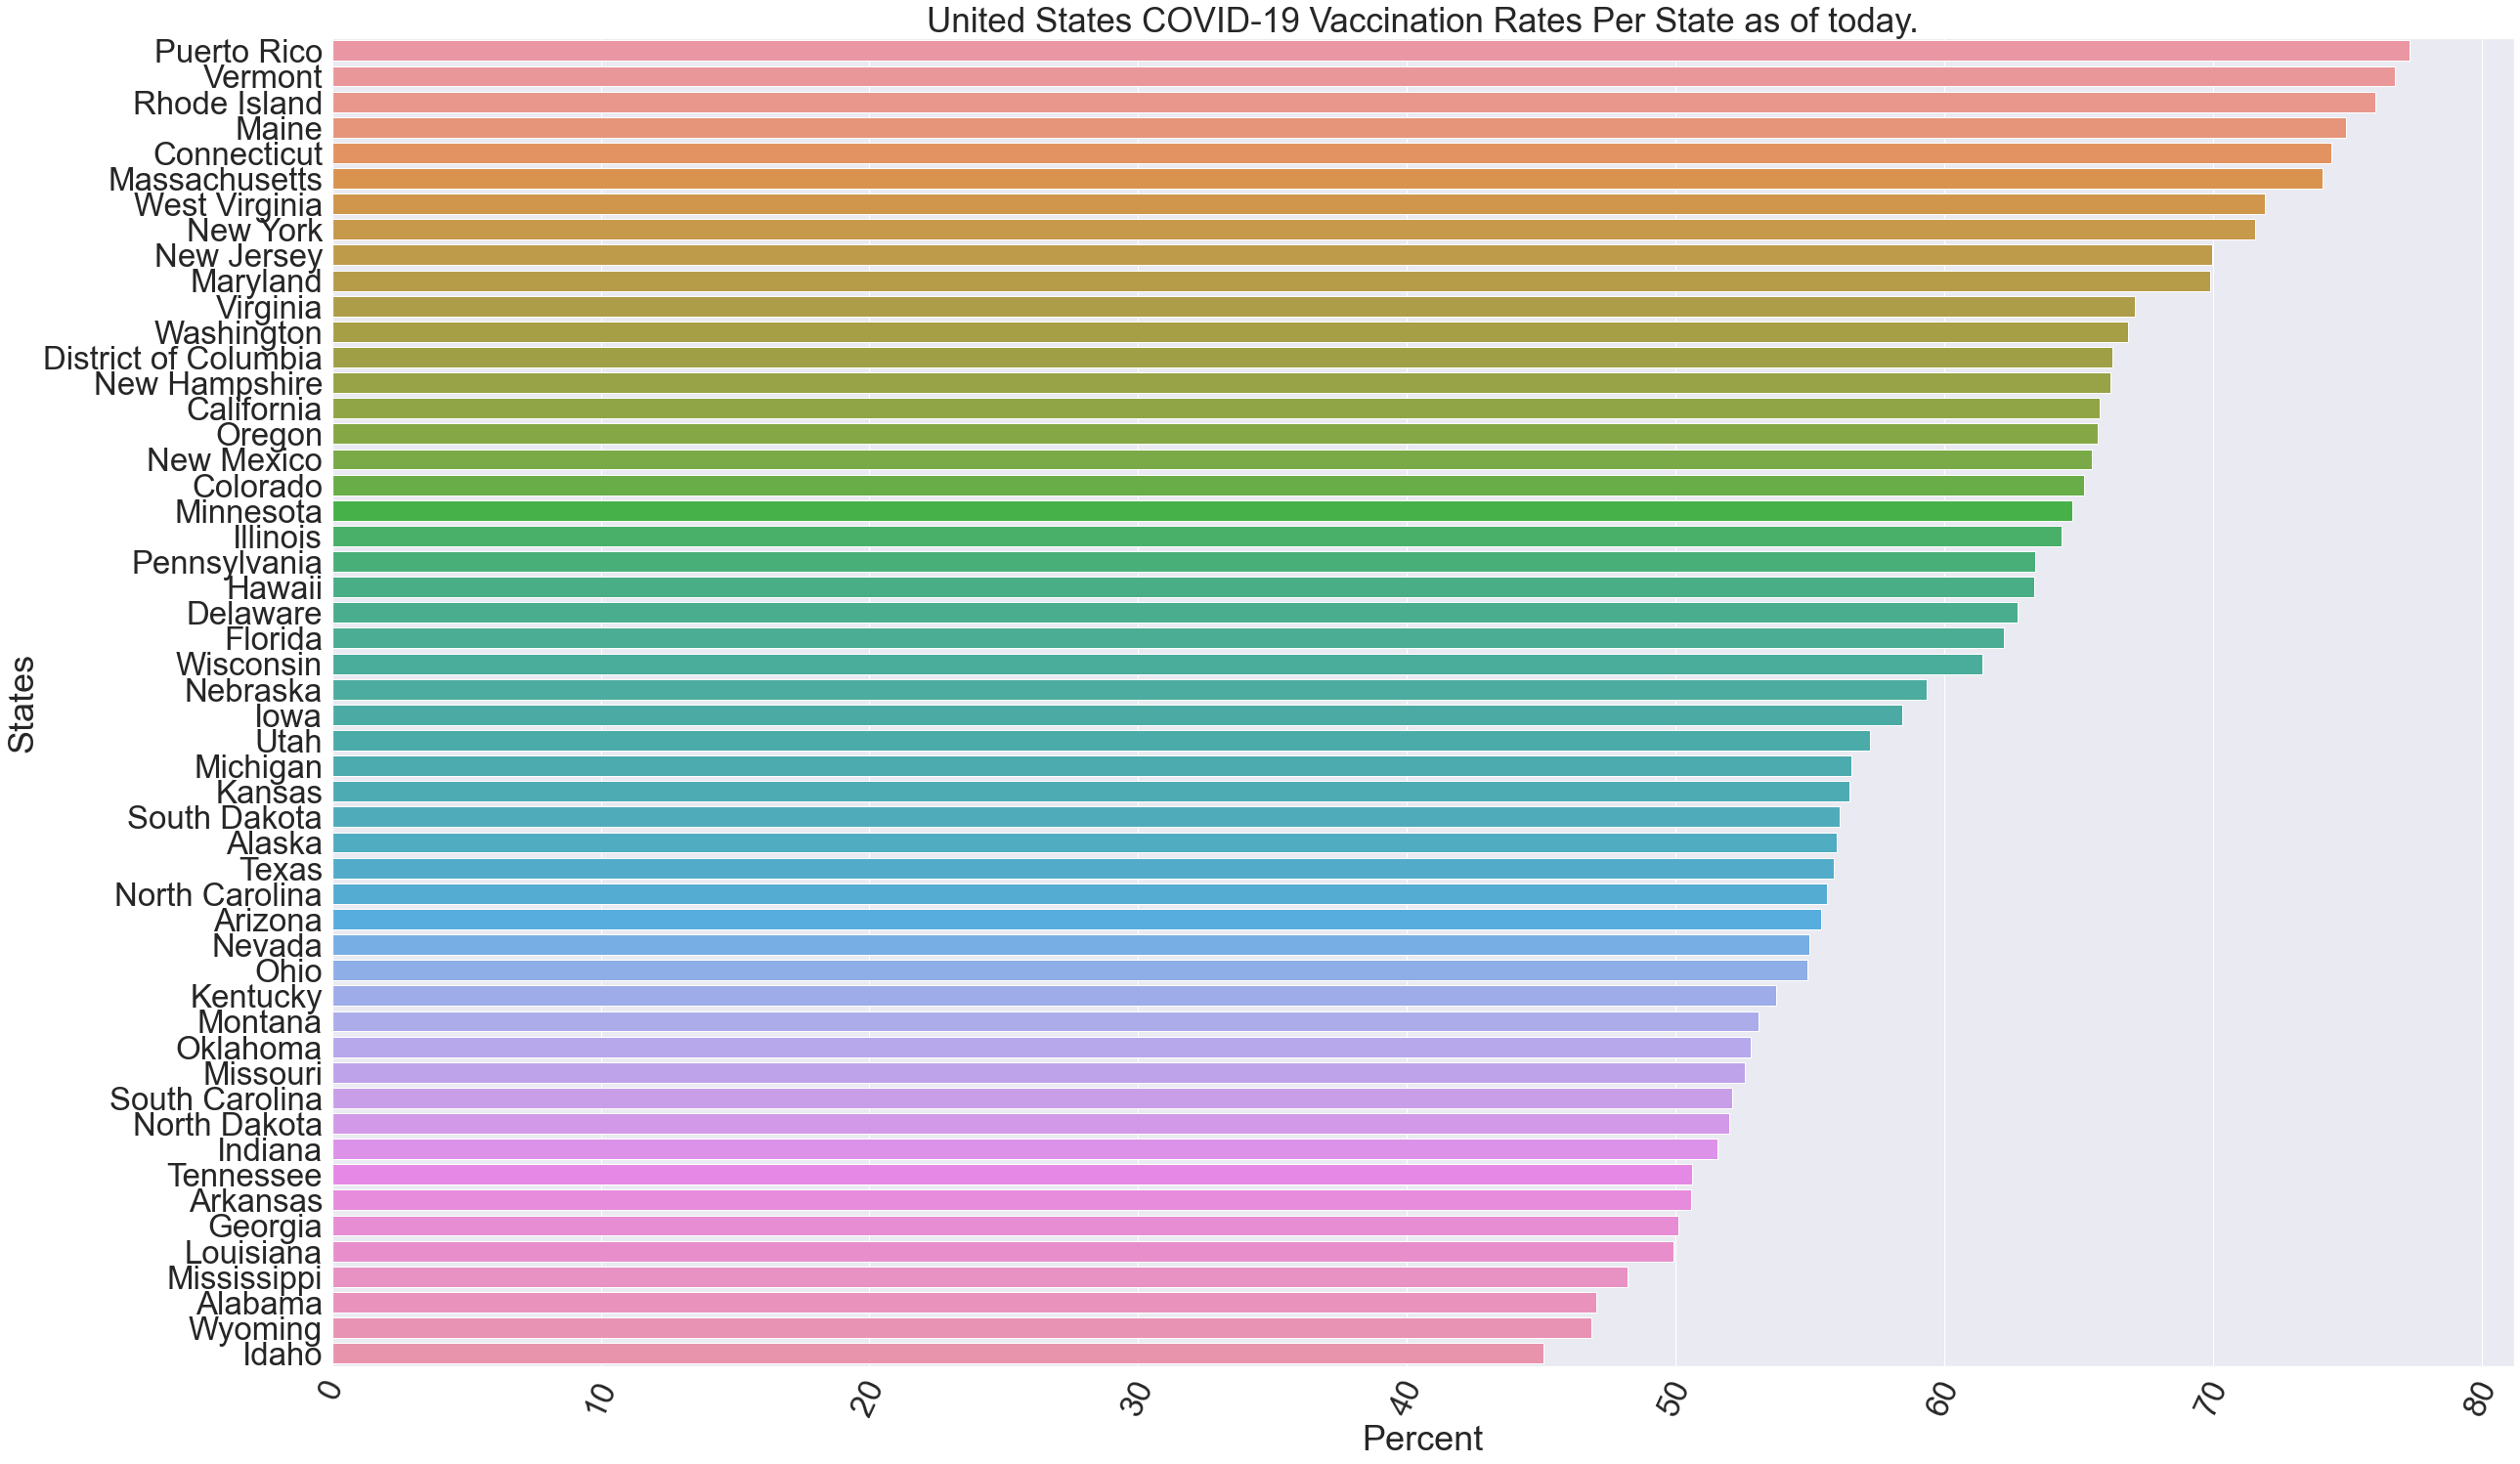

In [19]:
statsgraph=stats.graph(stats.statsDF,col="total_deaths")
vaxgraph=stats.graph(stats.vax()[0])

In [ ]:
class TestStats(unittest.TestCase):
    """ Test the methods in the Stats class."""
    
    def setUp(self):
        """ Create instances of Stats class to test its methods.
        """
        self.month = Stats("us-states.csv","nst-est2020.csv","states-sqmi20.csv","https://data.cdc.gov/resource/unsk-b7fc.json")
        
        return None
    
    def test_graph(self):
        """
        """
        
        
        return None
    
    def test_init(self):
        """ Test whether __init__() works as expected for Stats class. 
        """
        
        #self.state = ""
        #self.firstdate = ""
        #self.seconddate = ""
        #self.cfrDF = pd.DataFrame()
        #self.irDF = pd.DataFrame()
        #self.statsDF = pd.DataFrame()
        #self.datesDF = pd.DataFrame()
        #self.finalDF = pd.DataFrame()
        #self.morange = ()
        #self.yrrange = ()
        #self.data = data
        self.assertEqual(self.month., 50000.00)
    
    def testGraph(self):
        
        return None

    return None

In [20]:
""" Classes for displaying COVID-19 statistics per state in the 
United States. """

class Stats:
    def __init__(self, state, curr, lastmo, curryear=21, lastyear=21):
        """Calculating and displaying COVID-19 statistics per state.
        
        Attributes:
            data (list): list of CSV files and URL links
    
        Side effects:

        Returns:
        """
        self.data = ["us-states.csv","nst-est2020.csv","states-sqmi20.csv","https://data.cdc.gov/resource/unsk-b7fc.json","abbr.csv"]
        self.state = state
        self.curr = curr
        self.lastmo = lastmo
        self.curryear = curryear
        self.lastyear = lastyear

        self.lastmonth = pd.DataFrame()
        self.current = pd.DataFrame()
        self.allstates = []
        self.dates = pd.Series(dtype='object')
        self.firstdate = ""
        self.seconddate = ""
        self.cfrDF = pd.DataFrame()
        self.irDF = pd.DataFrame()
        self.statsDF = pd.DataFrame()
        self.datesDF = pd.DataFrame()
        self.finalDF = pd.DataFrame()
        self.morange = ()
        self.yrrange = ()
        self.deathlst = []
        self.caseslst = []
        self.loadData()

    def vax(self):
        """Calculating and displaying vaccinations rates per state.
        
        Attributes:
    
        Side effects:
            makes a request to an API

        Returns:
            (DataFrame):  contains the name and abbreviations of each state,
            fully vaccinated numbers and percentages of vaccination rates,
            current population per rate
            (float):  the sum of fully_vaccinated divided by the sum of 
            curr_pop
        """

        pop2=pd.read_csv(self.data[1])
        vaxxURL=self.data[3]
        CDCdata=requests.get(vaxxURL)
        statesvaxx=pd.DataFrame.from_records(data=CDCdata.json())
        statesvaxx=statesvaxx[['date','location','series_complete_yes']]
        statesvaxx.columns=['date','location','fully_vaccinated']
        statesvaxx.loc[:,'date']=statesvaxx['date'].apply(lambda x: 
                                                          datetime.datetime.strptime(
                                                              x,'%Y-%m-%dT%H:%M:%S.000'
                                                          ).strftime('%Y-%m-%d'))
        statesvaxx.loc[:,'day']=statesvaxx['date'].apply(lambda x: 
                                                         datetime.datetime.strptime(
                                                             x,'%Y-%m-%d').strftime('%d'))
        statesvaxx=statesvaxx.groupby('location')['fully_vaccinated'].agg('last').reset_index()
        statesvaxx=statesvaxx[(statesvaxx['location']!='AS') 
                              & (statesvaxx['location']!='BP2') 
                              & (statesvaxx['location']!='DD2') 
                              & (statesvaxx['location']!='FM') 
                              & (statesvaxx['location']!='GU') 
                              & (statesvaxx['location']!='IH2') 
                              & (statesvaxx['location']!='LTC') 
                              & (statesvaxx['location']!='MP') 
                              & (statesvaxx['location']!='RP') 
                              & (statesvaxx['location']!='US') 
                              & (statesvaxx['location']!='VA2') 
                              & (statesvaxx['location']!='VI')].reset_index(drop=True)
        pop2.columns=['SUMLEV', 'REGION', 'DIVISION', 'state', 'name', 'CENSUS2010POP',
               'ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011',
               'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
               'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
               'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE042020',
               'pop2020']
        pop2=pop2[['name','pop2020']].iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
                                            ,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
                                            ,37,38,39,40,41,42,43,56,44,45,46,47,48,49,50
                                            ,51,52,53,54,55]].reset_index(drop=True)
        pop2=pop2.iloc[[1,0,3,2,4,5,6,8,7,9,10,11,15,12,13,14,16,17,18,21,20,19,22,23,25
                        ,24,26,33,34,27,29,30,31,28,32,35,36,37,38,39,40,41,42,43,44,45
                        ,47,46,48,50,49,51]].reset_index(drop=True)
        statesvaxx=statesvaxx.drop([22]).reset_index(drop=True)
        popvaxxed=pd.concat([statesvaxx,pop2],axis=1)
        popvaxxed.columns=['abbr','fully_vaccinated','full_name','curr_pop']
        popvaxxed.loc[:,'percent']=round((popvaxxed['fully_vaccinated']
                                          .astype('int64')/popvaxxed['curr_pop'])*100,2)
        totalvaxx=popvaxxed['fully_vaccinated'].astype('int64').sum()/popvaxxed['curr_pop'].sum()

        return popvaxxed, totalvaxx
    
    def all_time(self):
        """ Visualizations for statistics.
        
        Args:
            None

        Side effects:
            displays text and a bar chart to the terminal

        Returns:
            (str):  percentage of the US that is fully vaccinated
            (bar chart):  displays vaccination rates per state in descending order
        """
        
        df=pd.read_csv(self.data[0])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        df21=df[df['year']=='21']

        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        both21=df.merge(pop)
        states_sqmi=pd.read_csv(self.data[2])
        both21=both21.merge(states_sqmi,left_on='state',right_on='states')
        both21=both21.groupby('state')[[
            'cases','deaths','day','month','year','POP2020','ppsm','sq_mi']].agg('last').reset_index()
        both21.loc[:,'case_fatality']=round((both21['deaths']/both21['cases'])*100,3)
        both21.loc[:,'incidence_rate']=round((both21['cases']/both21['POP2020'])*100000,3)

        return both21
    
    def pretty_graph(self, x, df, cal, feat):
        
        np.set_printoptions(suppress=True)
        l1=x.lines[0]
        xmaxp=max(l1.get_xydata()[:,0])
        xminp=min(l1.get_xydata()[:,0])
        xavgp=sum(l1.get_xydata()[:,0])/len(l1.get_xydata()[:,0])
        ymaxp=max(l1.get_xydata()[:,1])
        yminp=min(l1.get_xydata()[:,1])
        yavgp=sum(l1.get_xydata()[:,1])/len(l1.get_xydata()[:,1])

        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]
        allval=l1.get_xydata()
        momins=[]
        momaxs=[]
        moavgs=[]
        allmins=[]
        allmaxs=[]

        for num in allval:
            if num[1] == ymaxp:
                allmaxs.append(num)
            if num[1] == yminp:
                allmins.append(num)

        count = 0
        maxNum = []
        minNum = []
        midNum = []
        finalmax = []
        finalmin = []
        finalmid = []
        for num in allval.tolist():
            if len(allval) <= 2:
                maxNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) < 0:
                maxNum.append((count+1,(num[1]-allval[count+1][1])))
            count+=1
            if count == len(allval)-1:
                break
        if len(maxNum) < 1:
            rangexmax = np.array([0,0]) 
            rangeymax = np.array([0,0])
            maxDR = 0
        else:
            maxNum.sort(key=lambda x: x[1])
            maxpos = maxNum[0][0]
            maxDR = maxNum[0][1]

            count=0

            for num in maxNum:
                if num[1] == maxDR:
                    momaxs.append(num)
                else:
                    pass
                count+=1

            if len(momaxs) > 1:
                for num in momaxs:
                    maxpos = int(num[0])
                    if maxpos == 0:
                        rangeymax=y1[maxpos:maxpos+2]
                        rangexmax=x1[maxpos:maxpos+2]
                    elif maxpos == len(y1.tolist()):
                        rangeymax=y1[maxpos-1:maxpos]
                        rangexmax=x1[maxpos-1:maxpos]
                    else:
                        rangeymax=y1[maxpos-1:maxpos+1]
                        rangexmax=x1[maxpos-1:maxpos+1]
                    finalmax.append((rangexmax, rangeymax))

            else:
                if maxpos == 0:
                    rangeymax=y1[maxpos:maxpos+2]
                    rangexmax=x1[maxpos:maxpos+2]
                elif maxpos == len(y1.tolist()):
                    rangeymax=y1[maxpos-1:maxpos]
                    rangexmax=x1[maxpos-1:maxpos]
                else:
                    rangeymax=y1[maxpos-1:maxpos+1]
                    rangexmax=x1[maxpos-1:maxpos+1]

        count=0

        for num in allval.tolist():
            if len(allval) <= 2:
                minNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) >= 0:
                minNum.append((count+1,(num[1]-allval[count+1][1])))
            count+=1
            if count == len(allval)-1:
                break
        minNum.sort(key=lambda x: x[1])
        minpos = minNum[0][0]
        minDR=minNum[0][1]

        count=0

        for num in minNum:
            if num[1] == minDR:
                momins.append(num)
            else:
                pass
            count+=1

        if len(momins) > 1:
            for num in momins:
                minpos = int(num[0])
                if minpos == 0:
                    rangeymin=y1[minpos:minpos+2]
                    rangexmin=x1[minpos:minpos+2]
                elif minpos == len(y1.tolist()):
                    rangeymin=y1[minpos-1:minpos]
                    rangexmin=x1[minpos-1:minpos]
                else:
                    rangeymin=y1[minpos-1:minpos+1]
                    rangexmin=x1[minpos-1:minpos+1]
                finalmin.append((rangexmin, rangeymin))

        else:

            if minpos == 0:
                rangeymin=y1[minpos:minpos+2]
                rangexmin=x1[minpos:minpos+2]
            elif minpos == len(y1.tolist()):
                rangeymin=y1[minpos-1:minpos]
                rangexmin=x1[minpos-1:minpos]
            else:
                rangeymin=y1[minpos-1:minpos+1]
                rangexmin=x1[minpos-1:minpos+1]

        count=0

        for num in allval.tolist():
            if len(allval) <= 2:
                midNum.append((count+1,num[1]-allval[count+1][1]))
            if (num[1]-allval[count+1][1]) >= 0:
                midNum.append((count+1,num[1]-allval[count+1][1]))
            count+=1
            if count == len(allval)-1:
                break
        midNum.sort(reverse=True, key=lambda x: x[1])
        midpos = midNum[0][0]
        midDR=midNum[0][1]

        count=0

        for num in midNum:
            if num[1] == midDR:
                moavgs.append(num)
            else:
                pass
            count+=1

        if len(moavgs) > 1:
            for num in moavgs:
                midpos = int(num[0])
                if midpos == 0:
                    rangeymid=y1[midpos:midpos+2]
                    rangexmid=x1[midpos:midpos+2]
                elif midpos == len(y1.tolist()):
                    rangeymid=y1[midpos-1:midpos]
                    rangexmid=x1[midpos-1:midpos]
                else:
                    rangeymid=y1[midpos-1:midpos+1]
                    rangexmid=x1[midpos-1:midpos+1]
                finalmid.append((rangexmid, rangeymid))

        else:

            if midpos == 0:
                rangeymid=y1[midpos:midpos+2]
                rangexmid=x1[midpos:midpos+2]
            elif midpos == len(y1.tolist()):
                rangeymid=y1[midpos-1:midpos]
                rangexmid=x1[midpos-1:midpos]
            else:
                rangeymid=y1[midpos-1:midpos+1]
                rangexmid=x1[midpos-1:midpos+1]

        indexDeaths=df[feat].tolist().index(df[feat].max())
        maxMo=df[cal].iloc[indexDeaths]
        maxDeaths=df[feat].iloc[indexDeaths]
        indexDeaths=df[feat].tolist().index(df[feat].min())
        minMo=df[cal].iloc[indexDeaths]
        minDeaths=df[feat].iloc[indexDeaths]
        
        x.fill_between(x1,y1,color='blue',alpha=0.1)
        avgline=x.axhline(yavgp,color='black',linewidth=2.5)
        minP=x.fill_between(rangexmin,rangeymin,color='green')
        maxP=x.fill_between(rangexmax,rangeymax,color='red')
        midP=x.fill_between(rangexmid,rangeymid,color='purple')

        checkMonths = ["January '20","February '20","March '20","April '20","May '20","June '20","July '20","August '20","September '20",
                       "October '20","November '20","December '20","January '21","February '21","March '21",
                       "April '21","May '21","June '21","July '21","August '21","September '21"]

        if minMo in checkMonths:
            self.firstdate = df[cal].iloc[0]
            self.seconddate = df[cal].iloc[-1]
            findCounty = re.search(r"^.+County", x.title.get_text())
            self.state = findCounty.group(0)
            print(self.state+" statistics from "+self.firstdate+" to "+self.seconddate+".")
        else:
            print(self.state+" statistics from "+self.firstdate+" to "+self.seconddate+".")
            if len(allmins) > 1:
                for num in allmins:
                    minMo=df[cal].iloc[int(num[0])]
                    minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
                    txt="Lowest recorded "+feat+":  {:,} on "+minMo
                    print(txt.format(num[1]))
            else:
                minMo = datetime.datetime.strptime(minMo,'%Y-%m-%d').strftime('%B %d')
                txt="Lowest recorded "+feat+":  {:,} on "+minMo
                print(txt.format(minDeaths))
            
            if len(allmaxs) > 1:
                for num in allmaxs:
                    maxMo=df[cal].iloc[int(num[0])]
                    maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
                    txt="Highest recorded "+feat+":  {:,} on "+maxMo
                    print(txt.format(num[1]))
            else:
                maxMo = datetime.datetime.strptime(maxMo,'%Y-%m-%d').strftime('%B %d')
                txt="Highest recorded "+feat+":  {:,} on "+maxMo
                print(txt.format(maxDeaths))
                
        if cal == "dates":
            cal = "days"
        txt="A total of {:,} "+feat+" over the last "+str(df[feat].count())+" "+cal[:-1]+"(s)"+"."
        print(txt.format(round(df[feat].sum()),2))
        txt="Average "+feat[:-1]+" rate:  {:,} per "+cal[:-1]+"."
        print(txt.format(round(df[feat].sum()/len(df[feat]),2)))

        if len(finalmax) > 1:
            for allthemaxs in finalmax:
                 maxP=x.fill_between(allthemaxs[0],allthemaxs[1],color='red')
        if len(finalmin) > 1:
            for allthemins in finalmin:
                minP=x.fill_between(allthemins[0],allthemins[1],color='green')
                plt.plot([finalmin[0][0],finalmin[-1][0]],[0,0], linewidth=7, color='green')
        if len(finalmid) > 1:
            for alltheavgs in finalmid:
                midP=x.fill_between(alltheavgs[0],alltheavgs[1],color='purple')
        if minDR == 0 and len(finalmin) < 1:
            plt.plot([rangexmin[0],rangexmin[1]],[0,0], linewidth=7, color='green')

        txt="Largest increase in "+feat+":  {:,}."
        if maxDR == 0:
            print(txt.format(maxDR))
        else:
            print(txt.format(maxDR*-1))

        txt="Smallest rate of "+feat+": {:,}."
        print(txt.format(minDR))

        txt="Largest drop in "+feat+": {:,}"
        print(txt.format(midDR))

        logo = img.imread(fname='watermarkMAR.png')
        x.figure.figimage(logo,110,270,alpha=0.5)

        plt.legend(labels=['smallest rate','largest drop','largest increase','average rate'],
                       handles=[minP,midP,maxP,avgline], shadow=True, title=feat.capitalize(),
                      title_fontsize='large', borderpad=0.3, fontsize='small')
        plt.show()

        return None

    def loadData(self):
        
        if self.lastmo < 0 or self.curr < 0:
            print("Enter correct parameters.")
            return None

        if self.lastmo > self.curr:
            if self.lastyear > self.curryear:
                print("Enter correct parameters.")
                return None
            if self.lastyear == self.curryear:
                print("Enter correct parameters.")
                return None

        df=pd.read_csv(self.data[0])
        pop=pd.read_csv(self.data[1])
        pop.columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
               'ESTIMATESBASE2010', '2010', '2011',
               '2012', '2013', '2014',
               '2015', '2016', '2017',
               '2018', '2019', '042020',
               'POP2020']
        pop=pop[['NAME','POP2020']]
        pop=pop.iloc[[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                     28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,56,44,45,46,47,48,49,
                     50,51,52,53,54,55]].reset_index(drop=True)
        pop.columns=['state','POP2020']
        sqmi=pd.read_csv(self.data[2])
        df.loc[:,'day']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%d'))
        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        df=df[['date','state','cases','deaths','day','month','year']]
        df['day']=df['day'].astype('int64')
        df['month']=df['month'].astype('int64')
        df['year']=df['year'].astype('int64')
        df=df.merge(pop)
        abbr=pd.read_csv(self.data[4])
        df=df.merge(abbr, left_on='state',right_on='full_name')
        df=df.drop(['full_name'],axis=1).reset_index(drop=True)
        self.state=df[df['abbr']==self.state].iloc[0]['state']

        jan20=df[(df['year']==20) & (df['month']==1)]['state'].unique().tolist()
        feb20=df[(df['year']==20) & (df['month']==2)]['state'].unique().tolist()

        current=df[(df['month']==self.curr) & (df['year']==self.curryear)]

        if self.lastyear==20 and self.curryear==21:
            self.lastmonth=df[(df['month']==self.lastmo) & (df['year']==self.lastyear)]
            one=df[(df['month']>=self.lastmo+1) & (df['year']==self.lastyear)]
            two=df[(df['month']<=self.curr) & (df['year']==self.curryear)]
            current=pd.concat([one,two]).reset_index(drop=True)
        elif self.lastmo==1 and self.lastyear==20:
            if state in jan20:
                self.lastmonth=df[(df['month']==1) & (df['day']>=26) & (df['year']==self.lastyear)]
                current=df[(df['month']>=2) & (df['month']<=self.curr) & (df['year']==self.curryear)]
            elif state in feb20:
                self.lastmonth=df[(df['month']==2) & (df['day']>=28) & (df['year']==self.lastyear)]
                current=df[(df['month']>=3) & (df['month']<=curr) & (df['year']==self.curryear)]
            else:
                self.lastmonth=df[(df['month']==3) & (df['day']>=17) & (df['year']==self.lastyear)]
                current=df[(df['month']>=4) & (df['month']<=self.curr) & (df['year']==self.curryear)]
        elif self.lastmo == self.curr:
            self.lastmonth=df[(df['month']==self.lastmo) & (df['year']==self.lastyear)]
        else:
            if abs(self.curr-self.lastmo)>=2:
                self.lastmonth=df[(df['month']==self.lastmo) & (df['year']==self.lastyear)]
                current=df[(df['month']>=self.lastmo+1) & (df['month']<=self.curr) & (df['year']==self.curryear)]
            else:
                self.lastmonth=df[(df['month']==self.lastmo) & (df['year']==self.lastyear)]

        self.morange=(self.lastmo, self.curr)
        self.yrrange=(self.lastyear, self.curryear)
        allstates=current['state'].unique().tolist()
        
        caseslst=[]
        deathlst=[]

        for sts in allstates:
            laststat=self.lastmonth[self.lastmonth['state']==sts].reset_index(drop=True)
            statscurr=current[current['state']==sts].reset_index(drop=True)
            if self.lastmonth['month'].iloc[0] == current['month'].iloc[0]:
                stats=statscurr
            else:
                stats=pd.concat([laststat,statscurr]).reset_index(drop=True)
            count=0
            if sts==self.state:
                dates=stats['date']
            data=stats
            col="cases"
            lst3=[]
            lst4=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst3.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst3) == 1:
                    if lst3[0] >= 0:
                        lst4.append(lst3[0])
                    else:
                        lst4.append(-(lst3[0]))
                    continue
                if deaths < 0:
                    lst4.append(-(lst3[count-1]))
                else:
                    lst4.append(lst3[count-1])
            lst4.insert(0,first)
            caseslst.append(lst4)

            count=0
            data=stats
            col="deaths"
            lst5=[]
            lst6=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst5.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst5) == 1:
                    if lst5[0] >= 0:
                        lst6.append(lst5[0])
                    else:
                        lst6.append(-(lst5[0]))
                    continue
                if deaths < 0:
                    lst6.append(-(lst5[count-1]))
                else:
                    lst6.append(lst5[count-1])
            lst6.insert(0,first)
            deathlst.append(lst6)
        
        IRlst=[]
        CFRlst=[]
        avgCases=[]
        avgDeaths=[]
        totalCases=[]
        totalDeaths=[]
        casessts=[]
        deathssts=[]
        eachstate=[]

        for things, things2, sts in zip(caseslst, deathlst, allstates):
            stats=current[current['state']==sts].reset_index(drop=True)
            IR=round((sum(things[1:])/stats['POP2020'].iloc[1])*100000,3)
            IRlst.append(IR)
            CFR=round((sum(things2[1:])/sum(things[1:]))*100,3)
            CFRlst.append(CFR)
            avgCases.append(round(sum(things[1:])/len(things[1:]),2))
            avgDeaths.append(round(sum(things2[1:])/len(things2[1:]),2))
            totalCases.append(sum(things[1:]))
            totalDeaths.append(sum(things2[1:]))
            eachstate.append(pd.DataFrame({'states':sts,'deaths':things2[1:],'cases':things[1:]}))
            casessts.append((sts,things[1:]))
            deathssts.append((sts,things2[1:]))
        
        self.current = current
        popvaxxed=self.vax()[0]
        irDF=pd.DataFrame({'states':allstates,'IR':IRlst})
        cfrDF=pd.DataFrame({'states':allstates,'CFR':CFRlst})
        statsDF=pd.DataFrame({'states':allstates,'avg_cases':avgCases,'avg_deaths':avgDeaths,'total_cases':totalCases,'total_deaths':totalDeaths})
        statsDF=statsDF.merge(popvaxxed[['full_name','curr_pop','percent']],left_on='states',right_on='full_name')
        self.statsDF=statsDF.drop(columns='full_name')
        self.firstdate=datetime.datetime.strptime(self.lastmonth.iloc[1]['date'],'%Y-%m-%d').strftime('%B %d')
        self.seconddate=datetime.datetime.strptime(self.current.iloc[-1]['date'],'%Y-%m-%d').strftime('%B %d')
        dates=dates.drop([0]).reset_index(drop=True)
        self.irDF=irDF
        self.cfrDF=cfrDF

        for st, cs in casessts:
            if st==self.state:
                datesDF=pd.DataFrame({'dates':dates,'cases':cs})
        for st, ds in deathssts:
            if st==self.state:
                datesDF=datesDF.merge(pd.DataFrame({'dates':dates,'deaths':ds}))
        self.datesDF = datesDF

        pop=self.all_time()
        state_sqmi=pd.read_csv(self.data[2])
        for num in pop['state'].tolist():
            if num==self.state:
                popstate=pop.sort_values(by='POP2020',ascending=False).reset_index(drop=True)
                popNum=popstate['state'].tolist().index(num)
                vaxxedorder=popvaxxed.sort_values(by='percent',ascending=False).reset_index(drop=True)
                pct=vaxxedorder['full_name'].tolist().index(num)
                ppsm=state_sqmi['states'].tolist().index(num)
                sqmiorder=state_sqmi.sort_values(by='sq_mi',ascending=False).reset_index(drop=True)
                sqmiNum=sqmiorder['states'].tolist().index(num)
                cfrDF=cfrDF.sort_values(by='CFR',ascending=False).reset_index(drop=True)
                cfrNum=cfrDF['states'].tolist().index(num)
                irDF=irDF.sort_values(by='IR',ascending=False).reset_index(drop=True)
                irNum=irDF['states'].tolist().index(num)
                totalpop=popstate.iloc[[popNum]]['POP2020'][popNum]
                both21=self.all_time()
                both21=both21.sort_values(by='case_fatality',ascending=False).reset_index(drop=True)
                bothNum=both21['state'].tolist().index(num)
                natrank1=both21['state'].tolist().index(num)
                cfr=both21.iloc[[bothNum]]['case_fatality'][bothNum]
                both21=both21.sort_values(by='incidence_rate',ascending=False).reset_index(drop=True)
                bothNum=both21['state'].tolist().index(num)
                ir=both21.iloc[[bothNum]]['incidence_rate'][bothNum]
                natrank2=both21['state'].tolist().index(num)
                totcases=statsDF.sort_values(by='total_cases',ascending=False).reset_index(drop=True)
                totdeaths=statsDF.sort_values(by='total_deaths',ascending=False).reset_index(drop=True)
                casesNum=totcases['states'].tolist().index(num)
                deathsNum=totdeaths['states'].tolist().index(num)

                display("State of "+self.state)
                avgstats=statsDF.sort_values(by='avg_cases',ascending=False).reset_index(drop=True)
                statsNum=avgstats['states'].tolist().index(num)
                txt="Average of {:,} cases per day in "+str(round(datesDF.describe().iloc[0][0],2))+" days, currently ranked #"+str(statsNum+1)+" in the United States."                    
                display(txt.format(round(datesDF.describe().iloc[1][0],2),2))
                avgstats=statsDF.sort_values(by='avg_deaths',ascending=False).reset_index(drop=True)
                statsNum=avgstats['states'].tolist().index(num)
                txt="Average of {:,} deaths per day in "+str(round(datesDF.describe().iloc[0][0],2))+" days, currently ranked #"+str(statsNum+1)+" in the United States."
                display(txt.format(round(datesDF.describe().iloc[1][1],2)))

                display("Case Fatality Ratio from "+self.firstdate+" to "+self.seconddate+": "+str(cfrDF['CFR'].iloc[cfrNum])+"%, currently ranked #"+str(cfrNum+1)+" in the United States.")
                txt="Incidence Rate from "+self.firstdate+" to "+self.seconddate+": {:,} per 100k, currently ranked #"+str(irNum+1)+" in the United States."
                display(txt.format(irDF['IR'].iloc[irNum]))
                txt="There have been {:,} cases from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
                display(txt.format(datesDF['cases'].sum(),casesNum+1))
                txt="There have been {:,} deaths from "+self.firstdate+" To "+self.seconddate+", currently ranked #{} in the United States."
                display(txt.format(datesDF['deaths'].sum(),deathsNum+1))

                display(self.state+" is "+str(vaxxedorder.iloc[pct]['percent'])+"% fully vaccinated, currently ranked #"+str(pct+1)+" in the United States.")
                txt="Total population: {:,}, ranked #"+str(popNum+1)+" in the United States."
                display(txt.format(totalpop))
                txt="There are {:,} people per square mile, ranked #"+str(ppsm+1)+" in the United States." 
                display(txt.format(state_sqmi.iloc[ppsm]['ppsm']))
                txt=self.state+" has {:,} total square miles, ranking #"+str(sqmiNum+1)+" in the United States."
                display(txt.format(sqmiorder.iloc[sqmiNum]['sq_mi']))
                display("All Time Case Fatality Ratio: "+str(cfr)+"%, currently ranked #"+str(natrank1+1)+" in the United States.")
                txt="All Time Incidence Rate: {:,} per 100k, currently ranked #"+str(natrank2+1)+" in the United States."
                display(txt.format(ir))
                display(round(datesDF.describe().T,2))

                for stuff in eachstate:
                    if stuff['states'].iloc[0]==self.state:
                        self.finalDF=pd.DataFrame({'dates':dates,'cases':stuff['cases'],'deaths':stuff['deaths']})        
        return None

    def graph(self, data, col=None):
        """ Visualizations for statistics.
        
        Args:
            data (object):  returned data from a class function
            col (str):  

        Side effects:
            displays text and a bar chart to the terminal

        Returns:
            (str):  percentage of the US that is fully vaccinated
            (bar chart):  displays vaccination rates per state in descending order
        """

        first=40
        monthRange = self.morange[1] - self.morange[0]
        if self.yrrange[0] == self.yrrange[1]:
            if self.morange[1] > self.morange[0]:
                first = (40 if monthRange < 2
                        else 60 if monthRange == 2
                        else 80 if monthRange == 3
                        else 100 if monthRange == 4
                        else 120 if monthRange == 5
                        else 140 if monthRange == 6
                        else 160 if monthRange == 7
                        else 180 if monthRange == 8
                        else 200 if monthRange == 9
                        else 220 if monthRange == 10
                        else 240 if monthRange == 11
                        else 260)
        else:
            if self.yrrange[1] > self.yrrange[0]:
                newmorange = self.morange[0]
                newmorange = 12 - self.morange[0]
                monthRange = newmorange+self.morange[1]
                first = (40 if monthRange < 2
                        else 60 if monthRange == 2
                        else 80 if monthRange == 3
                        else 100 if monthRange == 4
                        else 120 if monthRange == 5
                        else 140 if monthRange == 6
                        else 160 if monthRange == 7
                        else 180 if monthRange == 8
                        else 220 if monthRange == 9
                        else 240 if monthRange == 10
                        else 260 if monthRange == 11
                        else 280 if monthRange == 12
                        else 300 if monthRange == 13
                        else 320 if monthRange == 14
                        else 340 if monthRange == 15
                        else 360 if monthRange == 16
                        else 380 if monthRange == 17
                        else 400 if monthRange == 18
                        else 420 if monthRange == 19
                        else 440 if monthRange == 20
                        else 460 if monthRange == 21
                        else 480 if monthRange == 22
                        else 500 if monthRange == 23
                        else 520)

        if data.columns[0] == "dates":

            figsize=(first,20)
            xlabel = self.datesDF['dates'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%B %d")).tolist()
            xlist = self.datesDF['dates'].tolist()

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=self.finalDF,y='deaths',x='dates',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            x.set_title(self.state+" COVID-19 Death Rate From "+self.firstdate+" To "+self.seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Deaths")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            self.pretty_graph(x, self.finalDF, self.datesDF.columns[0], self.finalDF.columns[2])
            #plt.savefig(self.state+"_"+"death_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=figsize)
            x=sns.lineplot(data=self.finalDF,y='cases',x='dates',ci=None, linewidth=7, color='black')
            x.tick_params(axis='x', rotation=65)
            x.set_title(self.state+" COVID-19 Case Rate From "+self.firstdate+" To "+self.seconddate,fontsize=35);
            x.set_xlabel("Dates")
            x.set_ylabel("Cases")
            x.set_xticks(xlist)
            x.set_xticklabels(xlabel)
            self.pretty_graph(x, self.finalDF, self.datesDF.columns[0], self.finalDF.columns[1])
            #plt.savefig(self.state+"_"+"incidence_rate"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');
        
        if col == "avg_cases":
            print(data.columns.tolist()[1:])
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=self.statsDF.sort_values(by=col,ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title(col.capitalize()+" Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35)
            x.set_xlabel("Confirmed Cases")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col == "avg_deaths":
            print(data.columns.tolist()[1:])
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=self.statsDF.sort_values(by=col,ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title(col.capitalize()+" Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35)
            x.set_xlabel("Confirmed Deaths")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');
            
        if col == "total_cases":
            print(data.columns.tolist()[1:])
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=self.statsDF.sort_values(by=col,ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title(col.capitalize()+" Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35)
            x.set_xlabel("Confirmed Cases")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');
            
        if col == "total_deaths":
            print(data.columns.tolist()[1:])
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=self.statsDF.sort_values(by=col,ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title(col.capitalize()+" Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35)
            x.set_xlabel("Confirmed Deaths")
            x.set_ylabel("States")
            #plt.savefig("US_"+col+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col=="POP2020":
            if len(str(data.loc[0,['month','year']]['month'])) < 2:
                x="0"+str(data.loc[0,['month','year']]['month'])
            newdate=[x+","+str(data.loc[0,['month','year']]['year'])]
            seconddate=datetime.datetime.strptime(
                newdate[0],'%m,%y'
            ).strftime('%B %Y')

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=data.sort_values(by='case_fatality',ascending=False),y='state',x='case_fatality',ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("All Time COVID-19 Case Fatality Ratio Per State from January 2020 to"
                        +" "+self.seconddate,fontsize=35)
            x.set_xlabel("Cases")
            x.set_ylabel("States");

            sns.set(font_scale=3)
            plt.figure(figsize=(40,30))
            x=sns.barplot(data=data.sort_values(by='incidence_rate',ascending=False),y='state',x='incidence_rate',ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("All Time COVID-19 Incidence Rate Per State from January 2020 to"
                        +" "+self.seconddate,fontsize=35)
            x.set_xlabel("Percent")
            x.set_ylabel("States");

        if col=="CFR":

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,25))
            x=sns.barplot(data=self.cfrDF.sort_values(by='CFR',ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("Case Fatality Rates Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35);
            x.set_xlabel("Case Fatalities (Percent)")
            x.set_ylabel("States")
            #plt.savefig("US_"+"case_fatality_rates"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');

        if col=="IR":

            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,25))
            x=sns.barplot(data=self.irDF.sort_values(by='IR',ascending=False),y='states',x=col,ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("Incidence Rates Per State from "+self.firstdate+" to "+self.seconddate,fontsize=35);
            x.set_xlabel("Confirmed Cases (Per 100k)")
            x.set_ylabel("States")
            #plt.savefig("US_"+"incidence_rates"+"_"+str(self.morange[0])+str(self.yrrange[0])
            #            +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight');
            
        if col == "vax":
            sns.set(font_scale=3)
            sns.set_style("whitegrid")
            plt.figure(figsize=(40,25))
            x=sns.barplot(data=data.sort_values(by='percent',ascending=False)
                              ,x='percent',y='full_name',ci=None)
            x.tick_params(axis='x', rotation=65)
            x.set_title("United States COVID-19 Vaccination Rates Per State as of today.",fontsize=35)
            x.set_xlabel("Percent")
            x.set_ylabel("States")
            plt.savefig("US_"+"vaccination_rates"+str(self.morange[0])+str(self.yrrange[0])
                        +"_"+str(self.morange[1])+str(self.yrrange[1])+".png",bbox_inches='tight')
            print("The United States is %"+str(round(self.vax()[1]*100, 2))
                  +" fully vaccinated.");

def parse_args(arglist):

    parser = ArgumentParser()
    parser.add_argument("data", help="CSV files and URL links",
                        type=str)
    args = parser.parse_args(arglist)

    return args

def main(arglist):

    args = parse_args(arglist)
    w=Stats(args.file)

    return None

In [48]:
stats=Stats(state='TN', curr=12, lastmo=12, curryear=21)

'State of Tennessee'

'Average of 3,034.63 cases per day in 30.0 days, currently ranked #21 in the United States.'

'Average of 119.53 deaths per day in 30.0 days, currently ranked #1 in the United States.'

'Case Fatality Ratio from December 02 to December 31: 3.939%, currently ranked #1 in the United States.'

'Incidence Rate from December 02 to December 31: 1,321.928 per 100k, currently ranked #36 in the United States.'

'There have been 91,039 cases from December 02 To December 31, currently ranked #21 in the United States.'

'There have been 3,586 deaths from December 02 To December 31, currently ranked #1 in the United States.'

'Tennessee is 50.63% fully vaccinated, currently ranked #45 in the United States.'

'Total population: 6,886,834, ranked #16 in the United States.'

'There are 112.4 people per square mile, ranked #25 in the United States.'

'Tennessee has 42,144 total square miles, ranking #36 in the United States.'

'All Time Case Fatality Ratio: 1.452%, currently ranked #21 in the United States.'

'All Time Incidence Rate: 20,734.825 per 100k, currently ranked #5 in the United States.'

count     mean      std  min  25%     50%     75%      max
cases    30.0  3034.63  3811.93  0.0  0.0  2137.5  4016.5  14544.0
deaths   30.0   119.53   383.14  0.0  0.0    42.5    85.5   2128.0

Tennessee statistics from December 02 to December 31.
Lowest recorded deaths:  0.0 on December 04
Lowest recorded deaths:  0.0 on December 05
Lowest recorded deaths:  0.0 on December 09
Lowest recorded deaths:  0.0 on December 11
Lowest recorded deaths:  0.0 on December 12
Lowest recorded deaths:  0.0 on December 18
Lowest recorded deaths:  0.0 on December 19
Lowest recorded deaths:  0.0 on December 24
Lowest recorded deaths:  0.0 on December 25
Lowest recorded deaths:  0.0 on December 26
Lowest recorded deaths:  0.0 on December 31
Highest recorded deaths:  2,128 on December 23
A total of 3,586 deaths over the last 30 day(s).
Average death rate:  119.53 per day.
Largest increase in deaths:  2,060.0.
Smallest rate of deaths: 0.0.
Largest drop in deaths: 2,128.0


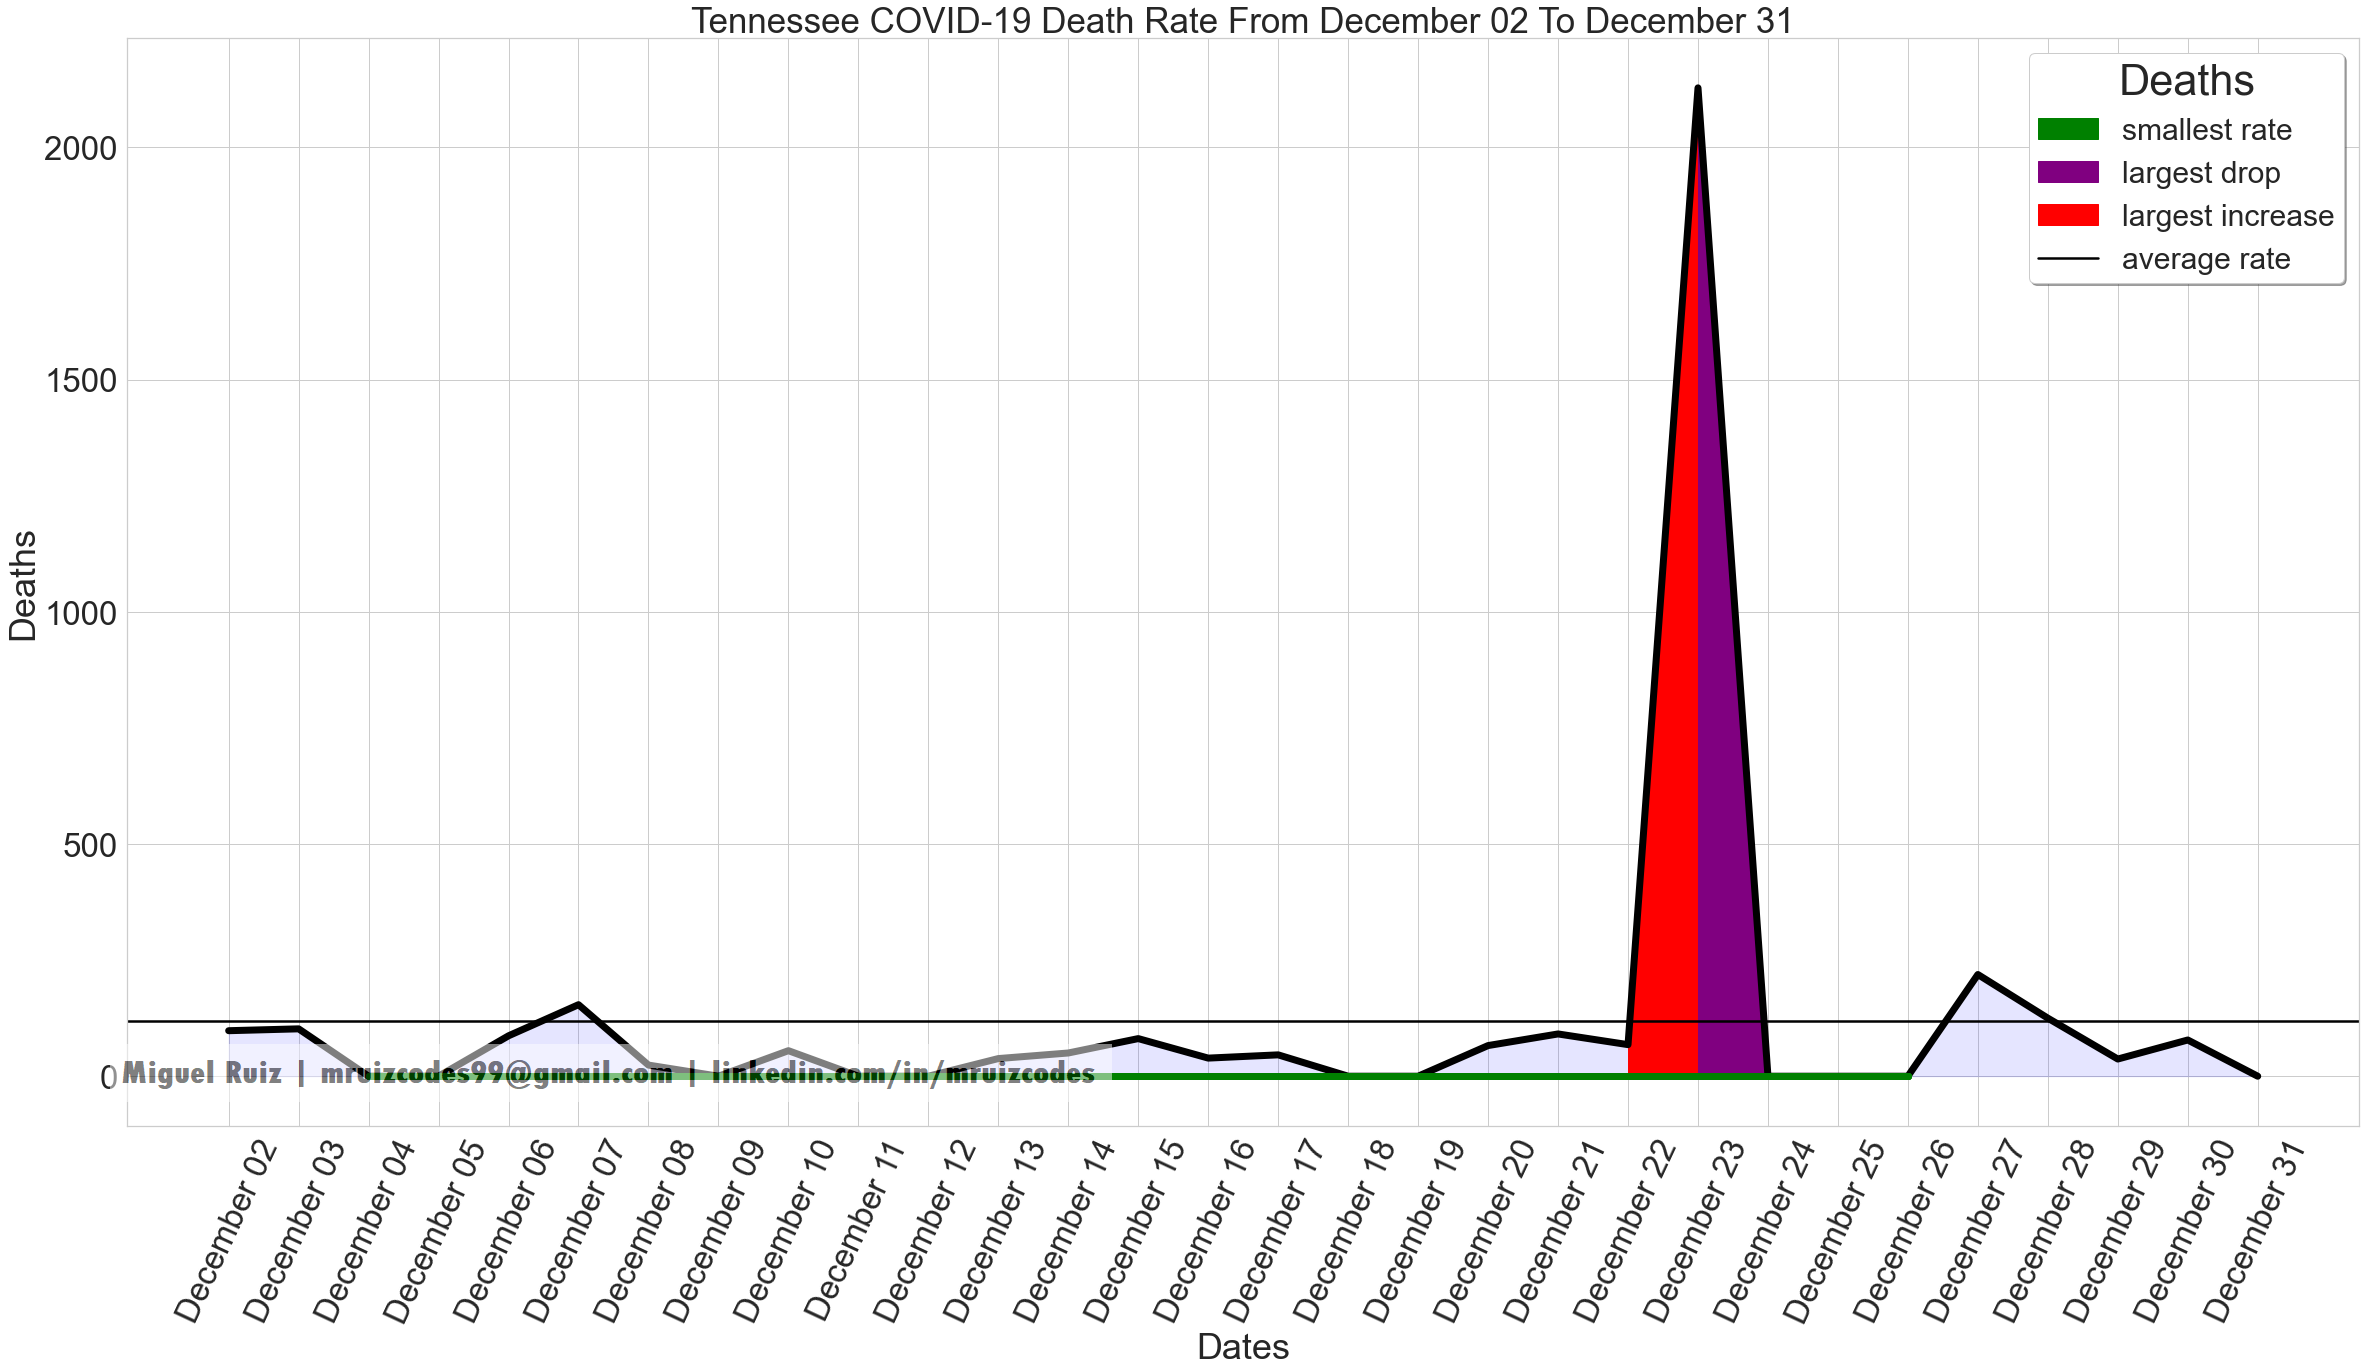

Tennessee statistics from December 02 to December 31.
Lowest recorded cases:  0.0 on December 04
Lowest recorded cases:  0.0 on December 05
Lowest recorded cases:  0.0 on December 09
Lowest recorded cases:  0.0 on December 11
Lowest recorded cases:  0.0 on December 12
Lowest recorded cases:  0.0 on December 18
Lowest recorded cases:  0.0 on December 19
Lowest recorded cases:  0.0 on December 24
Lowest recorded cases:  0.0 on December 25
Lowest recorded cases:  0.0 on December 26
Lowest recorded cases:  0.0 on December 31
Highest recorded cases:  14,544 on December 27
A total of 91,039 cases over the last 30 day(s).
Average case rate:  3,034.63 per day.
Largest increase in cases:  14,544.0.
Smallest rate of cases: 0.0.
Largest drop in cases: 13,537.0


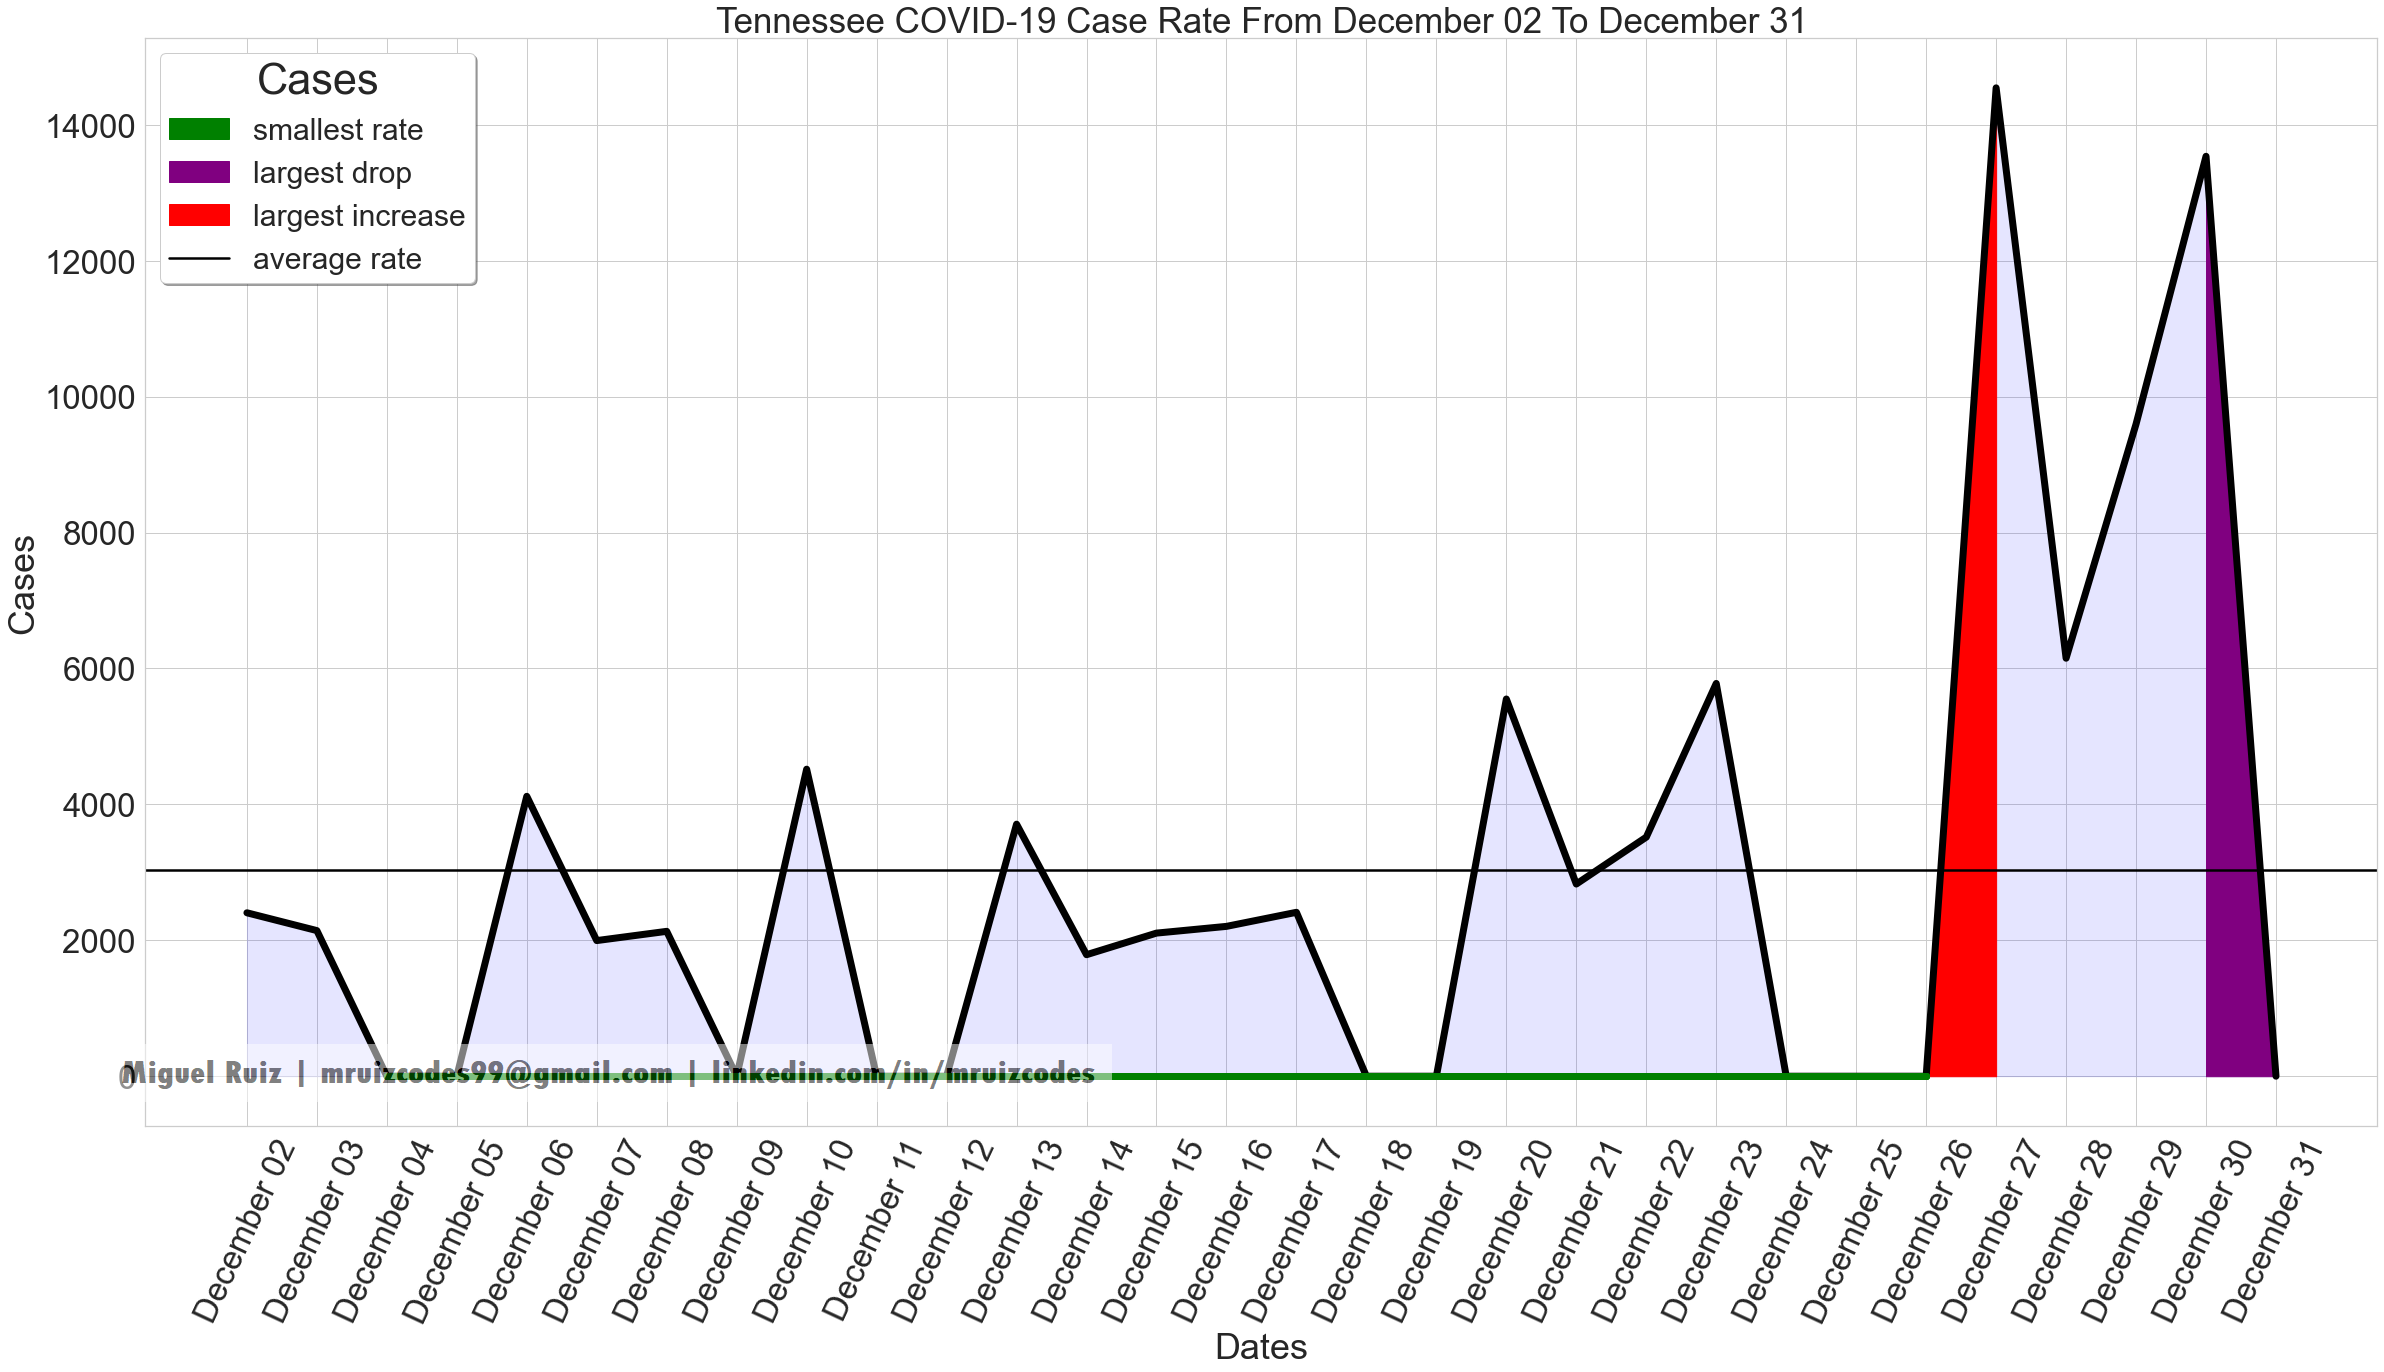

In [49]:
stats.graph(stats.finalDF)

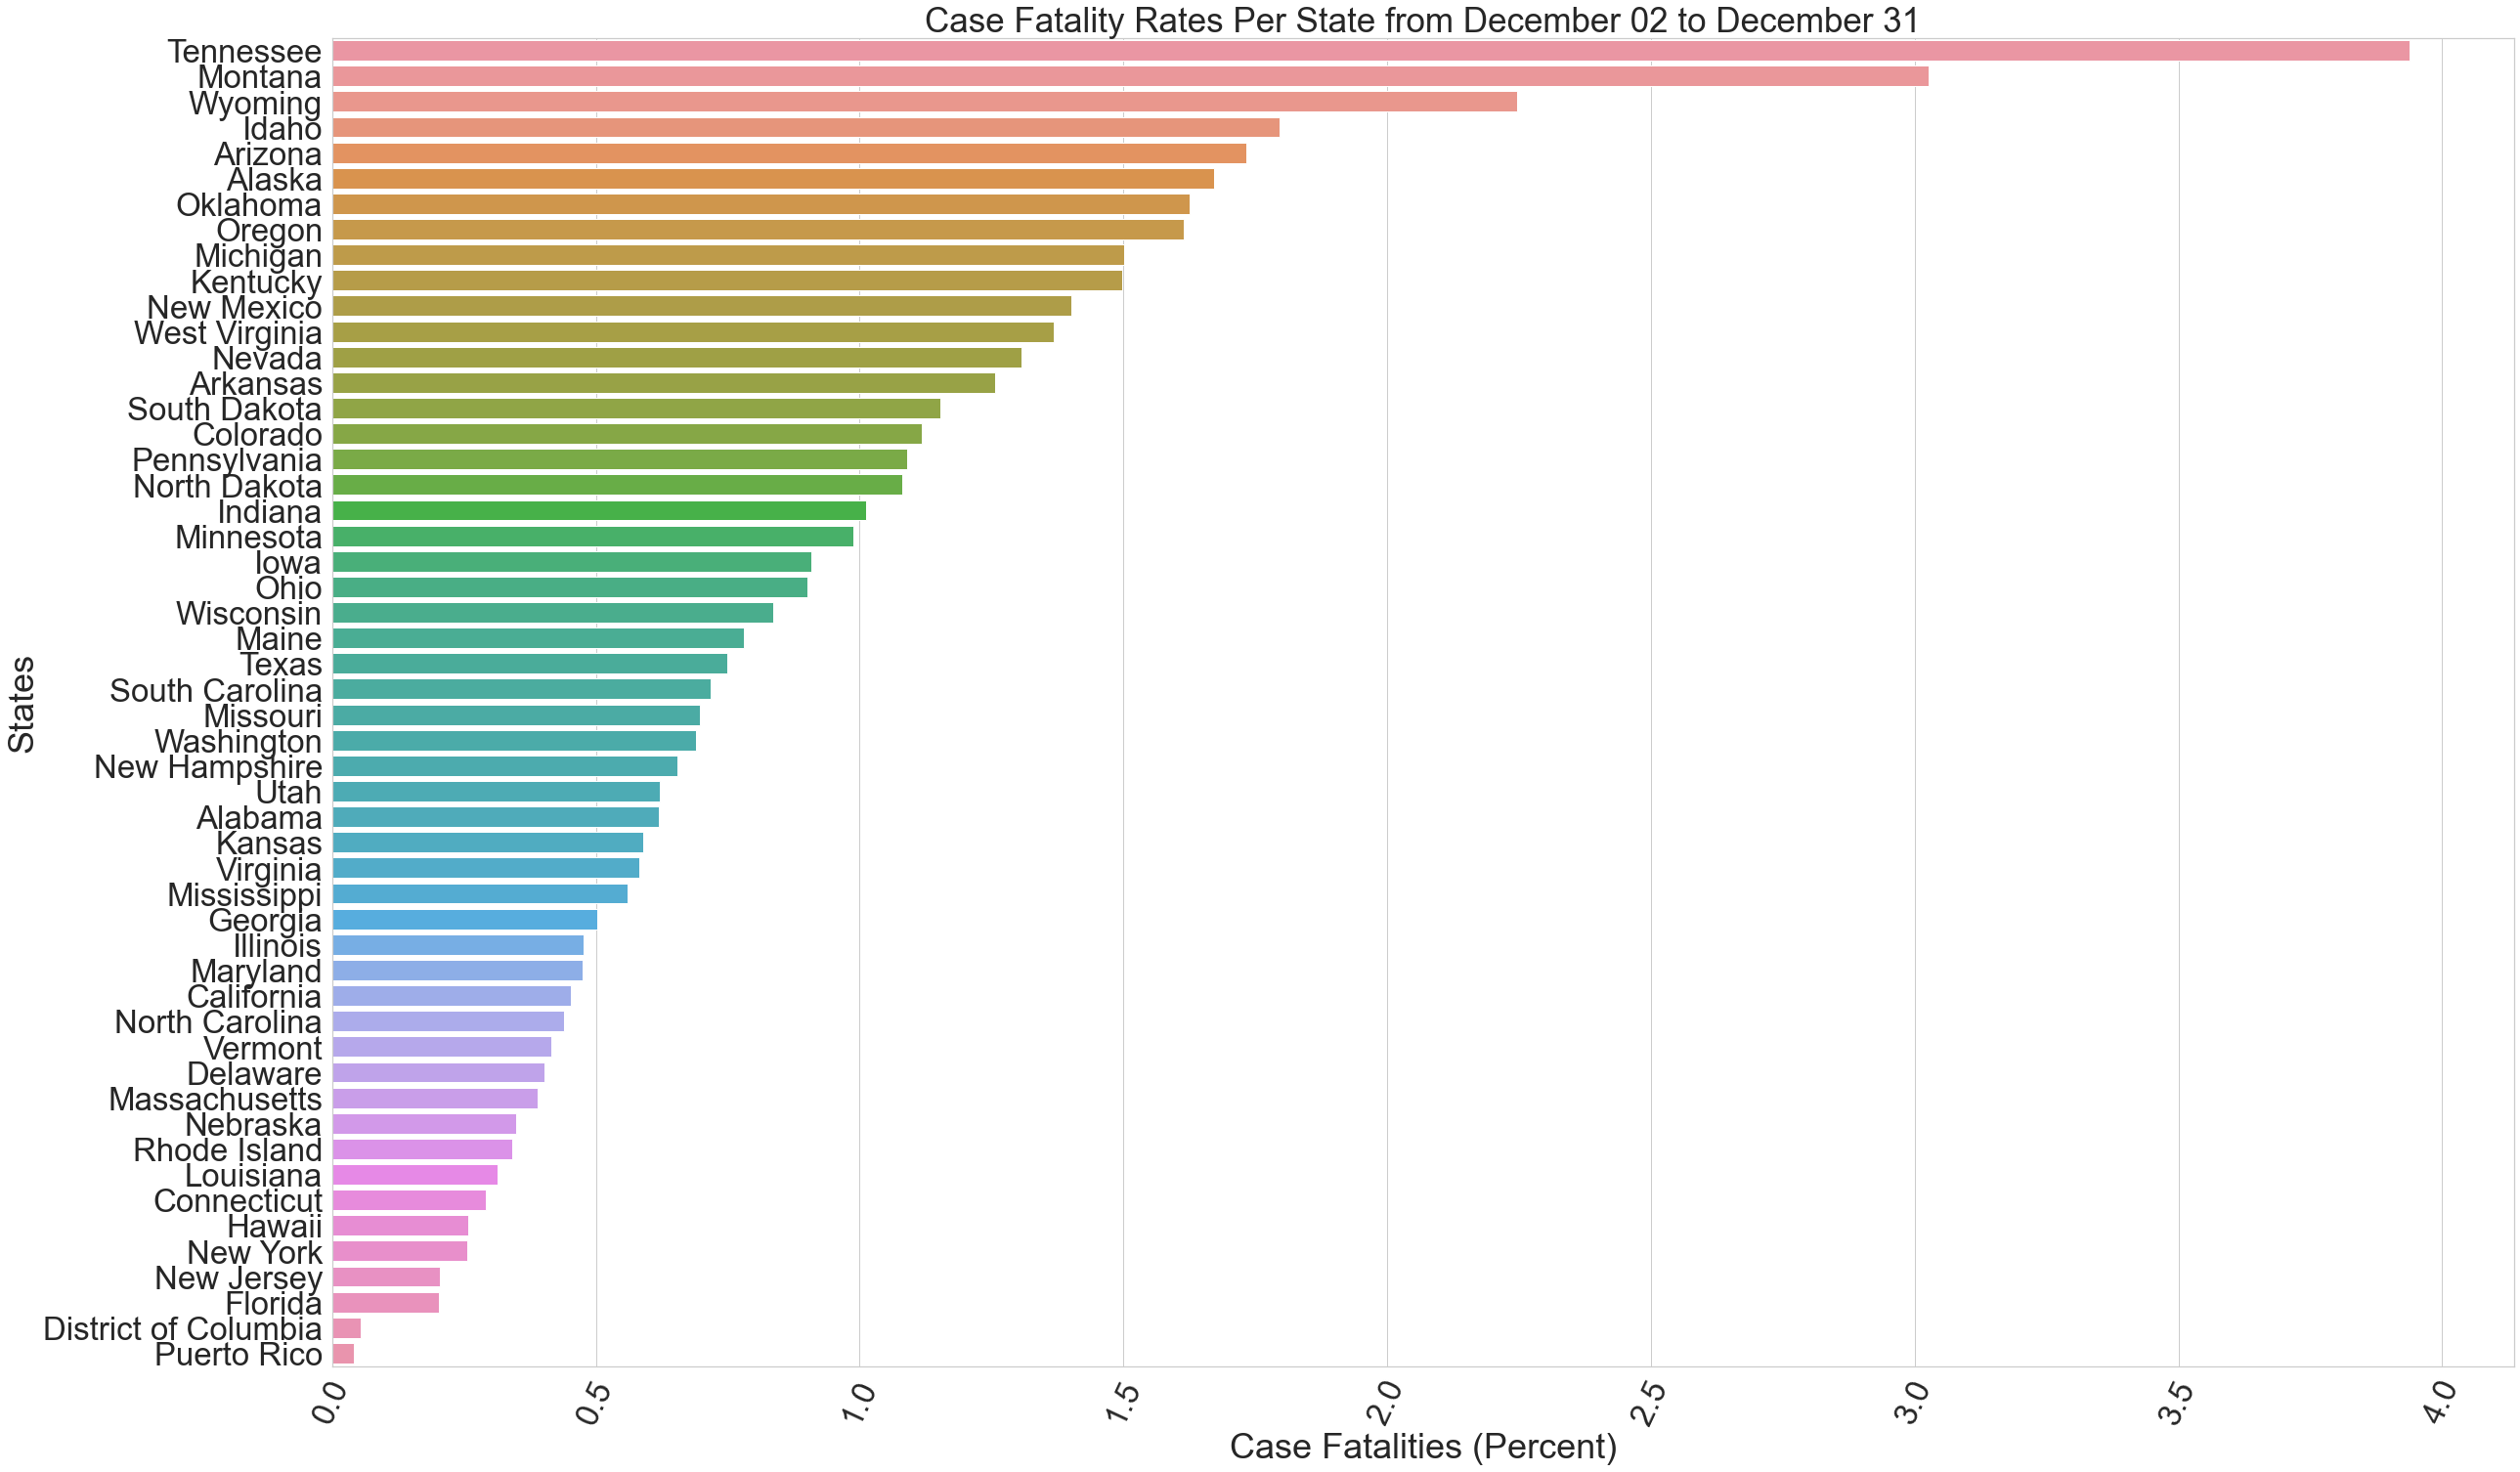

In [46]:
statsgraph=stats.graph(stats.statsDF,col="CFR")

The United States is %60.95 fully vaccinated.


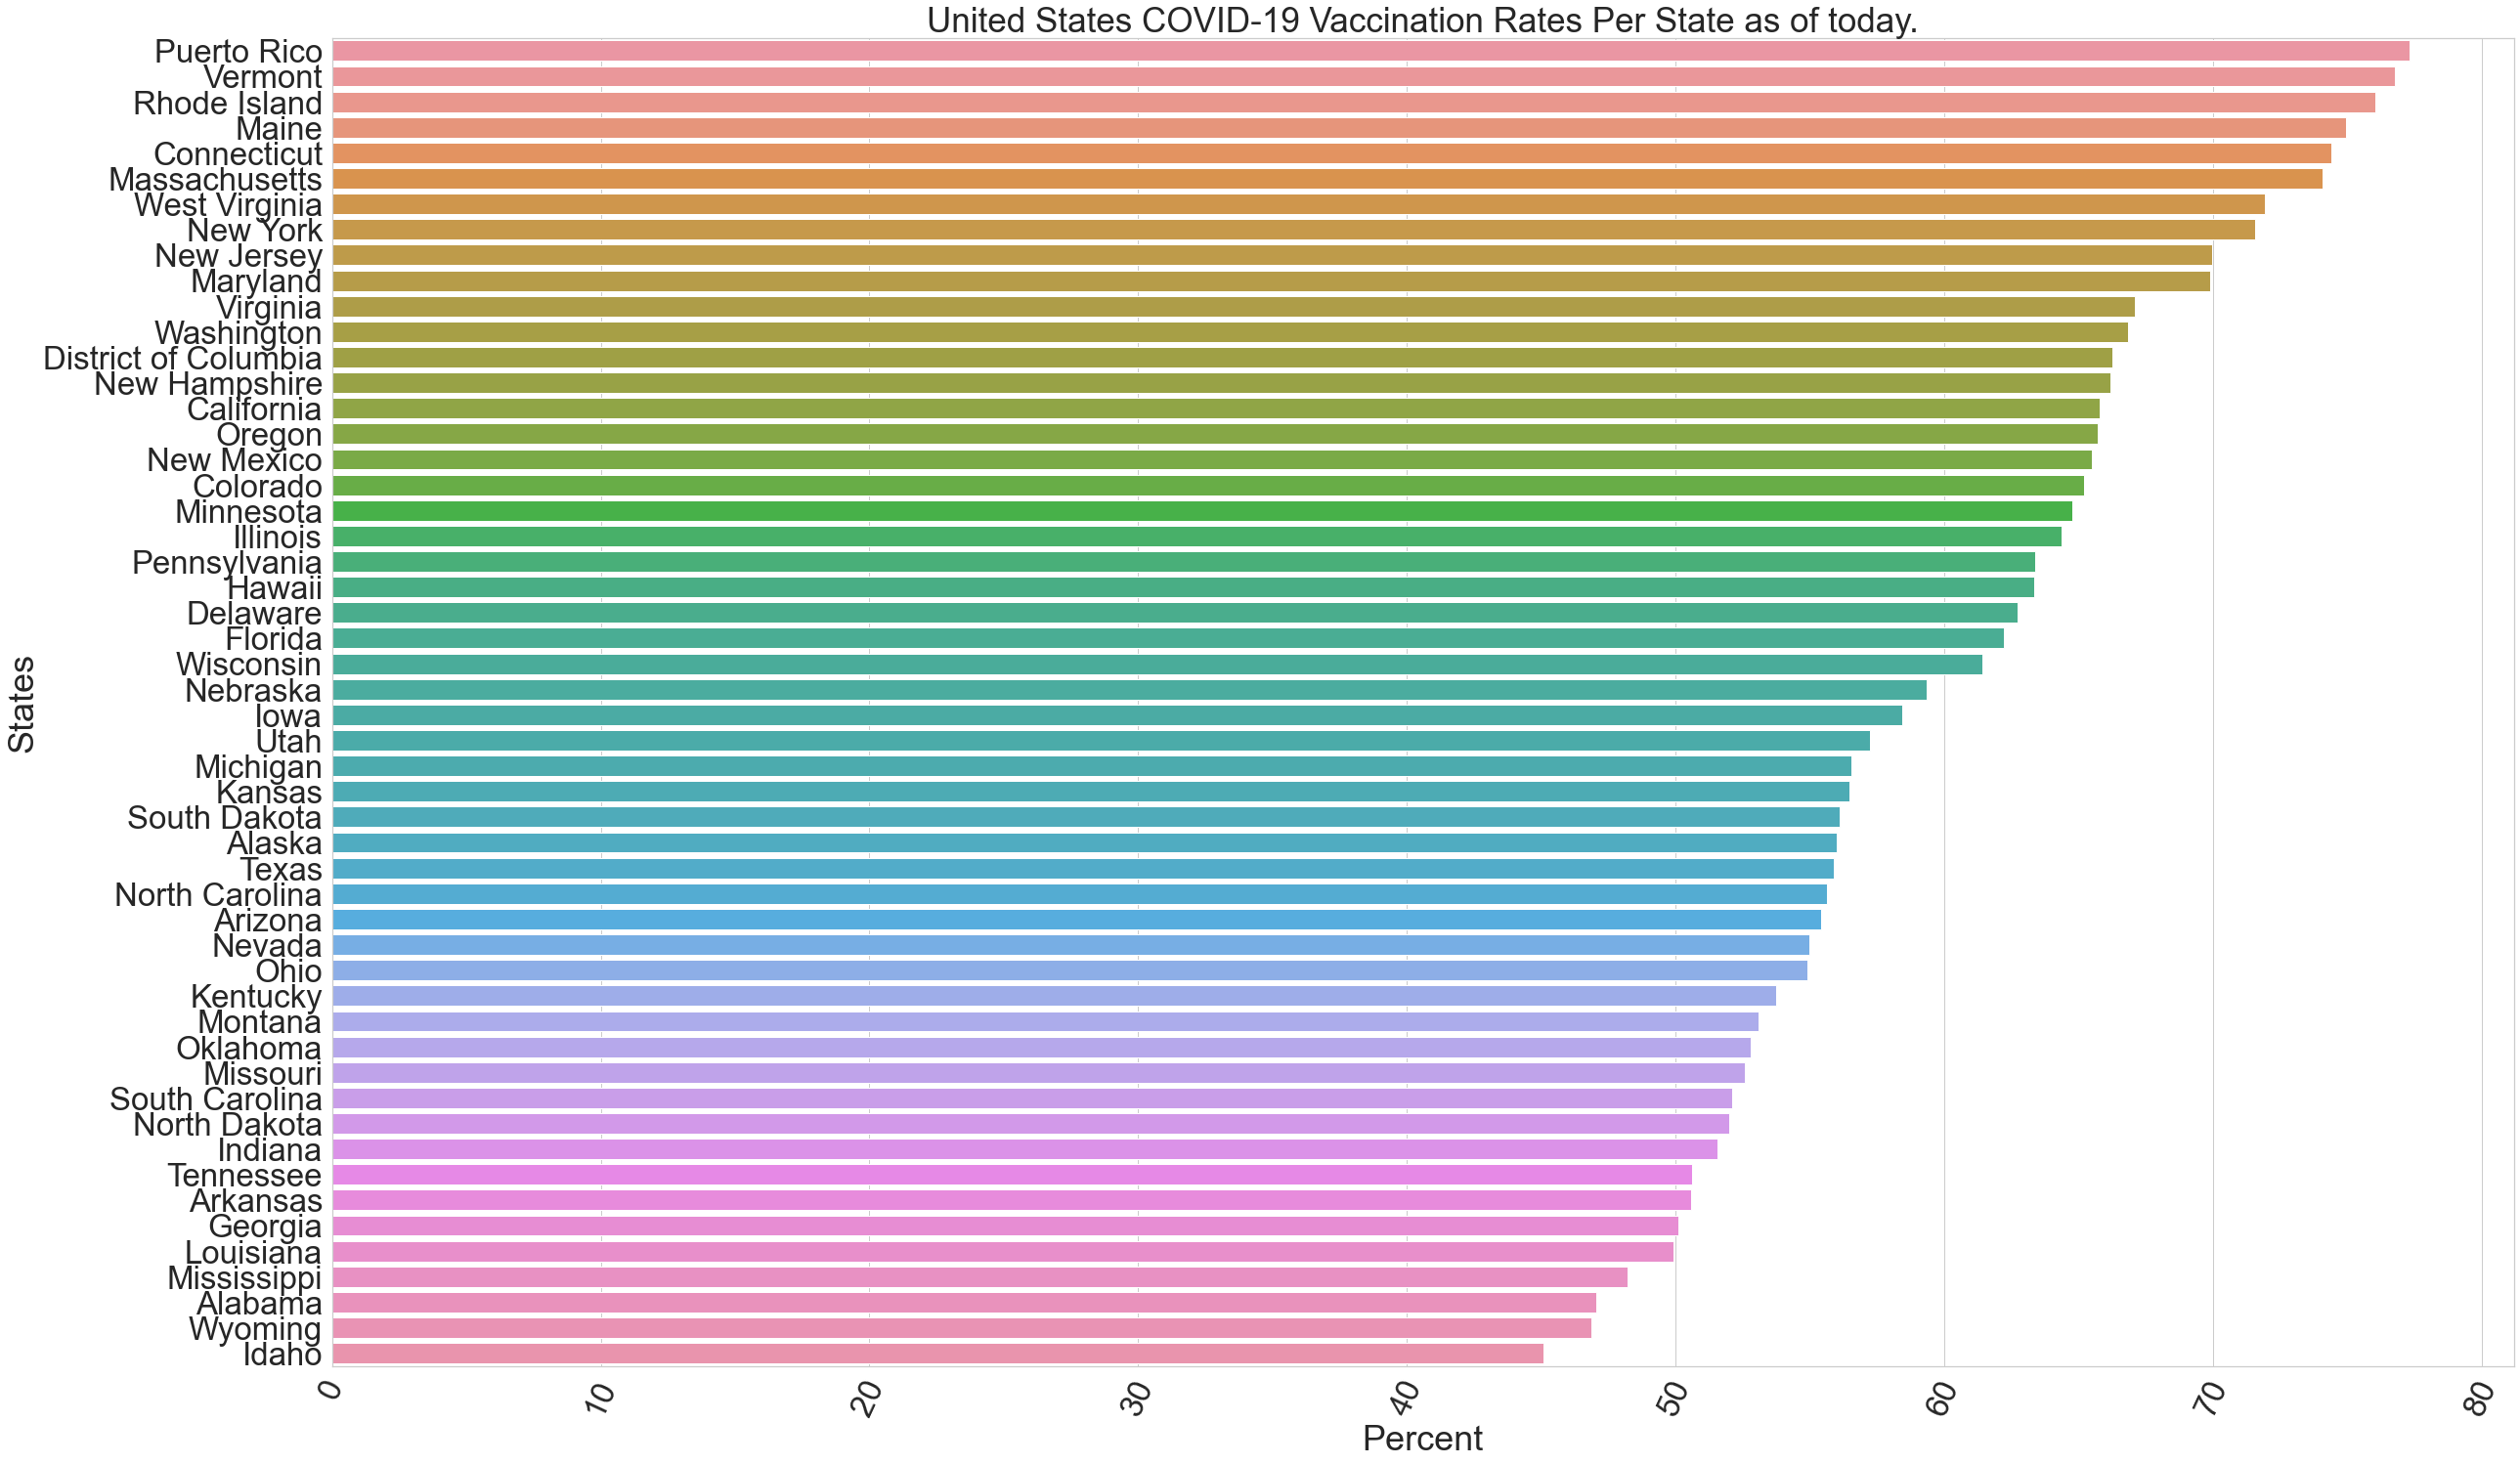

In [47]:
vaxgraph=stats.graph(stats.vax()[0], col="vax")

In [25]:
class States:
    def __init__(self):

        df=pd.read_csv("us-counties.csv")
        abbr=pd.read_csv("abbr.csv")
        df=df.merge(abbr, left_on='state',right_on='full_name')
        df=df.drop(['full_name'],axis=1).reset_index(drop=True)
        df=df[['date','county','state','deaths','cases','abbr']]

        self.df = df

    def getCounty(self, name):
        
        df = self.df[self.df['abbr']==name]
        return df['county'].unique().tolist()

    def getDF(self, name, county):
        
        df = self.df[(self.df['abbr']==name) & (self.df['county']==county)]
        dfdates = df[['date']]
        df = df.pivot(index=None,columns='county', values='deaths')
        df = df.merge(dfdates,left_index=True,right_index=True)
        
        df2 = self.df[(self.df['abbr']==name) & (self.df['county']==county)]
        df2 = df2.pivot(index=None, columns='county', values='cases')
        df2 = df2.merge(dfdates, left_index=True, right_index=True)

        df.loc[:,'month']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df.loc[:,'year']=df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))
        
        df2.loc[:,'month']=df2['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m'))
        df2.loc[:,'year']=df2['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%y'))

        df20=df[df['year']=="20"]
        df21=df[df['year']=="21"]

        df220=df2[df2['year']=="20"]
        df221=df2[df2['year']=="21"]
        
        x=df20.groupby('month')[county].agg('last').reset_index()
        y=df21.groupby('month')[county].agg('last').reset_index()
        deathsDF = pd.concat([x, y]).reset_index(drop=True)

        x=df220.groupby('month')[county].agg('last').reset_index()
        y=df221.groupby('month')[county].agg('last').reset_index()
        casesDF = pd.concat([x, y]).reset_index(drop=True)

        return deathsDF, casesDF

In [26]:
""" Classes for displaying COVID-19 statistics per county per state in the 
United States. """

class Counties:
    def __init__(self, data):
        """Calculating and displaying COVID-19 statistics per county per state.
        
        Attributes:
            week (bool):  
            data (dict): list of URL links to make requests
    
        Side effects:

        Returns:
        """
        state = States()
        self.state = state
        self.data = data
        self.months = ["January '20","February '20","March '20","April '20","May '20","June '20","July '20","August '20","September '20",
                       "October '20","November '20","December '20","January '21","February '21","March '21",
                       "April '21","May '21","June '21","July '21","August '21","September '21"]
        self.county = state.getCounty(self.data)
        print(self.county)

    def all_equal(self, iterable):
        g = groupby(iterable)
        return next(g, True) and not next(g, False)
    
    def countyOrder(self):

        stateDF = self.state.df[self.state.df['abbr'] == self.data].reset_index(drop=True)
        datesDF = stateDF.groupby('date')['deaths'].agg('last').reset_index()['date']
        firstdate = stateDF['date'].iloc[0]
        lastdate = stateDF['date'].iloc[-1]

        caseslst=[]
        deathlst=[]
        countylst=[]

        for cts in self.county:
            stats = stateDF[stateDF['county']==cts]
            stats = stats.groupby('date')[['deaths','cases']].agg('last').reset_index()
            count=0
            data=stats
            col="cases"
            lst3=[]
            lst4=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst3.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst3) == 1:
                    if lst3[0] >= 0:
                        lst4.append(lst3[0])
                    else:
                        lst4.append(-(lst3[0]))
                    continue
                if deaths < 0:
                    lst4.append(-(lst3[count-1]))
                else:
                    lst4.append(lst3[count-1])
            lst4.insert(0,first)
            caseslst.append(lst4)

            count=0
            data=stats
            col="deaths"
            lst5=[]
            lst6=[]
            first=data[col][count]
            while count < len(data)-1:
                count+=1
                lst5.append(data[col][count]-data[col][count-1])
                deaths=data[col][count]-data[col][count-1]
                if len(lst5) == 1:
                    if lst5[0] >= 0:
                        lst6.append(lst5[0])
                    else:
                        lst6.append(-(lst5[0]))
                    continue
                if deaths < 0:
                    lst6.append(-(lst5[count-1]))
                else:
                    lst6.append(lst5[count-1])
            lst6.insert(0,first)
            deathlst.append(lst6)

        avgCases=[]
        avgDeaths=[]
        totalCases=[]
        totalDeaths=[]
        casescts=[]
        deathscts=[]
        eachcounty=[]
        countylen = len(self.county)
        print("NUMBER OF COUNTIES"+": "+str(countylen))

        for things, things2, cts in zip(caseslst, deathlst, self.county):
            try:
                avgCases.append(round(sum(things[1:])/len(things[1:]),2))
                avgDeaths.append(round(sum(things2[1:])/len(things2[1:]),2))
                totalCases.append(sum(things[1:]))
                totalDeaths.append(sum(things2[1:]))
                eachcounty.append(cts)
                casescts.append((cts,things[1:]))
                deathscts.append((cts,things2[1:]))
                newDF = pd.DataFrame({"county":eachcounty,"deaths":totalDeaths,"cases":totalCases})
            except ValueError:
                continue
            except ZeroDivisionError:
                continue

        figsize=(40,10)
        figsize = (figsize if countylen <= 5
                  else (40,15) if countylen > 5 and countylen <= 30
                  else (40,25) if countylen > 30 and countylen <= 50
                  else (40,35) if countylen > 50 and countylen <= 70
                  else (40,45) if countylen > 70 and countylen <= 90
                  else (40,55) if countylen > 90 and countylen <= 110
                  else (40,75) if countylen > 110 and countylen <=135
                  else (40,85) if countylen > 135 and countylen <= 160
                  else (40,135))

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=figsize)
        x=sns.barplot(data=newDF.sort_values(by='deaths',ascending=False),y='county',x='deaths',ci=None)
        x.tick_params(axis='x', rotation=65)
        x.ticklabel_format(style='plain', axis='x')
        x.set_title("Total Deaths Per County from "+firstdate+" to "+lastdate,fontsize=35)
        x.set_xlabel("Deaths")
        x.set_ylabel("States");

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=figsize)
        x=sns.barplot(data=newDF.sort_values(by='cases',ascending=False),y='county',x='cases',ci=None)
        x.tick_params(axis='x', rotation=65)
        x.ticklabel_format(style='plain', axis='x')
        x.set_title("Total Cases Per County from "+firstdate+" to "+lastdate,fontsize=35)
        x.set_xlabel("Cases")
        x.set_ylabel("States");

        return None

    def get_counties(self, col, stats=False):

        if col not in self.county:
            return "Please enter a valid county."
        deathData = self.state.getDF(self.data, col)[0]
        caseData = self.state.getDF(self.data, col)[1]
        counties = self.state.getCounty(self.data)

        checkNum = int(deathData['month'].iloc[0])-1
        statlst = []
        count=0
        months=self.months[checkNum:]
        lst=[]
        lst2=[]
        first=deathData[col][count]
        statlst.append('There Were '+str(first)+' Deaths In '+months[count])    
        while count < len(deathData)-1:
            count+=1
            lst.append(deathData[col][count]-deathData[col][count-1])
            deaths=deathData[col][count]-deathData[col][count-1]
            if len(lst) == 1:
                if lst[0] >= 0:
                    statlst.append('There Were '+str(lst[0])+' More Deaths In '+months[count]+' Up From '+months[count-1])
                    lst2.append(lst[0])
                else:
                    statlst.append('There Were '+str(-(lst[0]))+' Less Deaths In '+months[count]+' Down From '+months[count-1])
                    lst2.append(-(lst[0]))
                continue
            if deaths < 0:
                statlst.append('There Were '+str(-(lst[count-1]))+' Less Deaths In '+months[count]+' Down From '+months[count-1])
                lst2.append(-(lst[count-1]))
            else:
                statlst.append('There Were '+str(lst[count-1])+' More Deaths In '+months[count]+' Up From '+months[count-1])
                lst2.append(lst[count-1])
        lst2.insert(0,first)

        if stats == True:
            for words in statlst:
                print(words)
        print()
        
        del statlst[:]
        count = 0
        lst3=[]
        lst4=[]
        first=caseData[col][count]
        statlst.append('There Were '+str(first)+' Cases In '+months[count])    
        while count < len(caseData)-1:
            count+=1
            lst3.append(caseData[col][count]-caseData[col][count-1])
            deaths=caseData[col][count]-caseData[col][count-1]
            if len(lst3) == 1:
                if lst3[0] >= 0:
                    statlst.append('There Were '+str(lst3[0])+' More Cases In '+months[count]+' Up From '+months[count-1])
                    lst4.append(lst3[0])
                else:
                    statlst.append('There Were '+str(-(lst3[0]))+' Less Cases In '+months[count]+' Down From '+months[count-1])
                    lst4.append(-(lst3[0]))
                continue
            if deaths < 0:
                statlst.append('There Were '+str(-(lst3[count-1]))+' Less Cases In '+months[count]+' Down From '+months[count-1])
                lst4.append(-(lst3[count-1]))
            else:
                statlst.append('There Were '+str(lst3[count-1])+' More Cases In '+months[count]+' Up From '+months[count-1])
                lst4.append(lst3[count-1])
        lst4.insert(0,first)
        df=pd.DataFrame({'months':months,'deaths':lst2,'cases':lst4})

        if stats == True:
            for words in statlst:
                print(words)
        print()

        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=(40,20))
        x=sns.lineplot(data=df,x='months',y='deaths',ci=None, linewidth=7,color="black")
        x.tick_params(axis='x', rotation=65)
        x.set_title(col+" County COVID-19 Death Rates Per Month",fontsize=35)
        x.set_xlabel("Months")
        x.set_ylabel("Deaths")
        x.set_xticks(range(len(df)))
        x.set_xticklabels(months)
        
        newStats = Stats(self.county, curr=9, lastmo=3)
        newStats.pretty_graph(x, df, df.columns[0], df.columns[1])
        
        sns.set(font_scale=3)
        sns.set_style("whitegrid")
        plt.figure(figsize=(40,20))
        x=sns.lineplot(data=df,x='months',y='cases',ci=None, linewidth=7,color="black")
        x.tick_params(axis='x', rotation=65)
        x.set_title(col+" County COVID-19 Case Rates Per Month",fontsize=35)
        x.set_xlabel("Months")
        x.set_ylabel("Cases")
        x.set_xticks(range(len(df)))
        x.set_xticklabels(months)
        
        newStats.pretty_graph(x, df, df.columns[0], df.columns[2])

        return None

def parse_args(arglist):

    parser = ArgumentParser()
    parser.add_argument("data", help="CSV files and URL links",
                        type=str)
    args = parser.parse_args(arglist)

    return args

def main(arglist):

    args = parse_args(arglist)
    w=Stats(args.file)

    return None

In [27]:
counties=Counties('FL')

['Hillsborough', 'Manatee', 'Santa Rosa', 'Broward', 'Lee', 'Charlotte', 'Okaloosa', 'Volusia', 'Alachua', 'Collier', 'Nassau', 'Pasco', 'Pinellas', 'Miami-Dade', 'St. Johns', 'Clay', 'Duval', 'Palm Beach', 'Sarasota', 'Seminole', 'Orange', 'Osceola', 'Baker', 'Citrus', 'Escambia', 'Lake', 'Brevard', 'Polk', 'Leon', 'Sumter', 'Walton', 'Hernando', 'Indian River', 'Jackson', 'Martin', 'Monroe', 'Bay', 'Highlands', 'Marion', 'Putnam', 'St. Lucie', 'Bradford', 'Columbia', 'DeSoto', 'Flagler', 'Unknown', 'Gadsden', 'Washington', 'Levy', 'Suwannee', 'Hendry', 'Glades', 'Wakulla', 'Holmes', 'Calhoun', 'Union', 'Gulf', 'Hardee', 'Madison', 'Okeechobee', 'Franklin', 'Dixie', 'Jefferson', 'Hamilton', 'Gilchrist', 'Taylor', 'Lafayette', 'Liberty']


NUMBER OF COUNTIES: 68


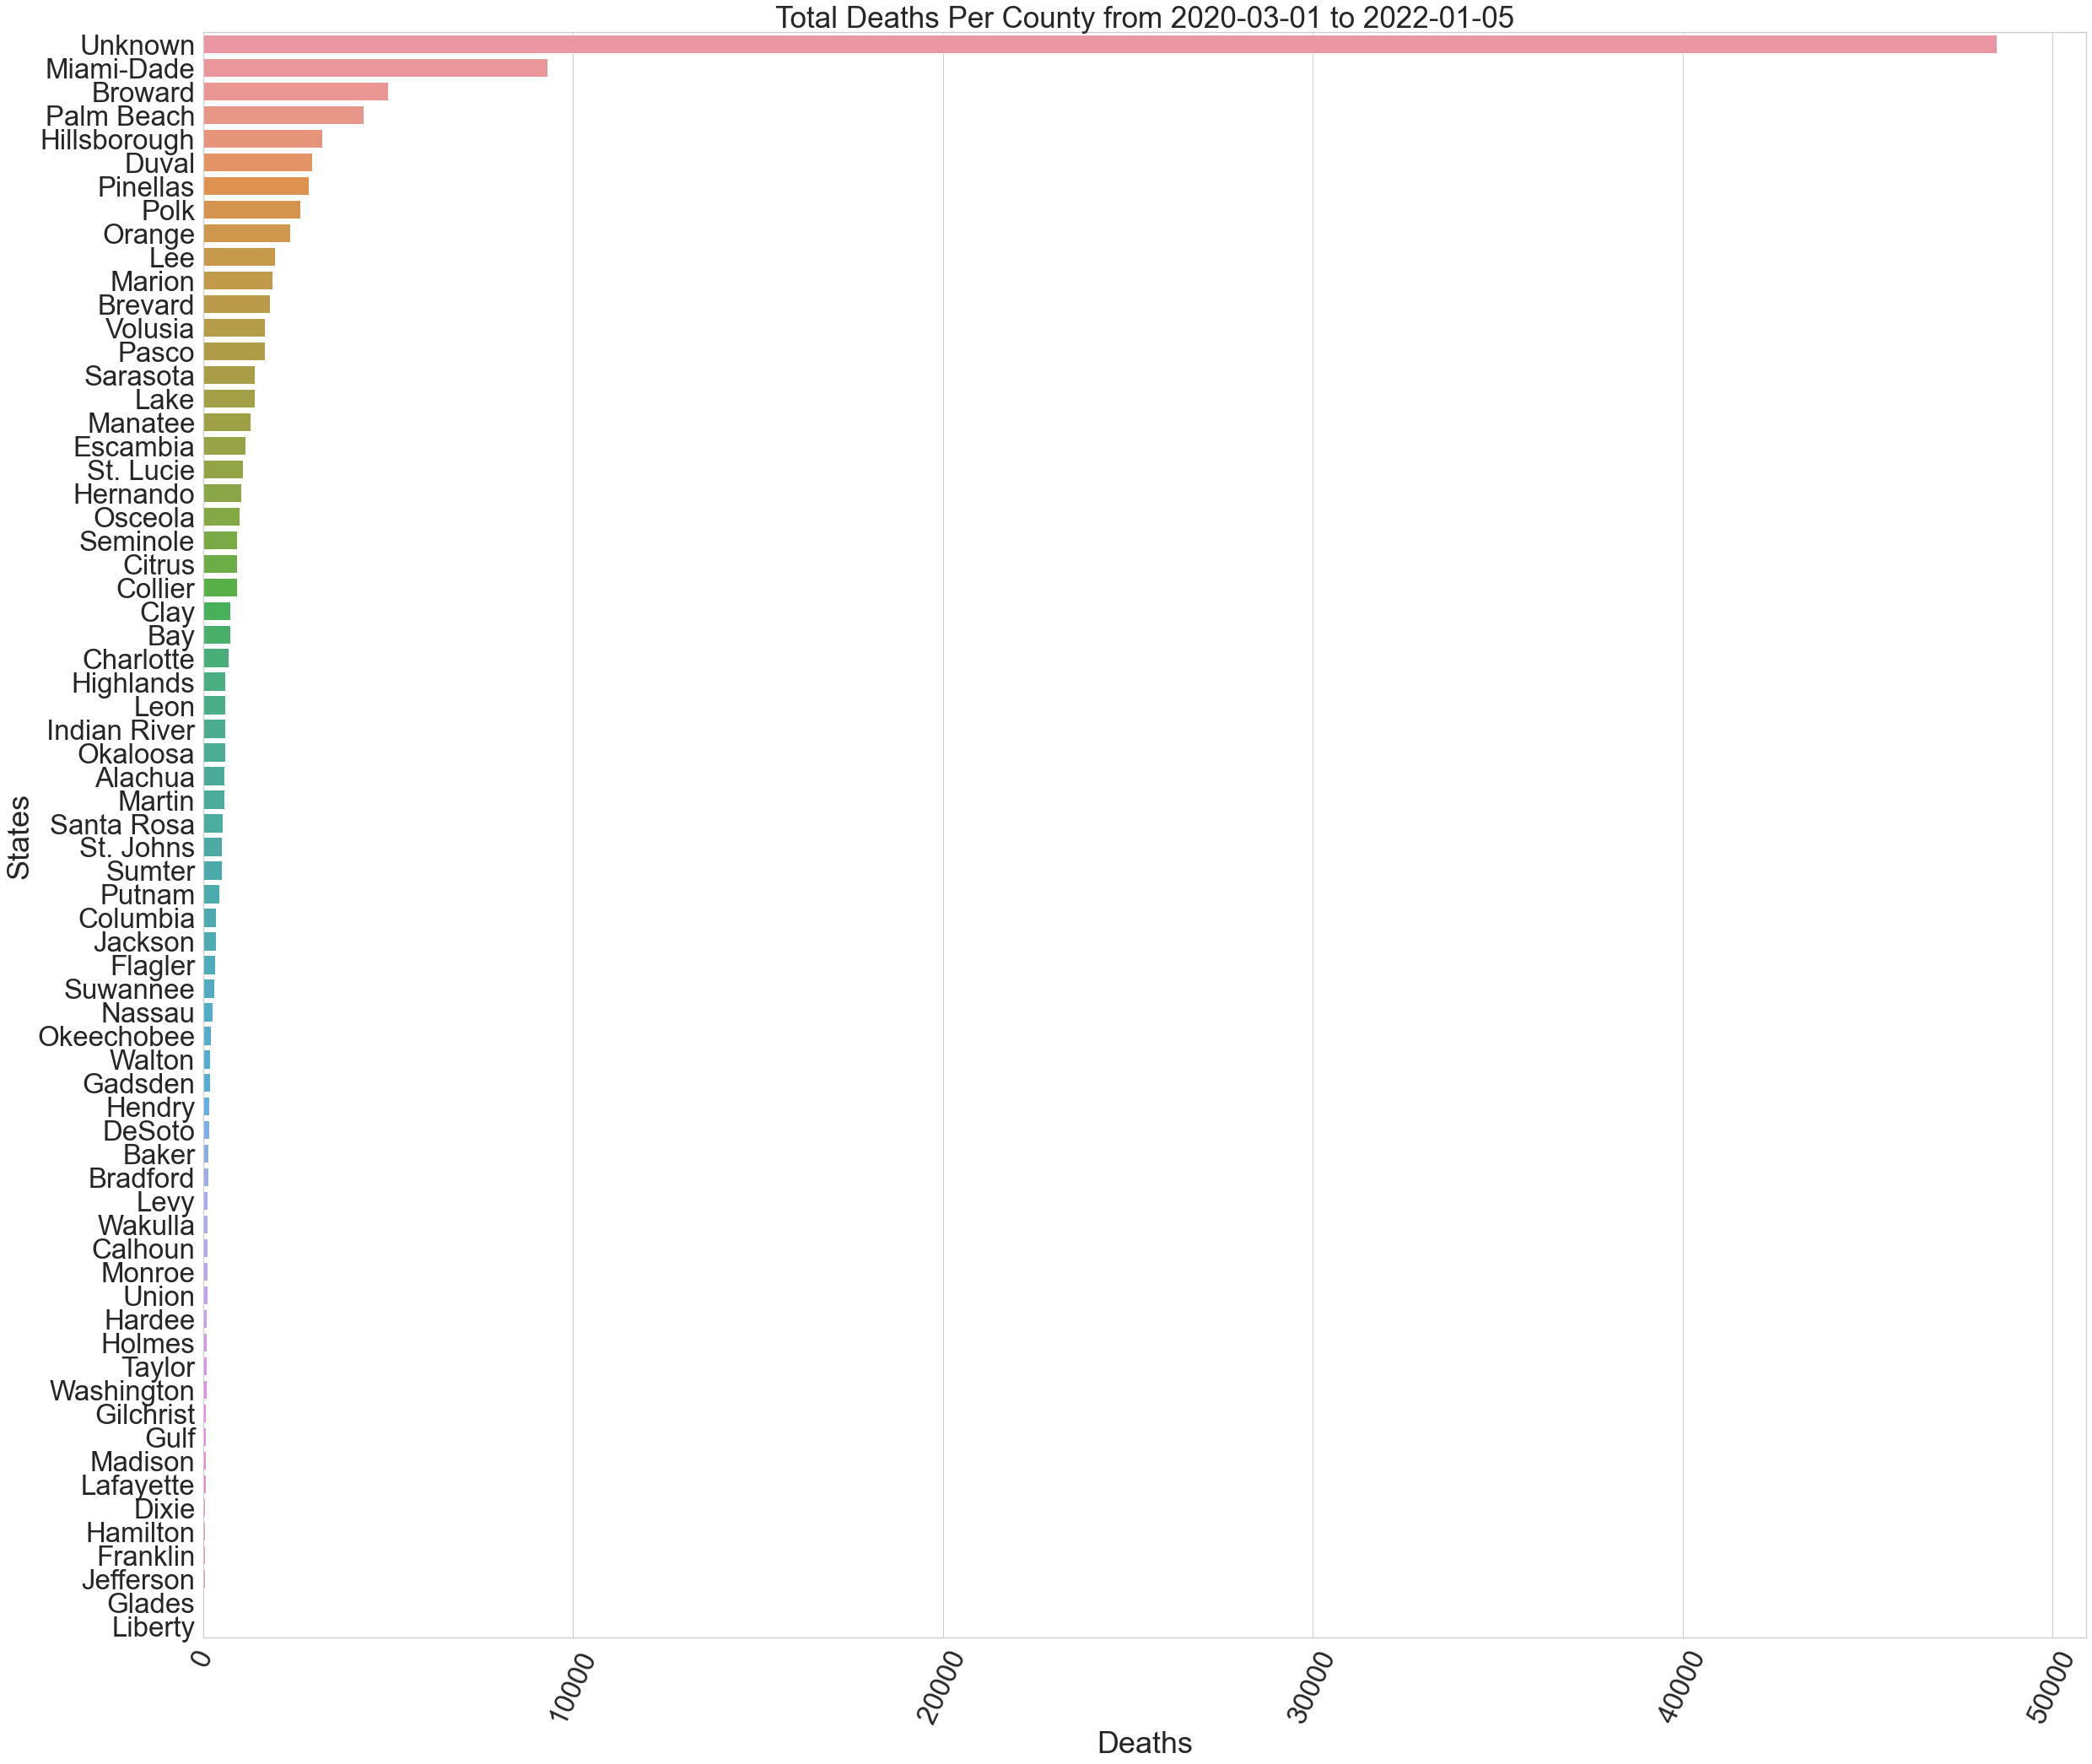

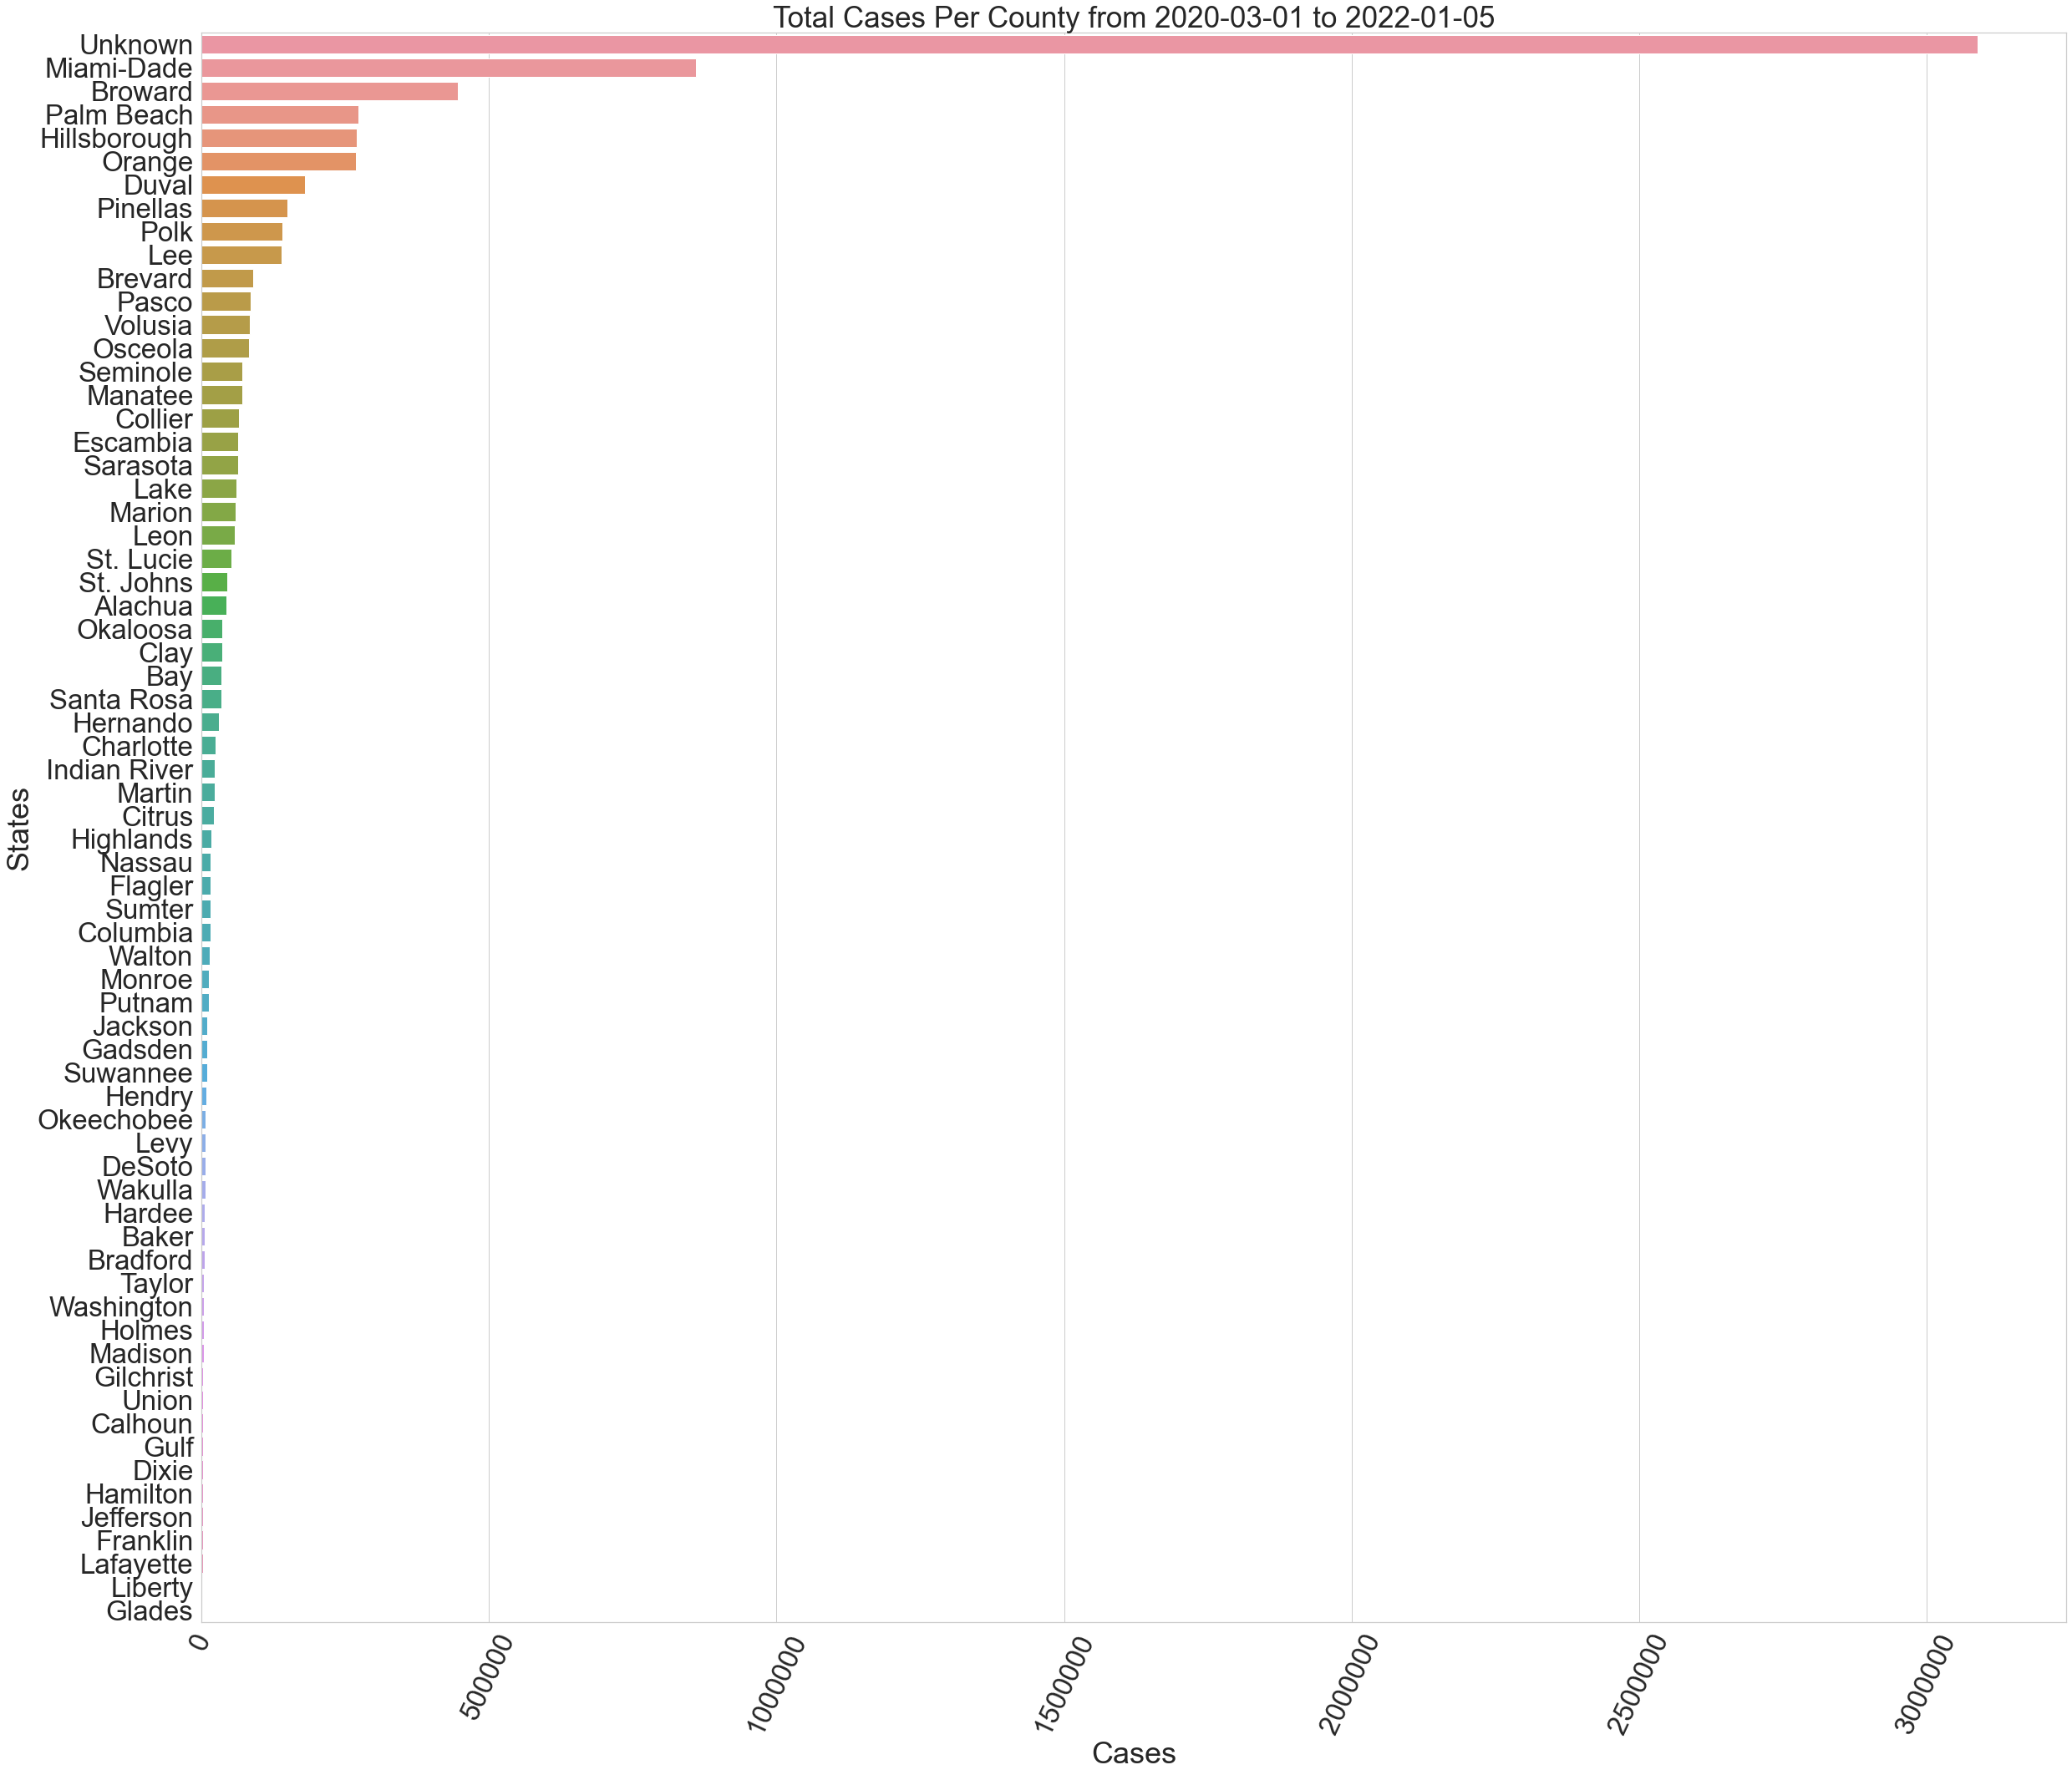

In [28]:
counties.countyOrder()

In [29]:
counties.get_counties(col="Montgomery")

'Please enter a valid county.'